In [1]:
# Imports
import sys
sys.path.insert(1, '../')
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from python.analysis import Master
from python.analysis.PairPlots import *
import time

import pandas as pd

In [2]:
# Edit the base classes to fit what we want to be doing with pairs
class RecoPairData(Master.RecoParticleData):
    @property
    def pandoraTag(self):
        self.LoadData("pandoraTag", "pandoraTag")
        return getattr(self, f"_{type(self).__name__}__pandoraTag")

class PairData(Master.Data):
    def __init__(self, _filename : str = None, includeBackTrackedMC : bool = False, _nEvents : int = -1, _start : int = 0) -> None:
        super().__init__(_filename, includeBackTrackedMC, _nEvents, _start)
        if self.filename != None:
            self.recoParticles = RecoPairData(self) # Set the reco particles as Pairs to inlucde pandora tag and CNN score
    
    # # Old method, now using Shyam's updated method instead
    # def ApplyBeamTypeFilter(self, beam_pdg):
    #     """ Applies a beam filter to the sample, which selects events
    #         which have a beam particle with the supplied pdg code.
    #     """
    #     if self.recoParticles.beam_number is None:
    #         print("data doesn't contain beam number, can't apply filter.")
    #         return
    #     hasBeam = self.recoParticles.beam_number != -999 # check if event has a beam particle
    #     hasBeam = np.logical_and(self.recoParticles.beamVertex.x != -999, hasBeam)

    #     beamParticle = self.recoParticles.number == self.recoParticles.beam_number # get beam particle
    #     del_prop(self.recoParticles, "number")
    #     self.beamParticleDaughters = self.recoParticles.mother == self.recoParticles.beam_number # get daugter of beam particle
    #     del_prop(self.recoParticles, "beam_number")
    #     del_prop(self.recoParticles, "mother")
        
    #     beam_type_mask = ak.all(self.trueParticlesBT.pdg[beamParticle] == beam_pdg, -1)
    #     # combine masks
    #     # particle_mask = np.logical_or(beamParticle, beamParticleDaughters)
    #     #? which one to do?
    #     self.Filter([hasBeam, beam_type_mask[hasBeam]], [hasBeam, beam_type_mask[hasBeam]]) # filter data
    #     # self.Filter([hasBeam, particle_mask[hasBeam]], [hasBeam]) # filter data


# This is a memory management tool, currently not really necessary
def del_prop(obj, property_name):
    del(obj.__dict__["_RecoPairData__" + property_name])
    return


In [3]:
# Load the events and performs cuts
def load_and_cut_data(path, batch_size = -1, batch_start = -1, cnn_cut = True):
    events = PairData(path, includeBackTrackedMC=True, _nEvents=batch_size, _start=batch_start)

    # Apply cuts:
    n = [["Event selection", "Number of PFOs", "Average PFOs per event", "Number of events", "Percentage of events removed"]]
    n.append(["no selection", ak.count(events.trueParticlesBT.pdg),ak.count(events.trueParticlesBT.pdg)/ak.count(events.eventNum), ak.count(events.eventNum), 0])

    plt.figure(figsize=(8,6))
    plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
    plt.xlabel("Number of PFOs in event")
    plt.ylabel("Count")
    plt.title("No cut")
    plt.show()

    # # Require a beam particle to exist. ETA ~60s:
    # ts = time.time()
    # events.ApplyBeamTypeFilter(211)
    # print(f"pi+ beam done in {time.time()  - ts}s")
    # evt_remaining = ak.count(events.eventNum)
    # n.append(["pi+ beam", ak.count(events.trueParticlesBT.pdg), evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])

    # Require a beam particle to exist. ETA ~15s:
    ts = time.time()
    events.ApplyBeamFilter() # apply beam filter if possible
    print(f"beam done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append([ "beam", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2] ])

    plt.figure(figsize=(8,6))
    plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
    plt.xlabel("Number of PFOs in event")
    plt.ylabel("Count")
    plt.title("Beam")
    plt.show()

    # Require pi+ beam. ETA ~10s
    ts = time.time()
    true_beam = events.trueParticlesBT.pdg[events.recoParticles.beam_number == events.recoParticles.number]
    f = ak.all(true_beam == 211, -1)
    events.Filter([f], [f])
    del(true_beam)
    print(f"pi+ beam done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append(["pi+ beam", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2]])

    plt.figure(figsize=(8,6))
    plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
    plt.xlabel("Number of PFOs in event")
    plt.ylabel("Count")
    plt.title("(beam) pi+ beam")
    plt.show()

    # # Only look at PFOs with > 50 hits. ETA ~30s:
    # ts = time.time()
    # events.Filter([events.recoParticles.n_hits > 50], [])
    # del_prop(events.recoParticles, "n_hits")
    # print(f"Hits > 50 done in {time.time()  - ts}s")
    # evt_remaining = ak.count(events.eventNum)
    # n.append(["n_hits >= 51", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2]])

    if cnn_cut:
        # Take CNNScore > 0.36. ETA ~15s:
        cnn_cut = 0.36
        ts = time.time()
        events.Filter([events.recoParticles.cnnScore > cnn_cut], [])
        del_prop(events.recoParticles, "cnnScore")
        print(f"CNNScore > 0.36 done in {time.time()  - ts}s")
        evt_remaining = ak.count(events.eventNum)
        n.append([f"CNNScore > {cnn_cut}", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2]])

        plt.figure(figsize=(8,6))
        plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
        plt.xlabel("Number of PFOs in event")
        plt.ylabel("Count")
        plt.title("(beam, pi+) CNNScore>0.36")
        plt.show()

    # Require >= 2 PFOs. ETA ~90s:
    ts = time.time()
    f = Master.NPFPMask(events, -1)
    del_prop(events.recoParticles, "direction")
    del_prop(events.recoParticles, "shower_start_pos")
    events.Filter([f], [f])
    print(f"PFOs >= 2 done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append(["nPFP >= 2", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2]])

    plt.figure(figsize=(8,6))
    plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
    plt.xlabel("Number of PFOs in event")
    plt.ylabel("Count")
    plt.title("(beam, pi+, CNNScore) NPFPs >=2")
    plt.show()

    print("\n".join([str(l) for l in n]))
    
    plt.close()

    return events

def load_and_cut_data_two_photon(path, batch_size = -1, batch_start = -1, cnn_cut=True, valid_momenta=True, beam_slice_cut=True):
    events = PairData(path, includeBackTrackedMC=True, _nEvents=batch_size, _start=batch_start)

    # Apply cuts:
    n = [["Event selection", "Number of PFOs", "Average PFOs per event", "Number of events", "Percentage of events remaining"]]
    n.append(["no selection", ak.count(events.trueParticlesBT.pdg),ak.count(events.trueParticlesBT.pdg)/ak.count(events.eventNum), ak.count(events.eventNum), 100])

    # Single pi0
    ts = time.time()
    Master.BeamMCFilter(events, returnCopy=False)
    print(f"single pi0 done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append([ "beam -> pi0 + X", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(evt_remaining/n[1][3]) ])

    # Require diphoton decay from the pi0
    ts = time.time()
    f = Master.Pi0TwoBodyDecayMask(events)
    events.Filter([f], [f])
    print(f"pi+ beam done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append(["diphoton decay", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(evt_remaining/n[1][3]) ])

    # Require a beam particle to exist. ETA ~15s:
    ts = time.time()
    events.ApplyBeamFilter() # apply beam filter if possible
    print(f"beam done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append([ "beam", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(evt_remaining/n[1][3]) ])


    # Require pi+ beam. ETA ~10s
    ts = time.time()
    true_beam = events.trueParticlesBT.pdg[events.recoParticles.beam_number == events.recoParticles.number]
    f = ak.all(true_beam == 211, -1)
    events.Filter([f], [f])
    del(true_beam)
    print(f"pi+ beam done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append(["pi+ beam", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(evt_remaining/n[1][3]) ])

    # # Only look at PFOs with > 50 hits. ETA ~30s:
    # ts = time.time()
    # events.Filter([events.recoParticles.n_hits > 50], [])
    # del_prop(events.recoParticles, "n_hits")
    # print(f"Hits > 50 done in {time.time()  - ts}s")
    # evt_remaining = ak.count(events.eventNum)
    # n.append(["n_hits >= 51", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(evt_remaining/n[1][3]) ])

    if beam_slice_cut:
        slice_mask = [[]] * ak.num(events.recoParticles.beam_number, axis=0)
        ts = time.time()
        for i in range(ak.num(slice_mask, axis=0)):
            slices = events.recoParticles.slice_id[i]
            beam_slice = slices[events.recoParticles.number[i] == events.recoParticles.beam_number[i]]
            slice_mask[i] = list(slices == beam_slice)
        slice_mask = ak.Array(slice_mask)
        
        events.Filter([slice_mask], [])
        print(f"Beam slice done in {time.time()  - ts}s")
        evt_remaining = ak.count(events.eventNum)
        n.append(["Beam slice", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(evt_remaining/n[1][3]) ])

    if cnn_cut:
        # Take CNNScore > 0.36. ETA ~15s:
        cnn_cut = 0.36
        ts = time.time()
        events.Filter([events.recoParticles.cnnScore > cnn_cut], [])
        print(f"CNNScore > 0.36 done in {time.time()  - ts}s")
        evt_remaining = ak.count(events.eventNum)
        n.append([f"CNNScore > {cnn_cut}", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(evt_remaining/n[1][3]) ])

    if valid_momenta:
        ts = time.time()
        reco_momenta=events.recoParticles.momentum
        events.Filter([np.logical_and(np.logical_and(reco_momenta.x != -999., reco_momenta.y != -999.), reco_momenta.z != -999.)], [])
        print(f"Valid momenta done in {time.time()  - ts}s")
        evt_remaining = ak.count(events.eventNum)
        n.append(["Valid momenta", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(evt_remaining/n[1][3]) ])

    # Require >= 2 PFOs. ETA ~90s:
    ts = time.time()
    f = Master.NPFPMask(events, -1)
    events.Filter([f], [f])
    print(f"PFOs >= 2 done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append(["nPFP >= 2", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(evt_remaining/n[1][3]) ])
    

    print(pd.DataFrame(n[1:], columns = n[0]))
    # print("\n".join([str(l) for l in n]))
    
    plt.close()

    return events

In [1]:
def simple_sig_bkg_hist(
        prop_name, units, property, sig_mask,
        path="/users/wx21978/projects/pion-phys/plots/photon_pairs/", unique_save_id = "",
        y_scaling = 'log', bin_size = None, range=None, bins = 100, **kwargs
    ):

    if path[-1] != '/':
        path += '/'

    if not isinstance(y_scaling, list):
        y_scaling = [y_scaling]

    if not isinstance(range, list):
        range = [range]
    if not ( (isinstance(bins, list) or isinstance(bins, np.ndarray)) and len(bins) == len(range) ):
        # Strictly, this could be a problem on edge-case that we want to use one fewer bins than the
        # number of ranges  we investigate, but this is sufficiently likely that we can ignore that
        bins = [bins for _ in range]

    for y_scale in y_scaling:
        for i, r in enumerate(range):
            if r is None:
                hist_range = np.max(property)
            elif isinstance(r, tuple):
                hist_range = r[1] - r[0]
                kwargs.update({"range":r})
            else:
                hist_range = r
                kwargs.update({"range":(0,r)})
            
            if bin_size is None:
                if isinstance(bins[i], int):
                    bin_size = f"{hist_range/bins[i]:.2g}" + units
                else:
                    bin_size = f"{hist_range/len(bins[i]):.2g}" + units
            

            plt.figure(figsize=(12,9))
            plt.hist(ak.ravel(property[sig_mask]),                 bins=bins[i], label="signal", **kwargs)
            plt.hist(ak.ravel(property[np.logical_not(sig_mask)]), bins=bins[i], label="background", **kwargs)
            plt.legend()
            plt.yscale(y_scale)
            plt.xlabel(prop_name.title() + "/" + units)
            plt.ylabel("Count/" + bin_size)
            plt.show()
    
    return

def plot_pair_hists(
        prop_name, units, property, sig_count,
        path="/users/wx21978/projects/pion-phys/plots/photon_pairs/", unique_save_id = "",
        inc_stacked=True, inc_norm=True, inc_log=True, bin_size = None,
        range=None, bins=100, weights=None, **kwargs
    ):
    
    if path[-1] != '/':
        path += '/'

    if not isinstance(range, list):
        range = [range]
    if not ( (isinstance(bins, list) or isinstance(bins, np.ndarray)) and len(bins) == len(range) ):
        # Strictly, this could be a problem on edge-case that we want to use one fewer bins than the
        # number of ranges  we investigate, but this is sufficiently likely that we can ignore that
        bins = [bins] * len(range)
    
    # There is definitely a better way to do this...
    if not isinstance(weights, list):
        if inc_stacked: # Need to keep track of the raw weights if producing a stacked plot
            raw_weights = [weights] * len(range)
        if weights is None:
            weights = [{2:None, 1:None, 0:None}] * len(range)
        else:
            weights = [{2:ak.ravel(weights[sig_count == 2]), 1:ak.ravel(weights[sig_count == 1]), 0:ak.ravel(weights[sig_count == 0])}] * len(range)
    else:
        if inc_stacked: # Need to keep track of the raw weights if producing a stacked plot
            raw_weights = weights
        for i in np.arange(len(weights)):
            if weights[i] is None:
                weights[i] = {2:None, 1:None, 0:None}
            else:
                weights[i] = {2:ak.ravel(weights[i][sig_count == 2]), 1:ak.ravel(weights[i][sig_count == 1]), 0:ak.ravel(weights[i][sig_count == 0])}

    sig_0 = ak.ravel(property[sig_count == 0])
    sig_1 = ak.ravel(property[sig_count == 1])
    sig_2 = ak.ravel(property[sig_count == 2])

    for i, r in enumerate(range):
        if r is None:
            hist_range = np.max(property)
        elif isinstance(r, tuple):
            hist_range = r[1] - r[0]
            kwargs.update({"range":r})
        else:
            hist_range = r
            kwargs.update({"range":(0,r)})
        
        if bin_size is None:
            if isinstance(bins[i], int):
                bin_size = f"{hist_range/bins[i]:.2g}" + units
            else:
                bin_size = f"{hist_range/len(bins[i]):.2g}" + units
        


        if inc_stacked:
            # Whoever wrote this disgusting way to deal with stacked weights ought to be shot...
            if raw_weights[i] is not None:
                all_weights = ak.ravel(raw_weights[i])
                no_bkg_weights = ak.ravel(raw_weights[i][sig_count != 0])
            else: 
                all_weights = None
                no_bkg_weights = None

            plt.figure(figsize=(12,9))
            # stacked=True doesn't work like this
            # plt.hist(sig_2, histtype='step', label="2 signal", bins = bins[i], stacked=True, weights=weights[i][2], **kwargs)
            # plt.hist(sig_1, histtype='step', label="1 signal", bins = bins[i], stacked=True, weights=weights[i][1], **kwargs)
            # plt.hist(sig_0, histtype='step', label="0 signal", bins = bins[i], stacked=True, weights=weights[i][0], **kwargs)
            plt.hist(ak.ravel(property),                 label="0 signal", bins = bins[i], weights=all_weights,    color="C2", **kwargs)
            plt.hist(ak.ravel(property[sig_count != 0]), label="1 signal", bins = bins[i], weights=no_bkg_weights, color="C1", **kwargs)
            plt.hist(sig_2,                              label="2 signal", bins = bins[i], weights=weights[i][2],  color="C0", **kwargs)
            plt.legend()
            plt.xlabel(prop_name.title() + "/" + units)
            plt.ylabel("Count/" + bin_size)
            plt.show()

        plt.figure(figsize=(12,9))
        plt.hist(sig_2, histtype='step', label="2 signal", bins = bins[i], weights=weights[i][2], **kwargs)
        plt.hist(sig_1, histtype='step', label="1 signal", bins = bins[i], weights=weights[i][1], **kwargs)
        plt.hist(sig_0, histtype='step', label="0 signal", bins = bins[i], weights=weights[i][0], **kwargs)
        plt.legend()
        plt.xlabel(prop_name.title() + "/" + units)
        plt.ylabel("Count/" + bin_size)
        plt.show()

        if inc_log:
            plt.figure(figsize=(12,9))
            plt.hist(sig_2, histtype='step', label="2 signal", bins = bins[i], weights=weights[i][2], **kwargs)
            plt.hist(sig_1, histtype='step', label="1 signal", bins = bins[i], weights=weights[i][1], **kwargs)
            plt.hist(sig_0, histtype='step', label="0 signal", bins = bins[i], weights=weights[i][0], **kwargs)
            plt.legend()
            plt.yscale('log')
            plt.xlabel(prop_name.title() + "/" + units)
            plt.ylabel("Count/" + bin_size)
            plt.show()

        if inc_norm:
            plt.figure(figsize=(12,9))
            plt.hist(sig_2, histtype='step', density=True, label="2 signal", bins = bins[i], weights=weights[i][2], **kwargs)
            plt.hist(sig_1, histtype='step', density=True, label="1 signal", bins = bins[i], weights=weights[i][1], **kwargs)
            plt.hist(sig_0, histtype='step', density=True, label="0 signal", bins = bins[i], weights=weights[i][0], **kwargs)
            plt.legend()
            plt.xlabel(prop_name.title() + "/" + units)
            plt.ylabel("Count/" + bin_size)
            plt.show()

        if inc_log and inc_norm:
            plt.figure(figsize=(12,9))
            plt.hist(sig_2, histtype='step', density=True, label="2 signal", bins = bins[i], weights=weights[i][2], **kwargs)
            plt.hist(sig_1, histtype='step', density=True, label="1 signal", bins = bins[i], weights=weights[i][1], **kwargs)
            plt.hist(sig_0, histtype='step', density=True, label="0 signal", bins = bins[i], weights=weights[i][0], **kwargs)
            plt.legend()
            plt.yscale('log')
            plt.xlabel(prop_name.title() + "/" + units)
            plt.ylabel("Count/" + bin_size)
            plt.show()
    
    return

def plot_rank_hist(
        property_name, ranking,
        path="/users/wx21978/projects/pion-phys/plots/photon_pairs/", unique_save_id = "",
        y_scaling = 'log', bins = None, **kwargs
    ):

    if path[-1] != '/':
        path += '/'

    if not isinstance(y_scaling, list):
        y_scaling = [y_scaling]
    if bins is None:
        bins = int(np.max(ranking) -1)

    for y_scale in y_scaling:
        plt.figure(figsize=(12,9))
        plt.hist(ranking, label="signal", bins=bins,  **kwargs)
        plt.legend()
        plt.yscale(y_scale)
        plt.xlabel(property_name.title() + " ranking")
        plt.ylabel("Count")
        plt.show()
    
    return

In [5]:
# # Signal:
# # # Get IDs of pions from beam
# # beam_pi0 = np.logical_and(events.trueParticlesBT.pdg == 211, events.recoParticles.beamParticleDaughters)
# # # Get IDs of photons from beam
# # pi0_photons = np.logical_and(events.trueParticlesBT.pdg == 22, events.recoParticles.mother == events.recoParticles.number[beam_pi0])
# # # Get shower with mother = id'ed photons

# pi0 = ak.flatten(events.trueParticles.number[events.trueParticles.PrimaryPi0Mask])
# f = events.trueParticlesBT.mother == pi0

# # ETA ~xs:
# true_photons = ak.flatten(events.trueParticles.number[events.trueParticles.truePhotonMask])
# # pi0 = ak.flatten(events.trueParticles.number[events.trueParticles.PrimaryPi0Mask])
# true_photon_mask = events.trueParticlesBT.number == true_photons

# signal_impacts = get_beam_impact_point(events.recoParticles.direction[true_photon_mask], events.recoParticles.shower_start_pos[true_photon_mask], events.beamVertex)

# # Bkg:
# # Not beam
# non_beam_filter = events.trueParticlesBT.number != events.recoParticles.beam_number
# # and not true photon
# bkg_pfos = np.logical_and(non_beam_filter, np.logical_not(true_photon_mask))
# del(non_beam_filter)

# bkg_impacts = get_beam_impact_point(events.recoParticles.direction[true_photons], events.recoParticles.shower_start_pos[true_photons], events.beamVertex)


In [6]:
# uncut_events = PairData("/scratch/wx21978/pi0/root_files/6GeV_beam_v1/Prod4a_6GeV_BeamSim_00.root", includeBackTrackedMC=True)

# plt.figure(figsize=(8,6))
# plt.hist(ak.count(uncut_events.trueParticlesBT.pdg, axis=-1), bins=100)
# plt.xlabel("Number of PFOs in event")
# plt.ylabel("Count")
# plt.title("No cut")
# plt.yscale('log')
# plt.show()

# plt.figure(figsize=(8,6))
# plt.hist(ak.count(uncut_events.trueParticlesBT.pdg, axis=-1), bins=100, range=(0,200))
# plt.xlabel("Number of PFOs in event")
# plt.ylabel("Count")
# plt.title("No cut")
# plt.yscale('log')
# plt.show()

# print(ak.count(events.eventNum))
# print(ak.count(events.recoParticles.number))
# print(ak.count(events.trueParticlesBT.number))
# print(ak.count(events.trueParticles.number))
# print(np.unique(ak.flatten(events.trueParticles.pdg), return_counts=True))
# print(ak.count(uncut_events.eventNum))
# print(ak.count(uncut_events.recoParticles.number))
# print(ak.count(uncut_events.trueParticlesBT.number))
# print(ak.count(uncut_events.trueParticles.number))
# print(np.unique(ak.flatten(uncut_events.trueParticles.pdg), return_counts=True))

In [7]:
# mother_ids = events.recoParticles.mother
# photons = events.trueParticlesBT.pdg == 22 # PFP is a photon
# pi0_ids = events.trueParticles.number[events.trueParticles.pdg == 111] # get all pi0s
# m = ak.Array([ ak.any( ak.unflatten(events.trueParticlesBT.mother[i], 1, -1) == pi0_ids[i], -1 ) for i in range(nEvents) ]) # ID of mother is in the pi^0 IDs

def get_mother_pdgs(events):
    # ETA ~30mins:
    # This loops through every event and assigned the pdg code of the mother.
    # Assigns 211 (pi+) to daughters of the beam, and 0 to everything which is not found
    mother_ids = events.trueParticlesBT.mother
    truth_ids = events.trueParticles.number
    truth_pdgs = events.trueParticles.pdg
    mother_pdgs = mother_ids.to_list()
    ts = time.time()
    for i in range(ak.num(mother_ids, axis=0)):
        true_pdg_lookup = {truth_ids[i][d]:truth_pdgs[i][d] for d in range(ak.count(truth_ids[i]))}
        true_pdg_lookup.update({0:0, 1:211})
        for j in range(ak.count(mother_ids[i])):
            try:
                mother_pdgs[i][j] = true_pdg_lookup[mother_ids[i][j]]
            except:
                mother_pdgs[i][j] = 0

    print(f"Mother PDG codes found in {time.time()  - ts}s")
    mother_pdgs = ak.Array(mother_pdgs)
    return mother_pdgs


In [8]:
"""
SUMMARY OF FOLLOWING CELLS

The following cells contain the following properties:
- mass
- closest approach
- energy
- momentum

With the beam vertex stuff fixed, we seem to run into some memory issues. Yay...
Will need some way around that.

Comments form before Beam filter was fixed:
Long story short, none of them are very good...
I'm hoping a beam vertex impact parameter (see second cell of notebook)
might do alright, but I'm not hopeful. We may need to come up with a
method to find 1 true best leading pair per event (Shyam already has this?)
to do a more refined search.
"""

"\nSUMMARY OF FOLLOWING CELLS\n\nThe following cells contain the following properties:\n- mass\n- closest approach\n- energy\n- momentum\n\nWith the beam vertex stuff fixed, we seem to run into some memory issues. Yay...\nWill need some way around that.\n\nComments form before Beam filter was fixed:\nLong story short, none of them are very good...\nI'm hoping a beam vertex impact parameter (see second cell of notebook)\nmight do alright, but I'm not hopeful. We may need to come up with a\nmethod to find 1 true best leading pair per event (Shyam already has this?)\nto do a more refined search.\n"

In [9]:
def np_to_ak_indicies(indicies):
    """
    This function take a set of indicies in numpy format and coverts them to a format compatible with awkward arrays.
    """
    # Expand the dimensions to ensure you hit one index per event
    # Convert to list - this is necessary to ensure the final awkward array has variable size.
    #   Without variable size arrays, it tries to gather the event of the index, not the PFO at the index in the event.
    # Convert to awkward array
    return ak.Array(np.expand_dims(indicies,1).tolist())


def get_MC_truth_beam_mask(event_mothers, event_ids, beam_id=1):
    beam_ids = np.array([beam_id])
    new_ids = event_ids[event_mothers == beam_ids[0]]

    while len(new_ids) != 0:
        beam_ids = np.append(beam_ids, new_ids)
        # print(new_ids)
        mask = [e in new_ids for e in event_mothers]
        # print(mask)
        new_ids = event_ids[mask]
        # print(new_ids)

    return [e in beam_ids for e in event_ids]

# def get_best_pair_indicies(events, return_type="mask"):
#     num_events = ak.num(events.trueParticlesBT.number, axis=0)

#     valid_event_mask = np.full(num_events, True, dtype=bool)

#     if return_type == "mask":
#         truth_indicies_photon_beam = [[]] * num_events
#     else:
#         # This is only valid for the 1 pi0 in event, 2 photon decay cut
#         truth_indicies_photon_beam = np.zeros((num_events, 2))

#     zero_count = 0
#     one_count = 0

#     for i in range(num_events):
#         bt_ids = events.trueParticlesBT.number[i].to_numpy()
#         indicies = np.arange(len(bt_ids))

#         reco_momenta = events.recoParticles.momentum[i]

#         true_ids = events.trueParticles.number[i].to_numpy()
#         true_mothers = events.trueParticles.mother[i].to_numpy()
#         true_pdgs = events.trueParticles.pdg[i].to_numpy()
#         true_momenta = events.trueParticles.momentum[i]

#         beam_mask = get_MC_truth_beam_mask(true_mothers, true_ids)

#         photon_i, photon_ii  = np.unique(true_ids[np.logical_and(true_pdgs == 22, beam_mask)])

#         good_data = np.logical_and(np.logical_and(reco_momenta.x != -999., reco_momenta.y != -999.), reco_momenta.z != -999.)

#         photon_i_exists = photon_i in bt_ids[good_data]
#         photon_ii_exists = photon_ii in bt_ids[good_data]
#         if (not photon_i_exists) or (not photon_ii_exists):
#             if not (photon_i_exists or photon_ii_exists):
#                 zero_count += 1
#             else:
#                 one_count += 1
#             valid_event_mask[i] = False
#             continue

#         true_photon_i = true_ids == photon_i
#         true_photon_ii = true_ids == photon_ii

#         true_mom_i = true_momenta[true_photon_i]
#         true_mom_ii = true_momenta[true_photon_ii]

#         photon_i_mask = [ bt_ids[good_data] == photon_i ][0]
#         photon_ii_mask = [ bt_ids[good_data] == photon_ii ][0]
#         # Need the [0] because bt_ids[good_data] == photon_i is an array, so returns an array (one element)


#         # Set largest projetion of momentum along true momentum as truth
#         mom_proj_i = np.argsort([ vector.dot(d, true_mom_i)[0] for d in reco_momenta[indicies[good_data][photon_i_mask]] ])
#         mom_proj_ii = np.argsort([ vector.dot(d, true_mom_ii)[0] for d in reco_momenta[indicies[good_data][photon_ii_mask]] ])

#         photon_i_index = indicies[good_data][photon_i_mask][mom_proj_i[-1]]
#         photon_ii_index = indicies[good_data][photon_ii_mask][mom_proj_ii[-1]]


#         if return_type == "id":
#             reco_ids = events.recoParticles.number[i]
#             truth_indicies_photon_beam[i,:] = [reco_ids[photon_i_index], reco_ids[photon_ii_index]]
#         elif return_type == "mask":
#             event_mask = [False] * (indicies[-1] + 1)
#             event_mask[photon_i_index] = True
#             event_mask[photon_ii_index] = True
#             truth_indicies_photon_beam[i] = event_mask

#         else:
#             truth_indicies_photon_beam[i,:] = [photon_i_index, photon_ii_index]
    
#     print(f"Events with 0 reconstructed PFOs: {zero_count}")
#     print(f"Events with 1 reconstructed PFOs: {one_count}")

#     if return_type == "mask":
#         truth_indicies_photon_beam = ak.Array(truth_indicies_photon_beam)

#     return truth_indicies_photon_beam, valid_event_mask

In [10]:
# Basic method: We come up with a set of pairs.
# Argcombinations give the results as indicies, so we don't have to worry about
# making sure combinations is consistent  between calls.
# Now we just need to use these pair indicies to locate our pairs and do stuff with them

# Number of signals in a pair
def paired_sig_count(events, pair_coords, mother_pdgs):
    true_photons = events.trueParticlesBT.pdg == 22

    # Get the locations wehere the pdg is 22 and mother pdg is 111
    first_sigs = np.logical_and(true_photons[pair_coords["0"]], mother_pdgs[pair_coords["0"]] == 111)
    # Multiplying by 1 sets the dtype to be int (1 where True, 0 where False)
    first_sigs = np.multiply(first_sigs, 1)

    #Same for second particle
    second_sigs = np.logical_and(true_photons[pair_coords["1"]], mother_pdgs[pair_coords["1"]] == 111)
    second_sigs = np.multiply(second_sigs, 1)

    # Add the results
    return first_sigs + second_sigs

def pair_sig_counts(truth_mask, pair_coords):
    true_counts = np.multiply(truth_mask, 1)

    # Add the results
    return true_counts[pair_coords["0"]] + true_counts[pair_coords["1"]]

In [11]:
def closest_approach(dir1, dir2, start1, start2):
    """
    Find the closest approach between two showers.

    Parameters:
        Format: ak.zip({'x':ak.array, 'y':ak.array, 'z':ak.array})
            dir1    : direction of first shower
            dir2    : direction of second shower
            start1  : initial point of first shower
            start2  : initial point of second shower

    Returns:
        Format: ak.array
            d       : Magnitude of the sortest direction between the two showers
    """
    # x_1 - x_2 + lambda_1 v_1 - lambda_2 v_2 = d/sin(theta) v_1 x v_2
    cross = vector.normalize( vector.cross(dir1, dir2) )
    rel_start = vector.sub(start1, start2)

    # Separation between the lines
    d = vector.dot(rel_start, cross)

    return d


def get_shared_vertex(mom1, mom2, start1, start2):
    # We estimate the shared vertex by taking the midpoint of the line of closest approch
    # This is a projected point, NOT the difference between the reconstructed starts

    joining_dir = vector.normalize( vector.cross(mom1, mom2) )
    separation = vector.dot(vector.sub(start1, start2), joining_dir)

    dir1_selector = vector.cross(joining_dir, mom2)

    # We don't use the normalised momentum, because we later multiply by the momentum, so it cancels
    start1_offset = vector.dot( vector.sub(start2, start1), dir1_selector ) / vector.dot(mom1, dir1_selector)

    pos1 = vector.add(start1, vector.prod(start1_offset, mom1))

    return vector.add(pos1, vector.prod(separation/2, joining_dir))

def get_start_midpoints(start1, start2):
    # Returns the midpoint of the starting positions
    #   mp = (x_1 + x_2)/2

    return vector.prod(0.5, vector.add(start1, start2))

def get_beam_impact(direction, start_pos, beam_vertex):
    rel_pos = vector.sub(beam_vertex, start_pos)
    cross = vector.cross(rel_pos, direction)
    return vector.magnitude(cross)


In [12]:
# This was a check to make sure the argument indexing worked properly
def paired_mass_old(paired_mom):
    e = vector.magnitude(paired_mom["0"]) + vector.magnitude(paired_mom["1"])
    p = vector.magnitude(vector.add(paired_mom["0"], paired_mom["1"]))
    return np.sqrt(e**2 - p**2)

In [13]:
def paired_mass(events, pair_coords):
    # Get the momenta via the pair indicies
    first_mom = events.recoParticles.momentum[pair_coords["0"]]
    second_mom = events.recoParticles.momentum[pair_coords["1"]]

    # Calculate
    e = vector.magnitude(first_mom) + vector.magnitude(second_mom)
    p = vector.magnitude(vector.add(first_mom, second_mom))
    return np.sqrt(e**2 - p**2)

def paired_momentum(events, pair_coords):
    # Get the momenta via the pair indicies
    first_mom = events.recoParticles.momentum[pair_coords["0"]]
    second_mom = events.recoParticles.momentum[pair_coords["1"]]

    # Calculate
    return vector.add(first_mom, second_mom)

def paired_energy(events, pair_coords):
    # Get the momenta via the pair indicies
    first_mom = events.recoParticles.momentum[pair_coords["0"]]
    second_mom = events.recoParticles.momentum[pair_coords["1"]]

    # Calculate
    return vector.magnitude(first_mom) + vector.magnitude(second_mom)

def paired_closest_approach(events, pair_coords):
    # Get the closest approac value between the pair indicies
    first_dir = events.recoParticles.direction[pair_coords["0"]]
    first_pos = events.recoParticles.shower_start_pos[pair_coords["0"]]
    second_dir = events.recoParticles.direction[pair_coords["1"]]
    second_pos = events.recoParticles.shower_start_pos[pair_coords["1"]]

    return closest_approach(first_dir,second_dir,first_pos,second_pos)

def paired_beam_impact(events, pair_coords):
    # Get the impact point between the beam and following the combined momentum
    # of the pair, follwed back from the midpoint of the closest approach

    first_mom = events.recoParticles.momentum[pair_coords["0"]]
    first_pos = events.recoParticles.shower_start_pos[pair_coords["0"]]
    second_mom = events.recoParticles.momentum[pair_coords["1"]]
    second_pos = events.recoParticles.startPos[pair_coords["1"]]

    paired_direction = vector.normalize(vector.add(first_mom, second_mom))

    shared_vertex = get_shared_vertex(first_mom, second_mom, first_pos, second_pos)

    return get_beam_impact(paired_direction, shared_vertex, events.recoParticles.beamVertex)

def paired_separation(events, pair_coords):
    # Get the positions via the pair indicies
    first_pos = events.recoParticles.startPos[pair_coords["0"]]
    second_pos = events.recoParticles.startPos[pair_coords["1"]]

    return vector.magnitude(vector.sub(first_pos, second_pos))

def paired_beam_slice(events, pair_coords):
    # Get the positions via the pair indicies
    first_slice = events.recoParticles.slice_id[pair_coords["0"]]
    second_slice = events.recoParticles.slice_id[pair_coords["1"]]

    return (first_slice == second_slice) * (first_slice + 1) - 1

# N.B. this is phi in Shyam's scheme
def paired_opening_angle(events, pair_coords):
    # Get the momenta via the pair indicies
    first_dir = events.recoParticles.direction[pair_coords["0"]]
    second_dir = events.recoParticles.direction[pair_coords["1"]]

    # Calculate
    return np.arccos(vector.dot(first_dir, second_dir))

In [14]:
evts = load_and_cut_data_two_photon("/scratch/wx21978/pi0/root_files/6GeV_beam_v1/Prod4a_6GeV_BeamSim_00.root", batch_size = 8000, batch_start = 0)

# Basic method: We come up with a set of pairs.
# Argcombinations give the results as indicies, so we don't have to worry about
# making sure combinations is consistent  between calls.
# Now we just need to use these pair indicies to locate our pairs and do stuff with them

pair_coords = ak.argcombinations(evts.recoParticles.number, 2)

# mother_pdgs = get_mother_pdgs(evts)

/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to _TrueParticleData__pi0_MC.
  warnings.warn(f"Couldn't apply filters to {var}.")


'BeamMCFilter' executed in 6.7504s
single pi0 done in 6.750570297241211s
number of dalitz decays: 26
pi+ beam done in 0.030426025390625s
'ApplyBeamFilter' executed in 7.8140s
beam done in 7.814090728759766s
pi+ beam done in 2.3104398250579834s


/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to _RecoPairData__beam_number.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to _RecoPairData__beamVertex.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to run.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to subRun.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to eventNum.
  warnings.warn(f"Co

Beam slice done in 5.0559797286987305s
CNNScore > 0.36 done in 2.9052786827087402s
Valid momenta done in 11.501479148864746s
PFOs >= 2 done in 8.67540192604065s
   Event selection  Number of PFOs  Average PFOs per event  Number of events  \
0     no selection         5145402              643.175250              8000   
1  beam -> pi0 + X         1425096              647.182561              2202   
2   diphoton decay         1407950              647.035846              2176   
3             beam          739040              603.297959              1225   
4         pi+ beam          482500              597.153465               808   
5       Beam slice            7489                9.268564               808   
6  CNNScore > 0.36            3632                4.495050               808   
7    Valid momenta            3388                4.193069               808   
8        nPFP >= 2            3325                4.511533               737   

   Percentage of events remaining  
0 

In [16]:
# num_objs = np.zeros([num_events])
# for i in range(num_events):
#     num_objs[i] = len(evts.trueParticlesBT.mother[i])
#     if len(evts.trueParticlesBT.mother[i]) == 102:
#         print(i)
# print(np.min(num_objs))

# print(evts.trueParticlesBT.mother[476])
# print(evts.trueParticlesBT.number[476])

In [17]:
with uproot.open("/scratch/wx21978/pi0/root_files/6GeV_beam_v1/Prod4a_6GeV_BeamSim_00.root") as file:
    print(file.keys())
    # print(file['fTruth/fSelectedEvents;1'].kets())
    # print(file['fTruth/fTotalEvents;1'].keys())
    print(file['pduneana/beamana;1'].keys())

['fTruth;1', 'fTruth/fSelectedEvents;1', 'fTruth/fTotalEvents;1', 'pduneana;1', 'pduneana/beamana;1']
['Run', 'SubRun', 'EventID', 'totalEvents', 'beamEvents', 'beamNum', 'pdgCode', 'pandoraTag', 'reco_daughter_PFP_emScore_collection', 'reco_daughter_PFP_trackScore_collection', 'CNNScore_collection', 'reco_daughter_allShower_startX', 'reco_daughter_allShower_startY', 'reco_daughter_allShower_startZ', 'reco_daughter_allShower_dirX', 'reco_daughter_allShower_dirY', 'reco_daughter_allShower_dirZ', 'reco_daughter_allShower_coneAngle', 'reco_daughter_allShower_length', 'reco_daughter_PFP_nHits_collection', 'reco_daughter_allShower_energy', 'hitRadial', 'hitLongitudinal', 'reco_daughter_allShower_spacePointX', 'reco_daughter_allShower_spacePointY', 'reco_daughter_allShower_spacePointZ', 'reco_beam_startX', 'reco_beam_startY', 'reco_beam_startZ', 'reco_beam_endX', 'reco_beam_endY', 'reco_beam_endZ', 'reco_daughter_PFP_true_byHits_startX', 'reco_daughter_PFP_true_byHits_startY', 'reco_daughter

Problem with index 20, beam particle not found in reco data.
Problem with index 73, beam particle not found in reco data.
Problem with index 100, beam particle not found in reco data.
Problem with index 128, beam particle not found in reco data.
Problem with index 147, beam particle not found in reco data.
Problem with index 159, beam particle not found in reco data.
Problem with index 191, beam particle not found in reco data.
Problem with index 231, beam particle not found in reco data.
Problem with index 257, beam particle not found in reco data.
Problem with index 287, beam particle not found in reco data.
Problem with index 291, beam particle not found in reco data.
Problem with index 373, beam particle not found in reco data.
Problem with index 380, beam particle not found in reco data.
Problem with index 422, beam particle not found in reco data.
Problem with index 435, beam particle not found in reco data.
Problem with index 509, beam particle not found in reco data.
Problem wi

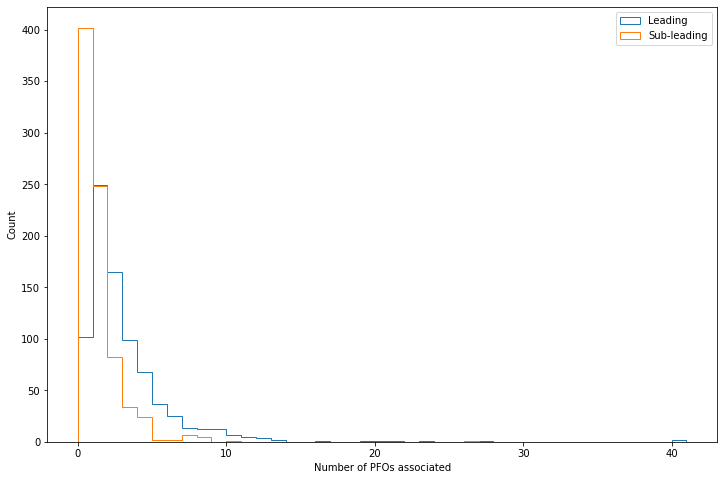

2185 leading PFOs, 758 sub-leading PFOs.
0 poorly reconstructed leading PFOs, 0 poorly reconstructed sub-leading PFOs.


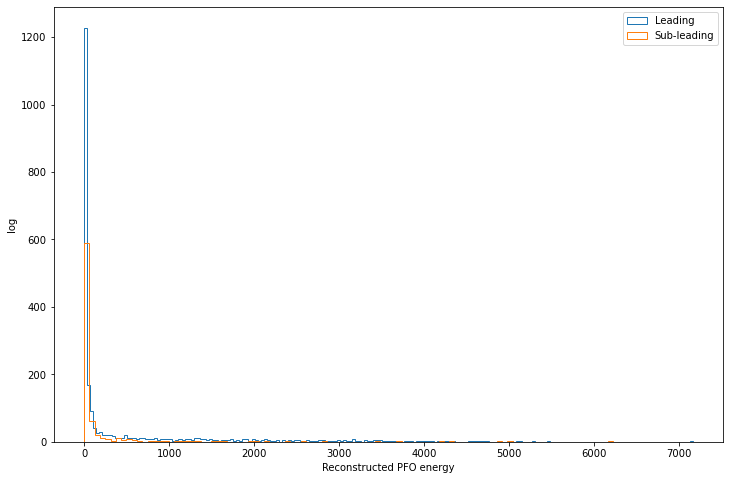

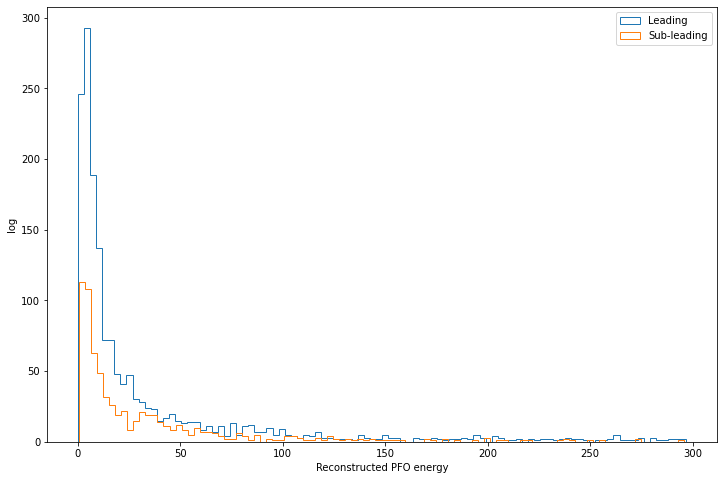

In [18]:
num_events = ak.num(evts.trueParticlesBT.mother, axis=0)

# This is only valid for the 1 pi0 in event, 2 photon decay cut
truth_ids_photon_beam = np.zeros((num_events, 2))

truth_num_pi0s = np.zeros(num_events)
truth_num_photons = np.zeros(num_events)
truth_num_pi0s_beam = np.zeros(num_events)
truth_num_photons_beam = np.zeros(num_events)

reco_bt_num_pi0s = np.zeros(num_events)
reco_bt_num_photons = np.zeros(num_events)
reco_bt_num_pi0s_beam = np.zeros(num_events)
reco_bt_num_photons_beam = np.zeros(num_events)

reco_photon_i = np.zeros(num_events)
reco_photon_ii = np.zeros(num_events)

reco_energies_i = [[]]*num_events
reco_energies_ii = [[]]*num_events

for i in range(num_events):
    truth_mothers = evts.trueParticles.mother[i].to_numpy()
    truth_ids = evts.trueParticles.number[i].to_numpy()
    truth_pdgs = evts.trueParticles.pdg[i].to_numpy()
    truth_energy = evts.trueParticles.energy[i].to_numpy()

    bt_ids = evts.trueParticlesBT.number[i].to_numpy()
    reco_ids = evts.recoParticles.number[i].to_numpy()
    reco_energies = evts.recoParticles.energy[i].to_numpy()

    if not (True in (evts.recoParticles.beam_number[i] == evts.recoParticles.number[i])):
        print(f"Problem with index {i}, beam particle not found in reco data.")
    # beam_index = np.where(evts.recoParticles.beam_number[i] == evts.recoParticles.number[i])[0]
    # print(beam_index)

    beam_mask = get_MC_truth_beam_mask(truth_mothers, truth_ids, beam_id=1)
    
    beam_pi_ids = np.unique(truth_ids[np.logical_and(truth_pdgs == 111, beam_mask)])
    beam_pi_photons_ids = truth_ids[np.logical_and(truth_pdgs == 22, beam_mask)]

    # Number of pi0s in an event (strictly an inefficient way, since this looks over all PFOs,
    # which is larger than the number of truth particles, yet the value could be obtained from purely true particles)
    truth_num_pi0s[i] = len(np.unique(truth_ids[truth_pdgs == 111]))
    truth_num_pi0s_beam[i] = len(beam_pi_ids)

    # Number of photons which are daughters of pi0s in an event
    truth_num_photons[i] = len(np.unique(truth_ids[truth_pdgs == 22]))
    truth_num_photons_beam[i] = len(beam_pi_photons_ids)
    sorted_energies = np.flip(np.argsort(truth_energy[np.logical_and(truth_pdgs == 22, beam_mask)]))
    truth_ids_photon_beam[i,:] = beam_pi_photons_ids[sorted_energies]

    # Number of pi0s in an event (strictly an inefficient way, since this looks over all PFOs,
    # which is larger than the number of truth particles, yet the value could be obtained from purely true particles)
    reco_bt_num_pi0s[i] = len(np.unique(reco_ids[ [ e in np.unique(truth_ids[truth_pdgs == 111]) for e in bt_ids ] ]))
    reco_bt_num_pi0s_beam[i] = len(np.unique(reco_ids[ [ e in beam_pi_ids for e in bt_ids ] ]))

    # Number of photons which are daughters of pi0s in an event
    reco_bt_num_photons[i] = len(np.unique(reco_ids[ [ e in np.unique(truth_ids[truth_pdgs == 22]) for e in bt_ids ] ]))
    reco_bt_num_photons_beam[i] = len(np.unique(reco_ids[ [ e in beam_pi_photons_ids for e in bt_ids ] ]))
    reco_photon_i[i] = np.sum(bt_ids == beam_pi_photons_ids[sorted_energies][0])
    reco_photon_ii[i] = np.sum(bt_ids == beam_pi_photons_ids[sorted_energies][-1])
    reco_energies_i[i] = ak.to_list(reco_energies[bt_ids == beam_pi_photons_ids[sorted_energies][0]])
    reco_energies_ii[i] = ak.to_list(reco_energies[bt_ids == beam_pi_photons_ids[sorted_energies][-1]])



    # # This confirms that my method matches Shyam's method
    # if len(reco_ids[ [ e in beam_pi_photons_ids for e in bt_ids ] ]) != np.sum(evts.trueParticlesBT.particleNumber[i] != -1):
    #     print(i)
    #     print(len(reco_ids[ [ e in beam_pi_photons_ids for e in bt_ids ] ]))
    #     print(np.sum(evts.trueParticlesBT.particleNumber[i] != -1))

print("Numbers of truth pi0s per event:")
print(np.unique(truth_num_pi0s, return_counts=True))
print("Of which from the beam:")
print(np.unique(truth_num_pi0s_beam, return_counts=True))

print("\nNumbers of truth photons per event:")
print(np.unique(truth_num_photons, return_counts=True))
print("Of which from the beam:")
print(np.unique(truth_num_photons_beam, return_counts=True))

print("\nNumbers of reco pi0s per event:")
print(np.unique(reco_bt_num_pi0s, return_counts=True))
print("Of which from the beam:")
print(np.unique(reco_bt_num_pi0s_beam, return_counts=True))

print("\nNumbers of reco photons per event:")
print(np.unique(reco_bt_num_photons, return_counts=True))
print("Of which from the beam:")
print(np.unique(reco_bt_num_photons_beam, return_counts=True))

plt.figure(figsize=(12,8))
plt.hist(reco_photon_i, label="Leading", histtype="step", bins=int(np.max(reco_photon_i)))
plt.hist(reco_photon_ii, label="Sub-leading", histtype="step", bins=int(np.max(reco_photon_ii)))
plt.xlabel("Number of PFOs associated")
plt.ylabel("Count")
plt.legend()
plt.show()

reco_energies_i = ak.ravel(ak.Array(reco_energies_i))
reco_energies_ii = ak.ravel(ak.Array(reco_energies_ii))

print(f"{len(reco_energies_i)} leading PFOs, {len(reco_energies_ii)} sub-leading PFOs.")
print(f"{len(reco_energies_i[reco_energies_i == -999.])} poorly reconstructed leading PFOs, {len(reco_energies_ii[reco_energies_ii == -999.])} poorly reconstructed sub-leading PFOs.")

plt.figure(figsize=(12,8))
plt.hist(reco_energies_i, label="Leading", histtype="step", bins=200)
plt.hist(reco_energies_ii, label="Sub-leading", histtype="step", bins=100)
plt.xlabel("Reconstructed PFO energy")
plt.ylabel("Count")
plt.ylabel("log")
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.hist(reco_energies_i[np.logical_and(reco_energies_i>= 0, reco_energies_i <= 300)], label="Leading", histtype="step", bins=100)
plt.hist(reco_energies_ii[np.logical_and(reco_energies_ii>= 0, reco_energies_ii <= 300)], label="Sub-leading", histtype="step", bins=100)
plt.xlabel("Reconstructed PFO energy")
plt.ylabel("Count/3MeV")
plt.ylabel("log")
plt.legend()
plt.show()

In [19]:
# def event_count_plot(all_nums, all_counts, beam_numbers, beam_counts, pdg_code = "111"):
#     plt.figure(figsize=(8,6))
#     plt.hist(all_nums, weights=all_counts, bins=int(np.max(all_nums)+1e-7), label="All", color="C1", histtype="step")
#     plt.hist(beam_numbers, weights=beam_counts, bins=int(np.max(beam_numbers)+1e-7), label="From beam only", color="C0", histtype="step")
#     plt.xlabel(f"Number of truth objects with pdg code {pdg_code}")
#     plt.ylabel("Count")
#     plt.tight_layout()
#     plt.legend()
#     plt.show()

# event_count_plot(*np.unique(truth_num_pi0s, return_counts=True), *np.unique(truth_num_pi0s_beam, return_counts=True), "111")

# event_count_plot(*np.unique(truth_num_photons, return_counts=True), *np.unique(truth_num_photons_beam, return_counts=True), "22")

In [15]:
def truth_pfos_in_two_photon_decay(events, sort=True):
    num_events = ak.num(events.trueParticlesBT.mother, axis=0)

    # This is only valid for the 1 pi0 in event, 2 photon decay cut
    photon_ids = np.zeros((num_events, 2))

    for i in range(num_events):
        truth_mothers = events.trueParticles.mother[i]
        truth_ids = events.trueParticles.number[i]
        truth_pdgs = events.trueParticles.pdg[i]
        truth_energy = events.trueParticles.energy[i].to_numpy()
        
        beam_mask = get_MC_truth_beam_mask(truth_mothers, truth_ids, beam_id=1)
        
        beam_photons_ids = truth_ids[(truth_pdgs == 22) & beam_mask]

        sorted_energies = np.flip(np.argsort(truth_energy[(truth_pdgs == 22) & beam_mask])) if sort else [0, 1]
        photon_ids[i,:] = beam_photons_ids[sorted_energies]
    
    return photon_ids


def get_best_pairs(events, truth_photon_ids_sorted, method='momentum', report=False, return_type="mask", verbosity=0, valid_mom_cut=False):
    # Work out the method of determining the best pair to use
    known_methods = {
        "momentum"      : "mom",
        "mom"           : "mom",
        "p"             : "mom",
        "e"             : "energy",
        "energy"        : "energy",
        "d"             : "dir",
        "dir"           : "dir",
        "direction"     : "dir",
        "purity"        : "purity",
        "completeness"  : "completeness",
        "comp"          : "completeness",
        "all"           : "all"
    }
    if not isinstance(method, list):
        method = [method]
    bad_methods = []
    for i, m in enumerate(method):
        try:
            method[i] = known_methods[m]
        except(KeyError):
            bad_methods += [m]
            print(f'Method(s) "{m}" not found, please use one of:\nmomentum, energy, direction, purity, completeness')
    if len(bad_methods) != 0:
        join_str = '", "'
        raise ValueError(f'Method(s): "{join_str.join(bad_methods)}"\nnot found, please use one of:\nmomentum, energy, direction, purity, completeness')

    # Parse which methods to use
    if "all" in method:
        methods_to_use = ["mom", "energy", "dir", "purity", "completeness"]
    else:
        methods_to_use = method


    # Work out the number of evnets we have
    num_events = ak.num(events.trueParticlesBT.number, axis=0)


    # Definitions of what each method involves
    #   - testing_methods: The test to be performed between the true and reco data to get the pair ordering
    #   - reco_props: The reco data of the candidate PFOs
    #   - truth_props: The truth data to be tested against

    testing_methods = {
        "mom": lambda reco, true: np.argsort([ vector.dot(r, true)[0] for r in reco ]), # This is want enforces looping 
        "dir": lambda reco, true: np.argsort([ vector.dot(r, true)[0] for r in reco ]), # per event at the moment
        "energy": lambda reco, true: np.argsort(reco),
        "purity": lambda reco, true: np.argsort(reco),
        "completeness": lambda reco, true: np.argsort(reco)
    }
    # TODO Swap to lambda functions for we don't fetch these unless we actually need them
    reco_props = {
        "mom": events.recoParticles.momentum,
        "dir": events.recoParticles.direction,
        "energy": events.recoParticles.energy,
        "purity": events.trueParticlesBT.matchedHits / events.trueParticlesBT.hitsInRecoCluster,
        "completeness": events.trueParticlesBT.sharedHits / events.trueParticlesBT.mcParticleHits
    }
    # TODO Change energy ... to use a smaller zeros/like (events.trueParticles.number ?)
    true_props = {
        "mom": events.trueParticles.momentum,
        "dir": events.trueParticles.direction,
        "energy": ak.zeros_like(events.trueParticles.number),
        "purity": ak.zeros_like(events.trueParticles.number),
        "completeness": ak.zeros_like(events.trueParticles.number)
    }

    # Other properties which must be set up ahead of the loop
    valid_event_mask = np.full(num_events, True, dtype=bool)

    truth_indicies_photon_beam = {}
    if return_type == "mask":
        for m in methods_to_use:
            truth_indicies_photon_beam.update({m : [[]] * num_events})
    else:
        # This is only valid for the 1 pi0 in event, 2 photon decay cut
        for m in methods_to_use:
            truth_indicies_photon_beam.update({m : np.zeros((num_events, 2), dtype=int)})

    zero_count = 0
    one_count = 0


    # Loop over each event to determine the best pair
    for i in range(num_events):
        bt_ids = events.trueParticlesBT.number[i]
        indicies = np.arange(len(bt_ids))

        true_ids = events.trueParticles.number[i]

        # Sorted ids should be supplied as an argument generated by truth_pfos_in_two_photon_decay(evts)
        photon_i, photon_ii = truth_photon_ids_sorted[i]


        if verbosity >= 1:
            true_momenta = events.trueParticles.momentum[i]
            if verbosity >= 2:
                print("\nTrue particle energies (GeV)")
                print(vector.magnitude(true_momenta[true_ids == photon_i ]))
                print(vector.magnitude(true_momenta[true_ids == photon_ii]))
                print("True particle directions")
                print(vector.normalize(true_momenta[true_ids == photon_i ]))
                print(vector.normalize(true_momenta[true_ids == photon_ii]))
            else:
                print(true_momenta[true_ids == photon_i ])
                print(true_momenta[true_ids == photon_ii])


        if valid_mom_cut:
            # Maybe want to look at what happens when we use purity/completeness with no good data cut?
            reco_momenta = events.recoParticles.momentum[i]
            good_data = np.logical_and(np.logical_and(reco_momenta.x != -999., reco_momenta.y != -999.), reco_momenta.z != -999.)
        else:
            good_data = slice(None)

        # Count how many events are cut with no photons/only one photon having at least one daughter
        photon_i_exists = photon_i in bt_ids[good_data]
        photon_ii_exists = photon_ii in bt_ids[good_data]
        if (not photon_i_exists) or (not photon_ii_exists):
            if not (photon_i_exists or photon_ii_exists):
                zero_count += 1
            else:
                one_count += 1
            valid_event_mask[i] = False
            continue # Skips to next iteration if not both phhotons have daughters

        for m in methods_to_use:
            # Get the data to use
            reco_prop = reco_props[m][i]
            true_prop = true_props[m][i]

            # Get the truth property of each photon
            true_prop_i  = true_prop[true_ids == photon_i ]
            true_prop_ii = true_prop[true_ids == photon_ii]

            # Get a mask indicating the daughters of each photon in the reco data
            photon_i_mask  = [ bt_ids[good_data] == photon_i  ][0]
            photon_ii_mask = [ bt_ids[good_data] == photon_ii ][0]
            # Need the [0] because bt_ids[good_data] == photon_i is an array, so returns an array (one element)


            # Order the PFOs by the selected method
            reco_prop_ordering_i  = testing_methods[m](reco_prop[ indicies[good_data][photon_i_mask ] ], true_prop_i )
            reco_prop_ordering_ii = testing_methods[m](reco_prop[ indicies[good_data][photon_ii_mask] ], true_prop_ii)

            # Returns the index of the PFO selected as the best selection for each photon
            photon_i_index  = indicies[good_data][photon_i_mask ][ reco_prop_ordering_i[-1]]
            photon_ii_index = indicies[good_data][photon_ii_mask][reco_prop_ordering_ii[-1]]


            if verbosity >= 6:
                print(f"List of reco values {m} with good data:")
                print(*reco_props[m][good_data])

            if verbosity >= 4:
                print(f"Values of {m}:")
                print("Leading photon")
                print(reco_props[indicies[good_data][photon_i_mask ]])
                print("Sub-leading photon")
                print(reco_props[indicies[good_data][photon_ii_mask]])

            if verbosity >= 5:
                print(f"Index ordering of {m} values")
                print("Leading photon")
                print(reco_prop_ordering_i)
                print("Sub-leading photon")
                print(reco_prop_ordering_ii)

            if verbosity >= 3:
                print(f"Selected {m}:")
                print("Leading photon")
                print(reco_prop[photon_i_index])
                print("Sub-leading photon")
                print(reco_prop[photon_ii_index])


            # If we are returning IDs, we need to find the corresponding reco ID
            if return_type == "id":
                reco_ids = events.recoParticles.number[i]
                truth_indicies_photon_beam[m][i,:] = [reco_ids[photon_i_index], reco_ids[photon_ii_index]]
            # If returning a mask we need to construct the mask
            elif return_type == "mask":
                event_mask = [False] * (indicies[-1] + 1)
                event_mask[photon_i_index] = True
                event_mask[photon_ii_index] = True
                truth_indicies_photon_beam[m][i] = event_mask
            # Otherwise, we just return the reco indicies of the selected PFOs
            else:
                truth_indicies_photon_beam[m][i,:] = [photon_i_index, photon_ii_index]
    

    if report:
        print(f"{zero_count} events discarded due to no true photons having matched PFOs.")
        print(f"{one_count} events discarded due to only one true photon having matched PFOs.")

    if return_type == "mask":
        truth_indicies_photon_beam = ak.Array(truth_indicies_photon_beam)

    if len(methods_to_use) == 1:
        return truth_indicies_photon_beam[method[0]], valid_event_mask
    else:
        return truth_indicies_photon_beam, valid_event_mask



0 count: 66
1 count: 372


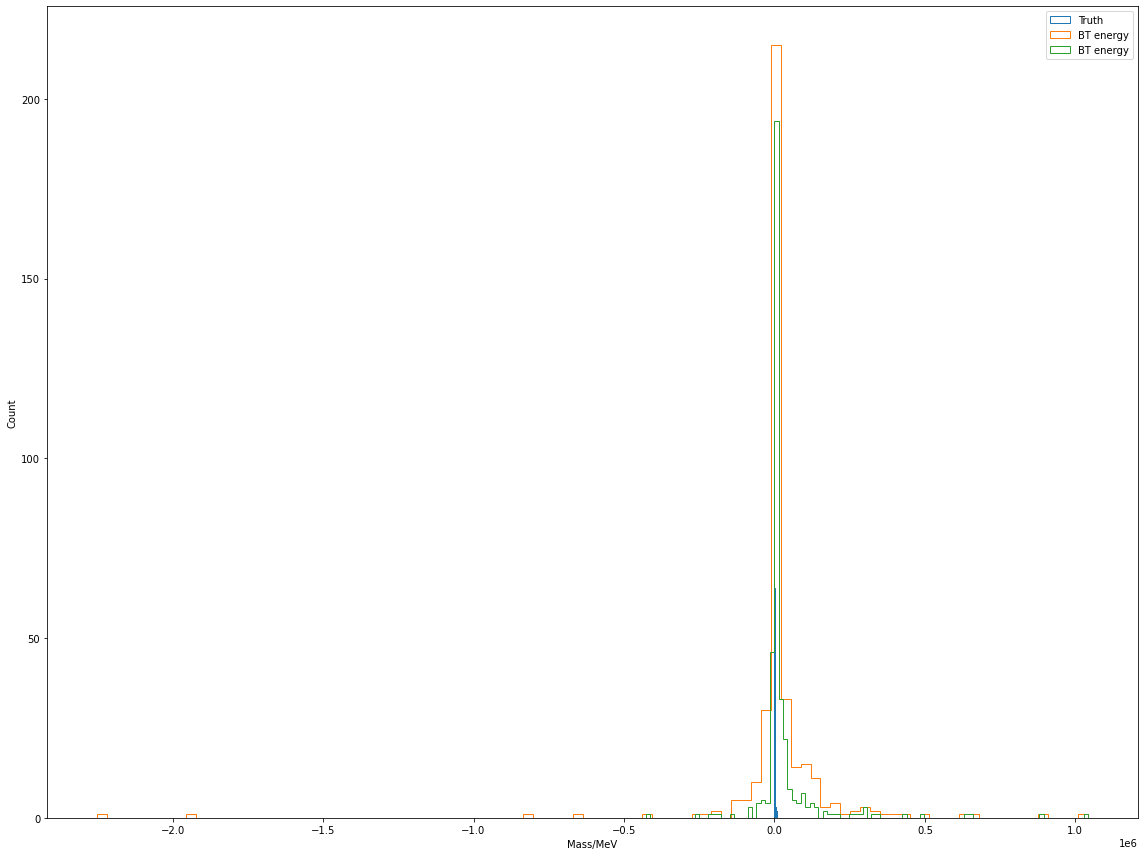

In [22]:
# Work out a single pair of initial "true" photons foe each event

num_events = ak.num(evts.trueParticlesBT.mother, axis=0)

true_mass = np.zeros(num_events)
bt_energy_mass = np.zeros(num_events)
reco_energy_mass = np.zeros(num_events)
bt_dir_mass = np.zeros(num_events)
reco_dir_mass = np.zeros(num_events)

err_y1_e_purity = np.zeros(num_events)
err_y2_e_purity = np.zeros(num_events)
err_y1_e_completeness = np.zeros(num_events)
err_y2_e_completeness = np.zeros(num_events)
err_y1_e_energy = np.zeros(num_events)
err_y2_e_energy = np.zeros(num_events)
err_y1_e_direction = np.zeros(num_events)
err_y2_e_direction = np.zeros(num_events)
err_y1_e_momentum = np.zeros(num_events)
err_y2_e_momentum = np.zeros(num_events)

err_y1_d_purity = np.zeros(num_events)
err_y2_d_purity = np.zeros(num_events)
err_y1_d_completeness = np.zeros(num_events)
err_y2_d_completeness = np.zeros(num_events)
err_y1_d_energy = np.zeros(num_events)
err_y2_d_energy = np.zeros(num_events)
err_y1_d_direction = np.zeros(num_events)
err_y2_d_direction = np.zeros(num_events)
err_y1_d_momentum = np.zeros(num_events)
err_y2_d_momentum = np.zeros(num_events)

valid_event_mask = np.full(num_events, True, dtype=bool)

pi0_mass = 139.6

zero_count = 0
one_count = 0

verbose=False

for i in range(num_events):
    reco_momenta = evts.recoParticles.momentum[i]
    # Use the reco results for invalid cases
    reco_energies = evts.recoParticles.energy[i]
    reco_dirs = evts.recoParticles.direction[i]

    good_data = np.logical_and(reco_energies != -999., reco_dirs.x != -999.)

    bt_ids = evts.trueParticlesBT.number[i].to_numpy()
    reco_ids = evts.recoParticles.number[i].to_numpy()
    indicies = np.arange(len(reco_momenta))

    true_ids = evts.trueParticles.number[i].to_numpy()
    true_momenta = evts.trueParticles.momentum[i]

    bt_purity = evts.trueParticlesBT.matchedHits[i].to_numpy() / evts.trueParticlesBT.hitsInRecoCluster[i].to_numpy()
    bt_completeness = evts.trueParticlesBT.sharedHits[i].to_numpy() / evts.trueParticlesBT.mcParticleHits[i].to_numpy()

    photon_i, photon_ii = truth_ids_photon_beam[i]
    photon_i_exists = photon_i in bt_ids[good_data]
    photon_ii_exists = photon_ii in bt_ids[good_data]
    if (not photon_i_exists) or (not photon_ii_exists):
        if not (photon_i_exists or photon_ii_exists):
            zero_count += 1
        else:
            one_count += 1
        valid_event_mask[i] = False
        continue

    true_photon_i = true_ids == photon_i
    true_photon_ii = true_ids == photon_ii

    true_mom_i = true_momenta[true_photon_i]
    true_mom_ii = true_momenta[true_photon_ii]

    if verbose:
        print("True particles")
        print(true_mom_i)
        print(true_mom_ii)
        print(vector.magnitude(true_mom_i) * 1000)
        print(vector.magnitude(true_mom_ii) * 1000)

    true_dir_i = vector.normalize(true_mom_i)
    true_dir_ii = vector.normalize(true_mom_ii)

    true_mass[i] = (vector.dot(true_mom_i, true_mom_ii))[0]


    photon_i_mask = [ bt_ids[good_data] == photon_i ][0]   # Don't actually know why the [0] is needed...
    photon_ii_mask = [ bt_ids[good_data] == photon_ii ][0]


    # Set highest purity as truth
    photon_i_purities = np.argsort(bt_purity[good_data][photon_i_mask])
    photon_ii_purities = np.argsort(bt_purity[good_data][photon_ii_mask])
    purity_i_index = indicies[good_data][photon_i_mask][photon_i_purities[-1]]
    purity_ii_index = indicies[good_data][photon_ii_mask][photon_ii_purities[-1]]


    # Set highest completeness as truth
    photon_i_completeness = np.argsort(bt_completeness[good_data][photon_i_mask])
    photon_ii_completeness = np.argsort(bt_completeness[good_data][photon_ii_mask])
    completeness_i_index = indicies[good_data][photon_i_mask][photon_i_completeness[-1]]
    completeness_ii_index = indicies[good_data][photon_ii_mask][photon_ii_completeness[-1]]


    # set highest energy as truth
    photon_i_energies = np.argsort(reco_energies[good_data][photon_i_mask])
    photon_ii_energies = np.argsort(reco_energies[good_data][photon_ii_mask])

    energy_i_index = indicies[good_data][photon_i_mask][photon_i_energies[-1]]
    energy_ii_index = indicies[good_data][photon_ii_mask][photon_ii_energies[-1]]
    

    # Set closest in direction as truth
    photon_i_dirs = reco_dirs[indicies[good_data][photon_i_mask]]
    photon_ii_dirs = reco_dirs[indicies[good_data][photon_ii_mask]]

    dir_diff_i = np.argsort([ vector.dot(d, true_dir_i)[0] for d in photon_i_dirs ])
    dir_diff_ii = np.argsort([ vector.dot(d, true_dir_ii)[0] for d in photon_ii_dirs ])

    dir_i_index = indicies[good_data][photon_i_mask][dir_diff_i[-1]]
    dir_ii_index = indicies[good_data][photon_ii_mask][dir_diff_ii[-1]]


    # Set largest projetion of momentum along true momentum as truth
    mom_proj_i = np.argsort([ vector.dot(d, true_mom_i)[0] for d in reco_momenta[indicies[good_data][photon_i_mask]] ])
    mom_proj_ii = np.argsort([ vector.dot(d, true_mom_ii)[0] for d in reco_momenta[indicies[good_data][photon_ii_mask]] ])

    mom_i_index = indicies[good_data][photon_i_mask][mom_proj_i[-1]]
    mom_ii_index = indicies[good_data][photon_ii_mask][mom_proj_ii[-1]]

    if verbose:
        print("Reco stuff:")
        print("Purity")
        print(bt_purity[indicies[good_data][photon_i_mask]])
        print(bt_purity[indicies[good_data][photon_ii_mask]])
        print("Completeness")
        print(bt_completeness[indicies[good_data][photon_i_mask]])
        print(bt_completeness[indicies[good_data][photon_ii_mask]])
        print("Energies")
        print(reco_energies[indicies[good_data][photon_i_mask]])
        print(reco_energies[indicies[good_data][photon_ii_mask]])
        print("Directions")
        print(*reco_dirs[indicies[good_data][photon_i_mask]])
        print(*reco_dirs[indicies[good_data][photon_ii_mask]])
        print("Directions dot product")
        print([ vector.dot(d, true_dir_i)[0] for d in photon_i_dirs ])
        print([ vector.dot(d, true_dir_ii)[0] for d in photon_ii_dirs ])
    # if np.max([ vector.dot(d, true_dir_i)[0] for d in photon_i_dirs ]) < -0.9:
    #     print(f"Strange directions in index {i} for photon 1:")
    #     print([ vector.dot(d, true_dir_i)[0] for d in photon_i_dirs ])
    # if np.max([ vector.dot(d, true_dir_ii)[0] for d in photon_ii_dirs ]) < 0 and len(photon_ii_dirs) > 1:
    #     print(f"Strange directions in index {i} for photon 2:")
    #     print([ vector.dot(d, true_dir_ii)[0] for d in photon_ii_dirs ])


    # if dir_i_index != energy_i_index:
    #     print(f"Direction and energies {dir_i_index}, {energy_i_index} for photon 1 do not match at index {i}")
    # if dir_ii_index != energy_ii_index:
    #     print(f"Direction and energies {dir_ii_index}, {energy_ii_index} for photon 2 do not match at index {i}")

    # print(reco_energies[photon_i_mask])
    # print(reco_energies[energy_i_index])
    # print(reco_dirs[energy_i_index])
    # print(vector.prod(reco_energies[energy_i_index], reco_dirs[energy_i_index]))
    # print(vector.dot(vector.prod(reco_energies[energy_i_index], reco_dirs[energy_i_index]), vector.prod(reco_energies[energy_ii_index], reco_dirs[energy_ii_index])))
    # print(vector.dot(reco_dirs[energy_i_index], reco_dirs[energy_ii_index]) * reco_energies[energy_i_index] * reco_energies[energy_ii_index])
    # print(vector.dot(vector.prod(reco_energies[dir_i_index], reco_dirs[dir_i_index]), vector.prod(reco_energies[dir_ii_index], reco_dirs[dir_ii_index])))
    # print(vector.dot(reco_dirs[dir_i_index], reco_dirs[dir_ii_index]) * reco_energies[dir_i_index] * reco_energies[dir_ii_index])

    reco_energy_mass[i] = vector.dot(reco_momenta[energy_i_index], reco_momenta[energy_ii_index])

    reco_dir_mass[i] = vector.dot(reco_momenta[dir_i_index], reco_momenta[dir_ii_index])
    
    err_y1_e_purity[i] = (reco_energies[purity_i_index] / 1000*vector.magnitude(true_mom_i)[0]) -1
    err_y2_e_purity[i] = (reco_energies[purity_ii_index] / 1000*vector.magnitude(true_mom_ii)[0]) -1
    err_y1_e_completeness[i] = (reco_energies[completeness_i_index] / 1000*vector.magnitude(true_mom_i)[0]) -1
    err_y2_e_completeness[i] = (reco_energies[completeness_ii_index] / 1000*vector.magnitude(true_mom_ii)[0]) -1
    err_y1_e_energy[i] = (reco_energies[energy_i_index] / 1000*vector.magnitude(true_mom_i)[0]) -1
    err_y2_e_energy[i] = (reco_energies[energy_ii_index] / 1000*vector.magnitude(true_mom_ii)[0]) -1
    err_y1_e_direction[i] = (reco_energies[dir_i_index] / 1000*vector.magnitude(true_mom_i)[0]) -1
    err_y2_e_direction[i] = (reco_energies[dir_ii_index] / 1000*vector.magnitude(true_mom_ii)[0]) -1
    err_y1_e_momentum[i] = (reco_energies[mom_i_index] / 1000*vector.magnitude(true_mom_i)[0]) -1
    err_y2_e_momentum[i] = (reco_energies[mom_ii_index] / 1000*vector.magnitude(true_mom_ii)[0]) -1

    err_y1_d_purity[i] = vector.dot(reco_dirs[purity_i_index], true_dir_i[0])
    err_y2_d_purity[i] = vector.dot(reco_dirs[purity_ii_index], true_dir_ii[0])
    err_y1_d_completeness[i] = vector.dot(reco_dirs[completeness_i_index], true_dir_i[0])
    err_y2_d_completeness[i] = vector.dot(reco_dirs[completeness_ii_index], true_dir_ii[0])
    err_y1_d_energy[i] = vector.dot(reco_dirs[energy_i_index], true_dir_i[0])
    err_y2_d_energy[i] = vector.dot(reco_dirs[energy_ii_index], true_dir_ii[0])
    err_y1_d_direction[i] = vector.dot(reco_dirs[dir_i_index], true_dir_i[0])
    err_y2_d_direction[i] = vector.dot(reco_dirs[dir_ii_index], true_dir_ii[0])
    err_y1_d_momentum[i] = vector.dot(reco_dirs[mom_i_index], true_dir_i[0])
    err_y2_d_momentum[i] = vector.dot(reco_dirs[mom_ii_index], true_dir_ii[0])

    if verbose:
        print("Reco data:")
        print(*reco_momenta[good_data])
        print(*reco_energies[good_data])
        print("Purity data:")
        print(reco_momenta[purity_i_index])
        print(reco_momenta[purity_ii_index])
        print("Completeness data:")
        print(reco_momenta[completeness_i_index])
        print(reco_momenta[completeness_ii_index])
        print("Energy data:")
        print(reco_momenta[energy_i_index])
        print(reco_momenta[energy_ii_index])
        print("Direction data:")
        print(reco_momenta[dir_i_index])
        print(reco_momenta[dir_ii_index])
        print("Masses:")
        print(reco_energy_mass[i])
        print(reco_dir_mass[i])
        print()

print(f"0 count: {zero_count}")
print(f"1 count: {one_count}")

plt.figure(figsize=(16,12))
plt.hist(true_mass[valid_event_mask]*1e3, label="Truth", histtype="step", bins=100)
plt.hist(reco_energy_mass[valid_event_mask], label="BT energy", histtype="step", bins=100)
plt.hist(reco_dir_mass[valid_event_mask], label="BT energy", histtype="step", bins=100)
plt.xlabel("Mass/MeV")
plt.ylabel("Count")
plt.tight_layout()
plt.legend()
plt.show()


In [16]:
def make_truth_comparison_plots(events, photon_indicies, valid_events, prop_label=None, save_dir=None):
    # TODO Ideally, we can use the trueParticle (not trueparticleBT} data, since trueParticle stuff has alreayd bene loaded, but trueParticleBT hasn't been
    true_energies = events.trueParticlesBT.energy[valid_events] * 1000
    # true_energies_mom = vector.magnitude(events.trueParticlesBT.momentum)[valid_events] * 1000
    true_dirs = events.trueParticlesBT.direction[valid_events]

    reco_energies = events.recoParticles.energy[valid_events]
    reco_dirs = events.recoParticles.direction[valid_events]


    if not isinstance(photon_indicies, dict):
        photon_indicies = {prop_label:photon_indicies}
        
    
    fig_e_i, energy_i_axis    = plt.subplots(figsize=(16,12), layout="tight")
    fig_e_ii, energy_ii_axis  = plt.subplots(figsize=(16,12), layout="tight")
    fig_dirs, directions_axis = plt.subplots(figsize=(16,12), layout="tight")

    fig_e_i_log, energy_i_axis_log    = plt.subplots(figsize=(16,12), layout="tight")
    fig_e_ii_log, energy_ii_axis_log  = plt.subplots(figsize=(16,12), layout="tight")
    fig_dirs_log, directions_axis_log = plt.subplots(figsize=(16,12), layout="tight")


    for i, prop in enumerate(list(photon_indicies.keys())):
        if isinstance(prop, str):
            y1_label = "y1 " + prop
            y2_label = "y2 " + prop
        else:
            y1_label = None
            y2_label = None

        photon_i_indicies  = np_to_ak_indicies(photon_indicies[prop][:,0][valid_events])
        photon_ii_indicies = np_to_ak_indicies(photon_indicies[prop][:,1][valid_events])
        

        # err_true_photon_i = np.zeros(np.sum(valid_events))
        # photon_i_ids = events.trueParticlesBT.number[valid_events][photon_i_indicies]
        # reco_energy_full = reco_energies[photon_i_indicies]
        # index = np.arange(photon_indicies[prop][:,0].shape[0])[valid_events]
        # for j in range(np.sum(valid_events)):
        #     true_ids = events.trueParticles.number[index[j]].to_numpy()
        #     true_energy = events.trueParticles.energy[index[j]].to_numpy() * 1000
            
        #     true_energy_i = true_energy[true_ids == photon_i_ids[j]]
        #     # true_energy_ii = true_energy[true_ids == pfo_truth_ids[photon_ii_indicies]]
        #     err_true_photon_i[j] = (reco_energy_full[j] / true_energy_i )[0] -1


        err_energy_photon_i  = (reco_energies[photon_i_indicies ] / true_energies[photon_i_indicies ]) -1
        err_energy_photon_ii = (reco_energies[photon_ii_indicies] / true_energies[photon_ii_indicies]) -1
    
        err_direction_photon_i  = vector.dot(reco_dirs[photon_i_indicies ], true_dirs[photon_i_indicies ])
        err_direction_photon_ii = vector.dot(reco_dirs[photon_ii_indicies], true_dirs[photon_ii_indicies])

        # Linear
        energy_i_axis.hist( err_energy_photon_i,  label=y1_label, histtype="step", bins=100)
        # energy_i_axis.hist( err_true_photon_i,  label=y1_label, histtype="step", bins=100)
        energy_ii_axis.hist(err_energy_photon_ii, label=y2_label, histtype="step", bins=100)

        directions_axis.hist(err_direction_photon_i,  label=y1_label, histtype="step", bins=80, color=f"C{i}")
        directions_axis.hist(err_direction_photon_ii, label=y2_label, histtype="step", bins=80, color=f"C{i}", ls="--")

        # Log
        energy_i_axis_log.hist( err_energy_photon_i,  label=y1_label, histtype="step", bins=100)
        # energy_i_axis_log.hist( err_true_photon_i,  label=y1_label, histtype="step", bins=100)
        energy_ii_axis_log.hist(err_energy_photon_ii, label=y2_label, histtype="step", bins=100)

        directions_axis_log.hist(err_direction_photon_i,  label=y1_label, histtype="step", bins=50, color=f"C{i}")
        directions_axis_log.hist(err_direction_photon_ii, label=y2_label, histtype="step", bins=50, color=f"C{i}", ls="--")

    # Linear
    energy_i_axis.set_xlabel("Fractional energy error")
    energy_i_axis.set_ylabel("Count")
    energy_i_axis.legend()

    energy_ii_axis.set_xlabel("Fractional energy error")
    energy_ii_axis.set_ylabel("Count")
    energy_ii_axis.legend()

    directions_axis.set_xlabel("Best photon vs. truth dot product")
    directions_axis.set_ylabel("Count")
    directions_axis.legend(loc="upper left")

    # Log
    energy_i_axis_log.set_xlabel("Fractional energy error")
    energy_i_axis_log.set_ylabel("Count")
    energy_i_axis_log.set_yscale("log")
    energy_i_axis_log.legend()

    energy_ii_axis_log.set_xlabel("Fractional energy error")
    energy_ii_axis_log.set_ylabel("Count")
    energy_i_axis_log.set_yscale("log")
    energy_ii_axis_log.legend()

    directions_axis_log.set_xlabel("Best photon vs. truth dot product")
    directions_axis_log.set_ylabel("Count")
    energy_i_axis_log.set_yscale("log")
    directions_axis_log.legend(loc="upper left")

    if save_dir is not None:
        fig_e_i.savefig(save_dir + "/leading_photon_energy.png")
        fig_e_ii.savefig(save_dir + "/subleading_photon_energy.png")
        fig_dirs.savefig(save_dir + "/directions.png")
        fig_e_i_log.savefig(save_dir + "/leading_photon_energy_log.png")
        fig_e_ii_log.savefig(save_dir + "/subleading_photon_energy_log.png")
        fig_dirs_log.savefig(save_dir + "/directions_log.png")

    plt.show()
    
    return


In [16]:
truth_pair_indicies, valid_events = get_best_pairs(evts, truth_pfos_in_two_photon_decay(evts), method="mom", return_type="mask", report=True)

127 events discarded due to no true photons having matched PFOs.
445 events discarded due to only one true photon having matched PFOs.


/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to _RecoPairData__beam_number.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to _RecoPairData__beamVertex.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to run.
  warnings.warn(f"C

Beam slice done in 5.106446981430054s
['Beam slice', 7489, 9.268564356435643, 808]
144 events discarded due to no true photons having matched PFOs.
490 events discarded due to only one true photon having matched PFOs.


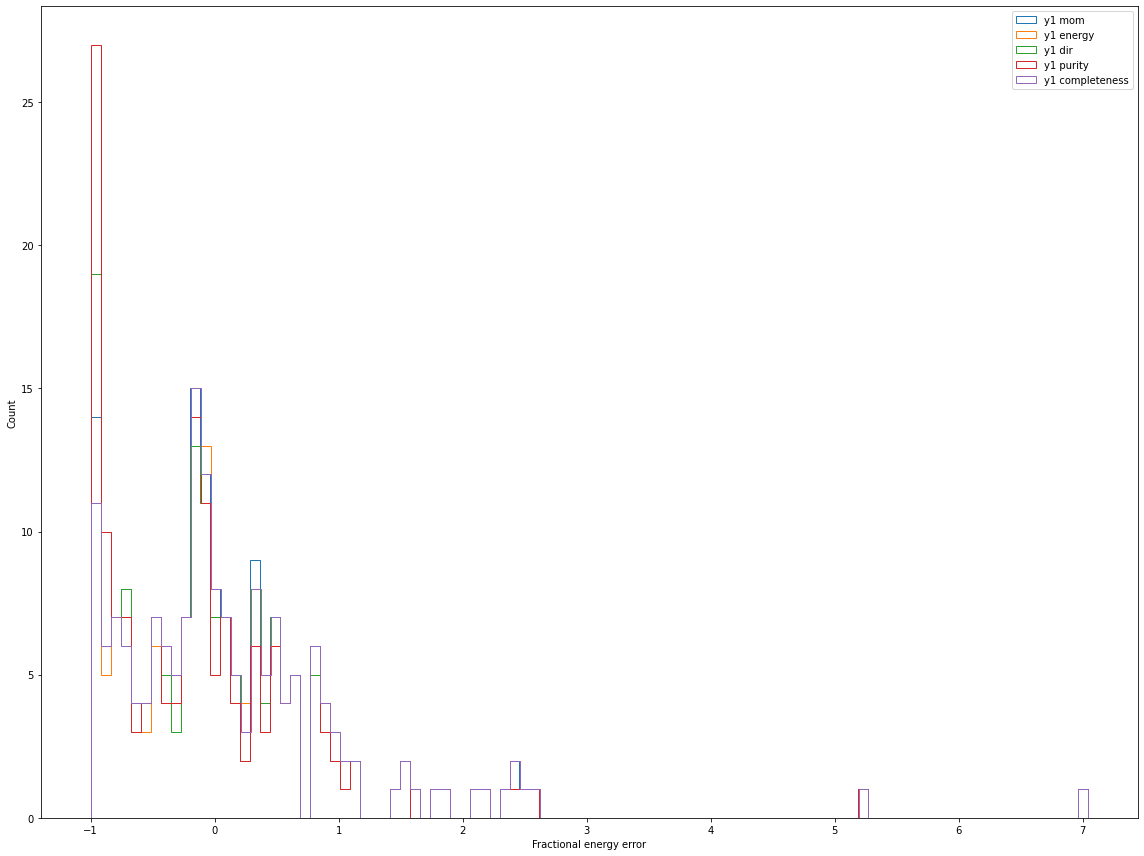

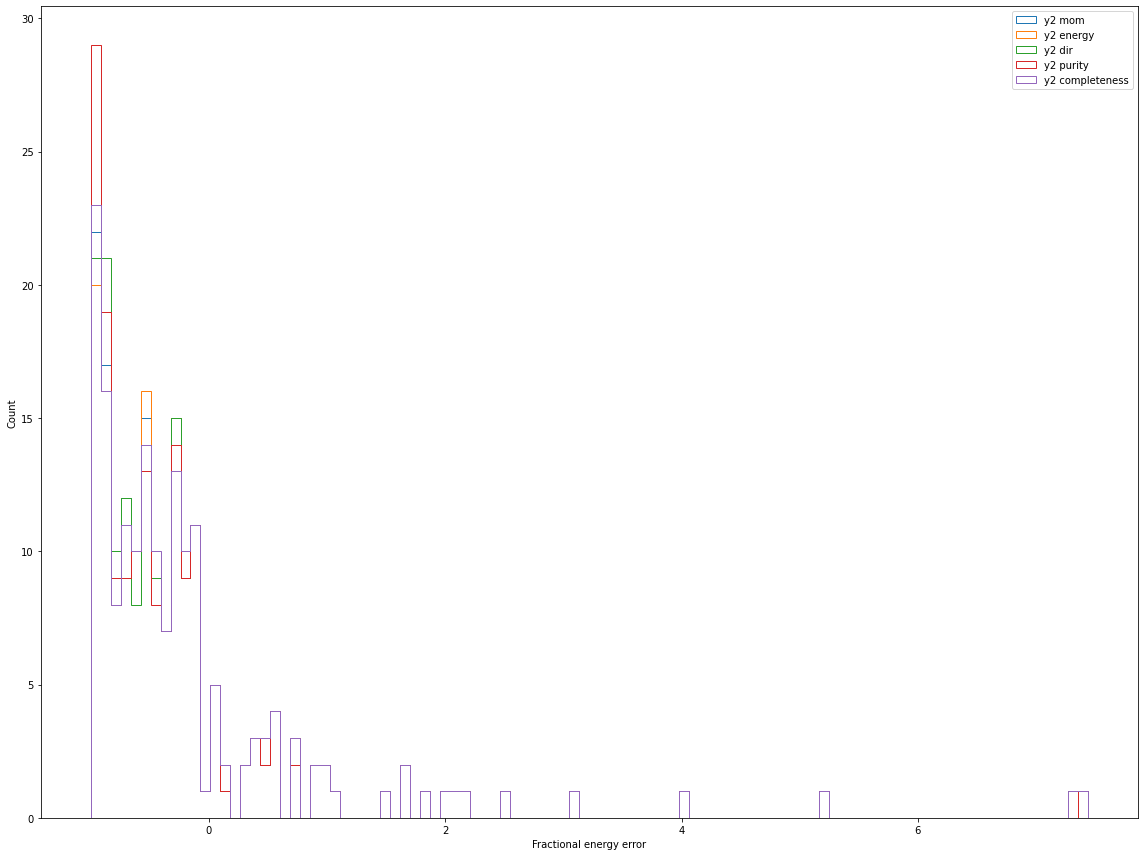

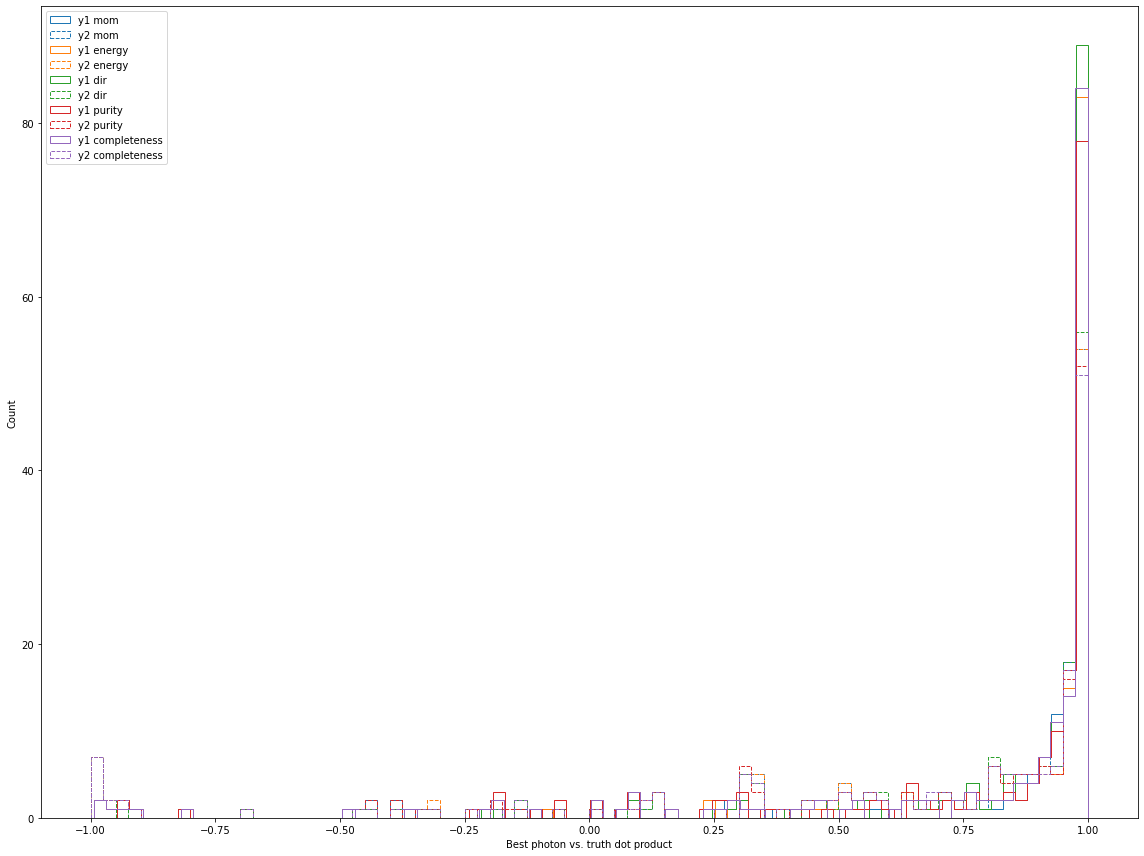

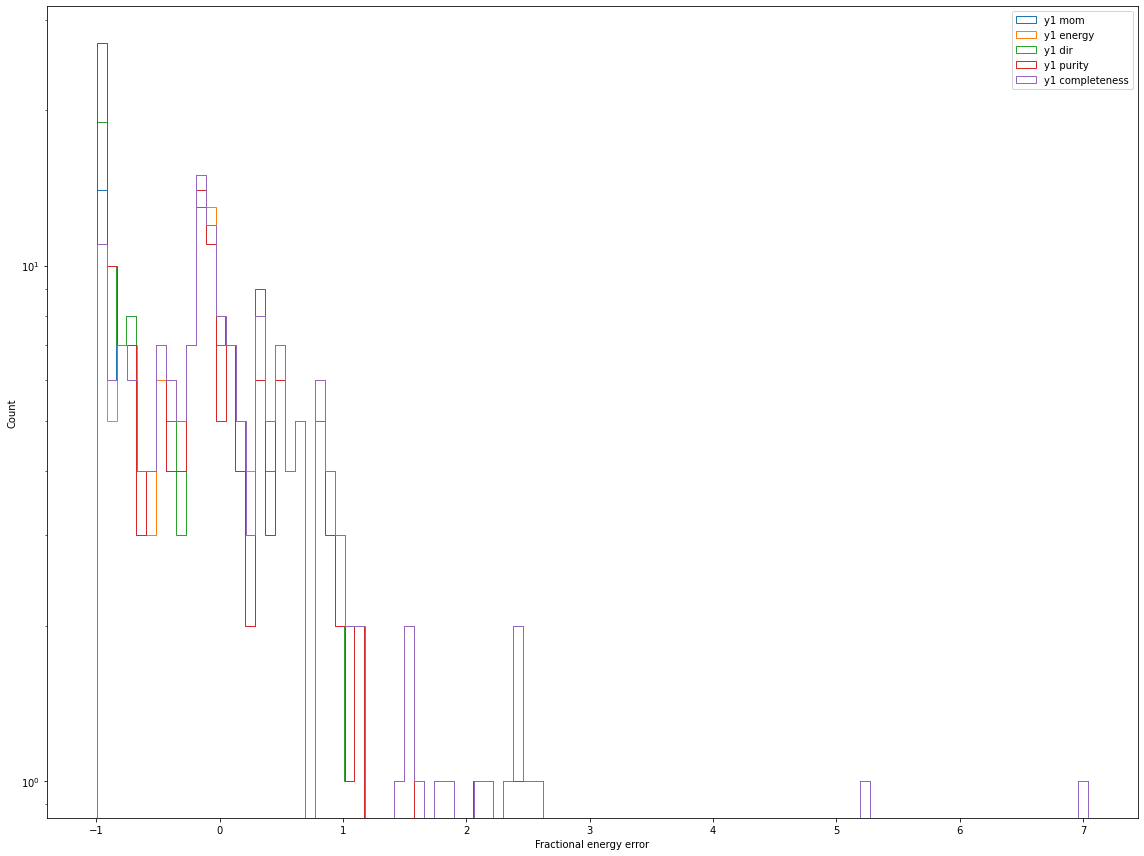

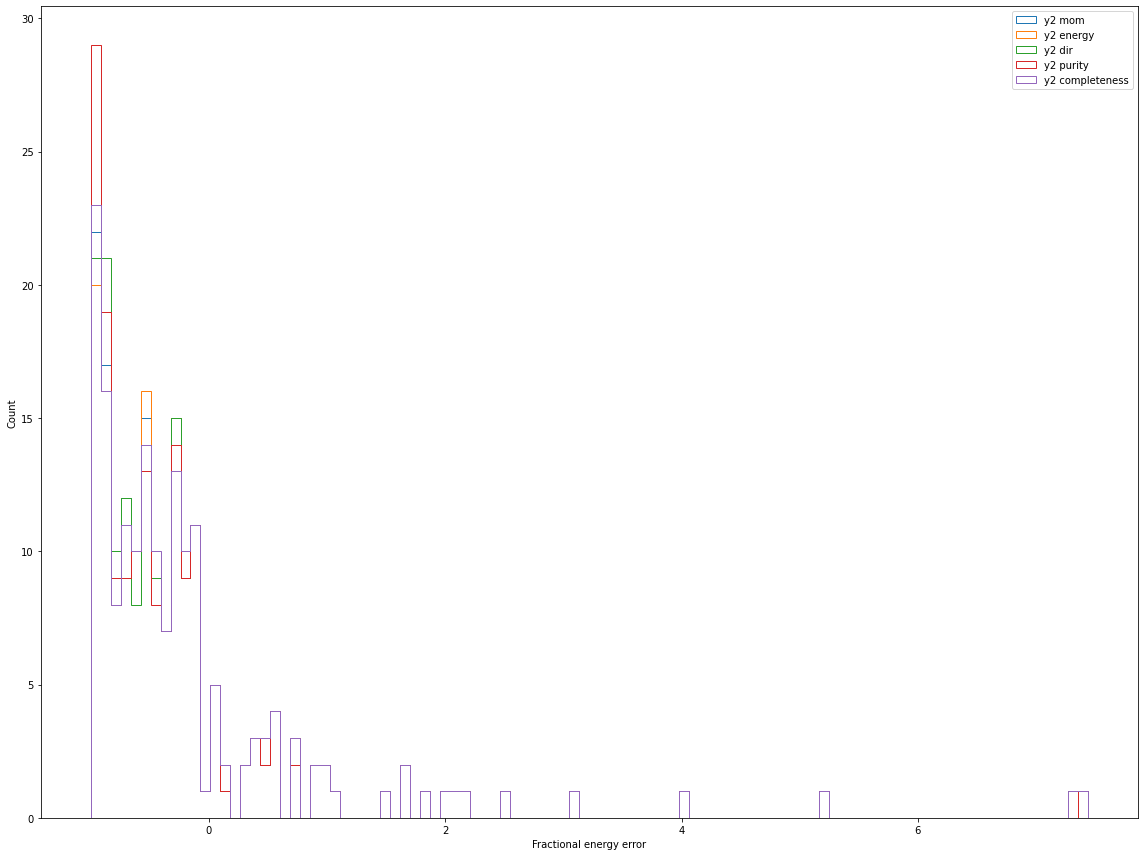

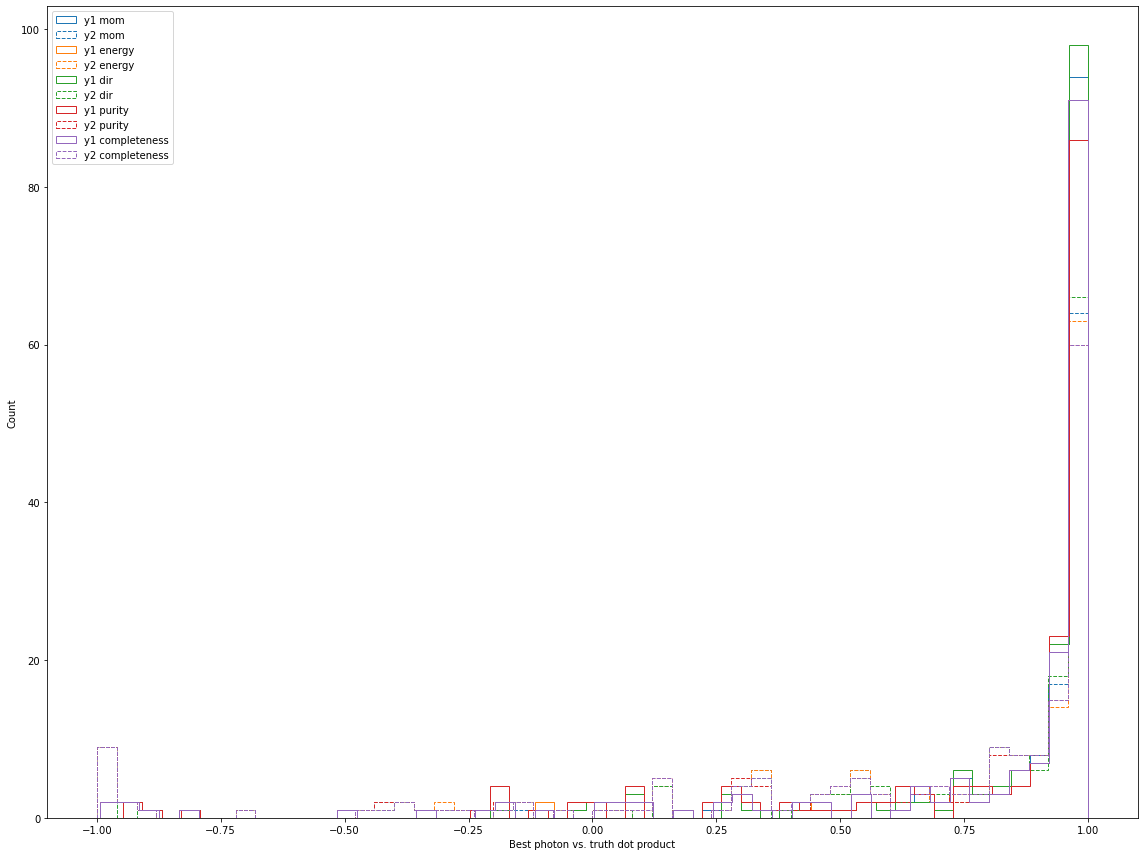

In [44]:
# slice_mask = [[]] * ak.num(evts.recoParticles.beam_number, axis=0)

# ts = time.time()

# for i in range(ak.num(slice_mask, axis=0)):
#     slices = evts.recoParticles.slice_id[i]
#     beam_slice = slices[evts.recoParticles.number[i] == evts.recoParticles.beam_number[i]]

#     slice_mask[i] = list(slices == beam_slice)
    

# slice_mask = ak.Array(slice_mask)

# evts.Filter([slice_mask], [])
# print(f"Beam slice done in {time.time()  - ts}s")
# evt_remaining = ak.count(evts.eventNum)
# print(["Beam slice", ak.count(evts.trueParticlesBT.pdg), ak.count(evts.trueParticlesBT.pdg)/evt_remaining, evt_remaining])

# pairs_dict, valid_evts = get_best_pairs(evts, truth_pfos_in_two_photon_decay(evts), method="all", return_type="index")

# make_truth_comparison_plots(evts, pairs_dict, valid_evts, save_dir="/storage/wx21978/pi0/plots/truth_choice_methods_beam_slice/")

/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to _RecoPairData__beam_number.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to _RecoPairData__beamVertex.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to run.
  warnings.warn(f"C

CNNScore > 0.36 done in 5.301350116729736s
['CNNScore > 0.36', 3632, 4.4950495049504955, 808]
152 events discarded due to no true photons having matched PFOs.
491 events discarded due to only one true photon having matched PFOs.


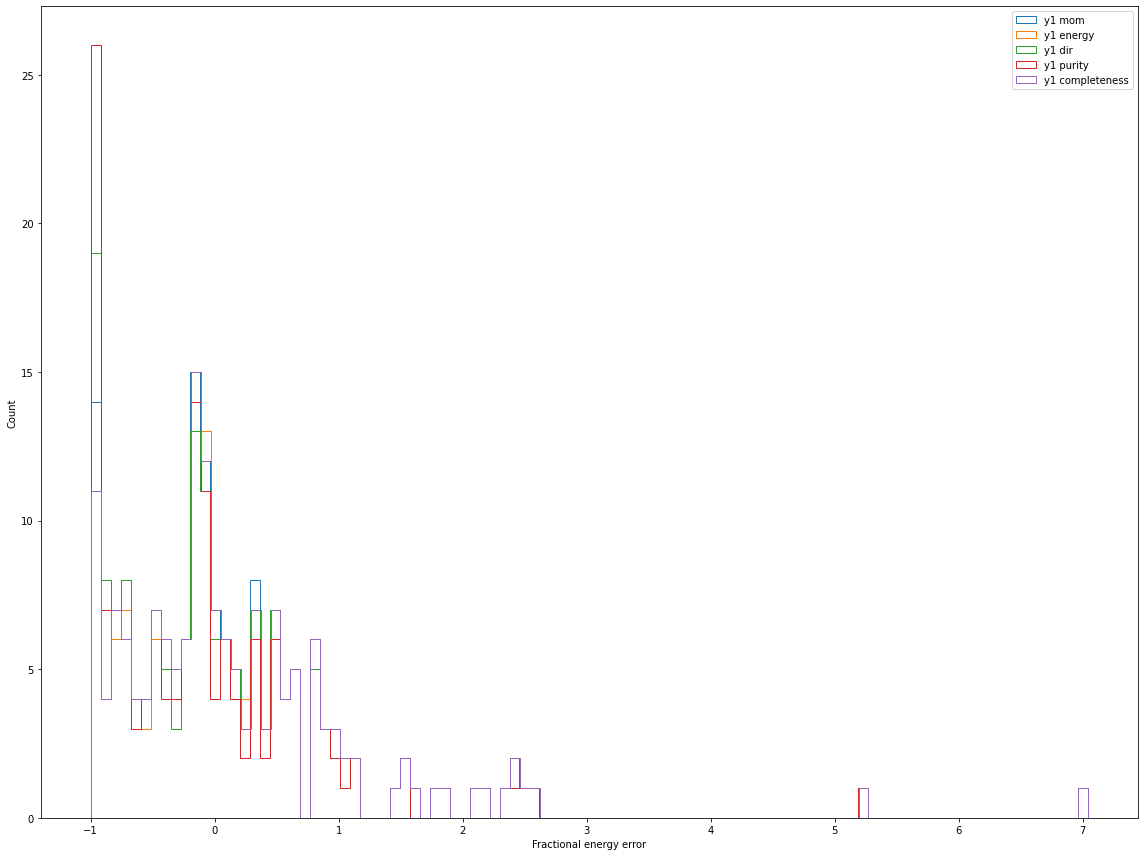

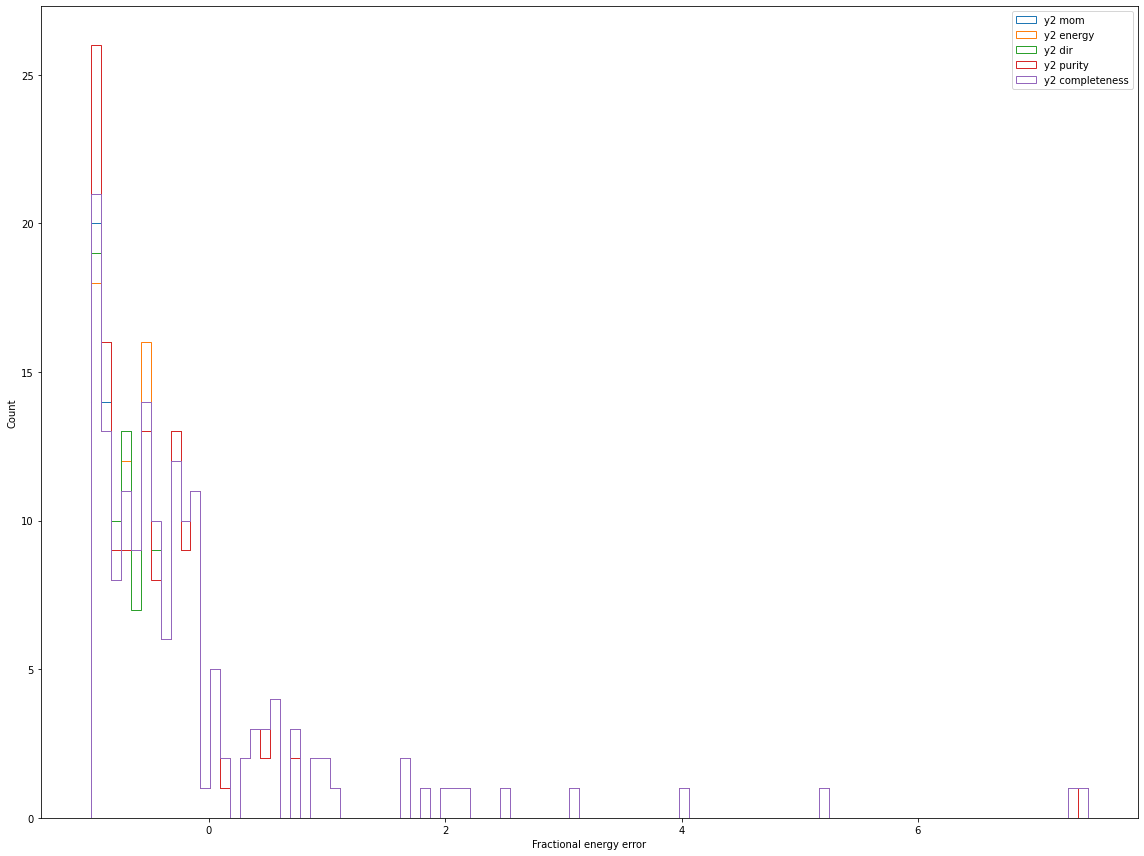

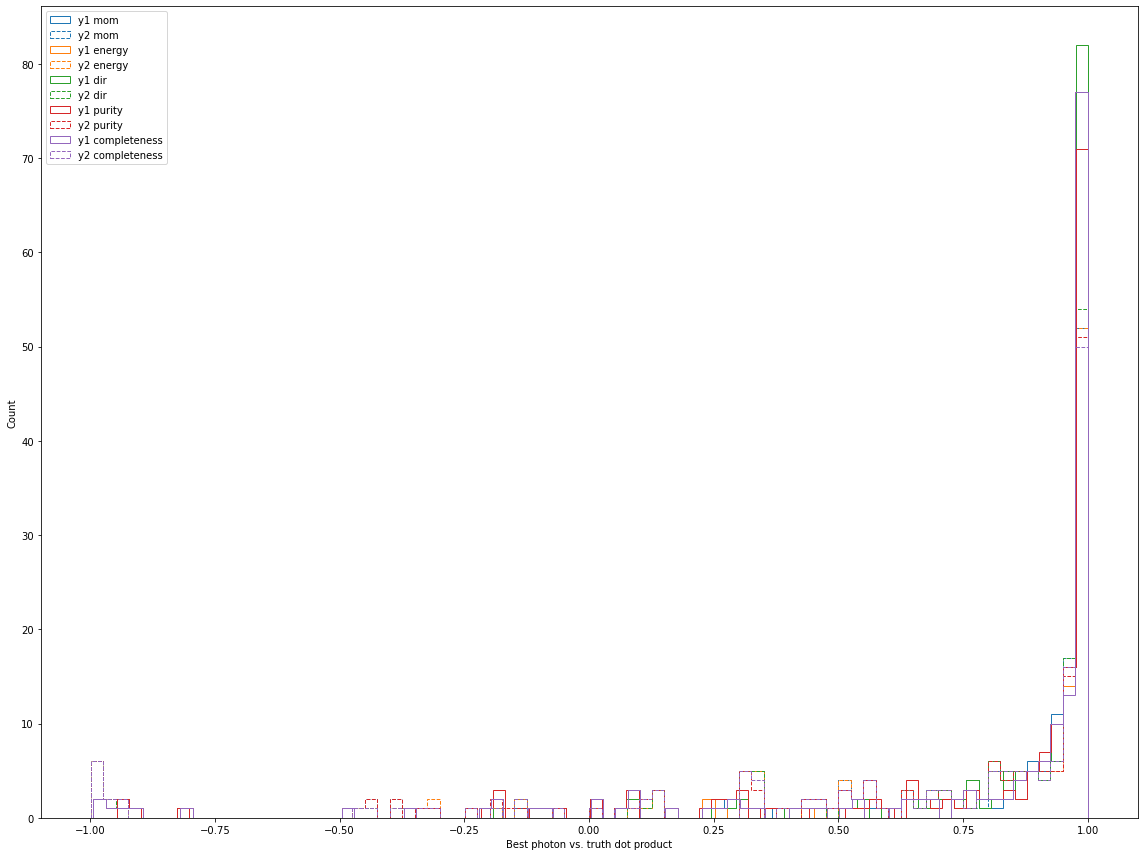

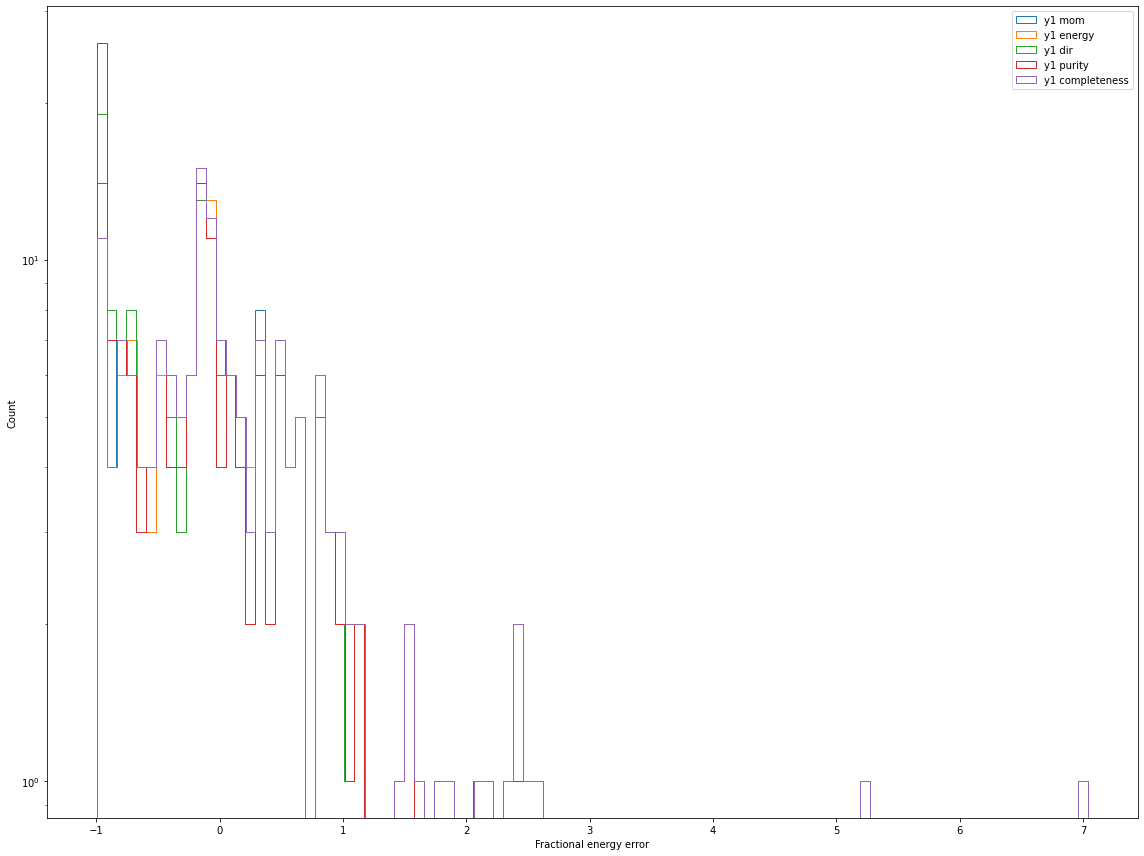

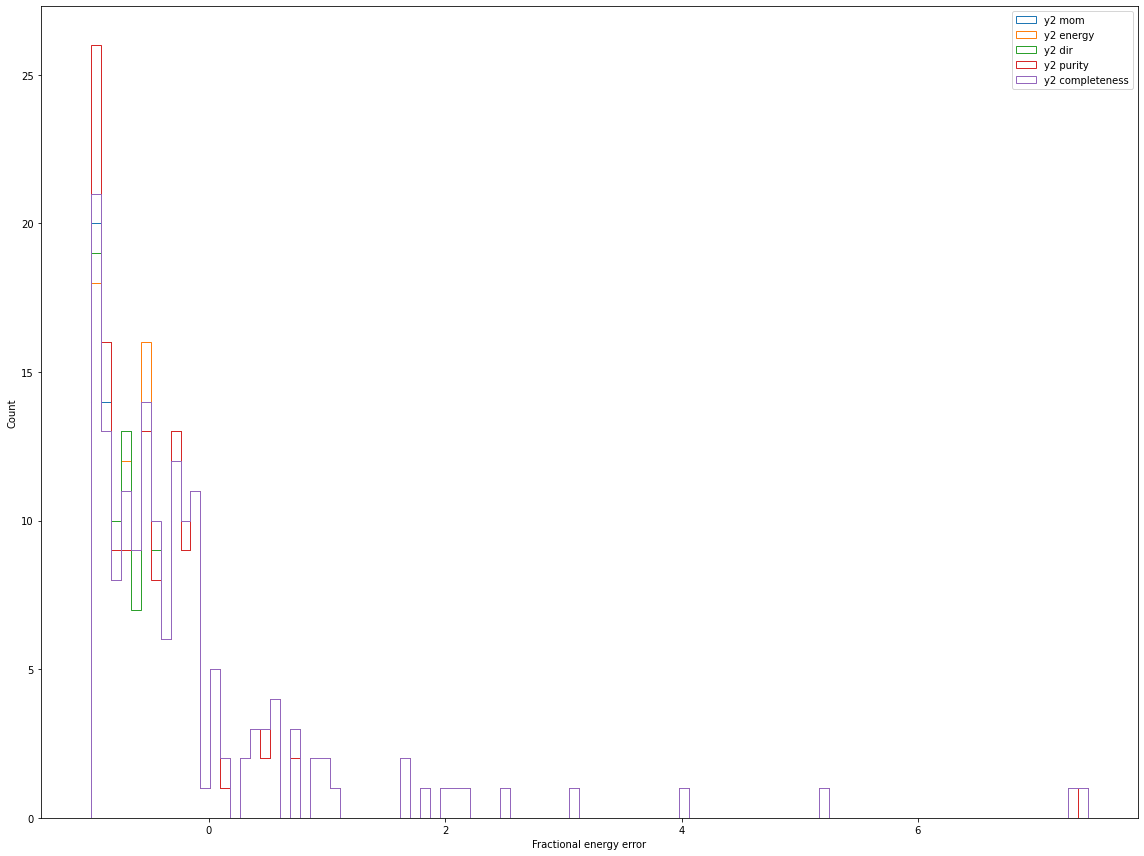

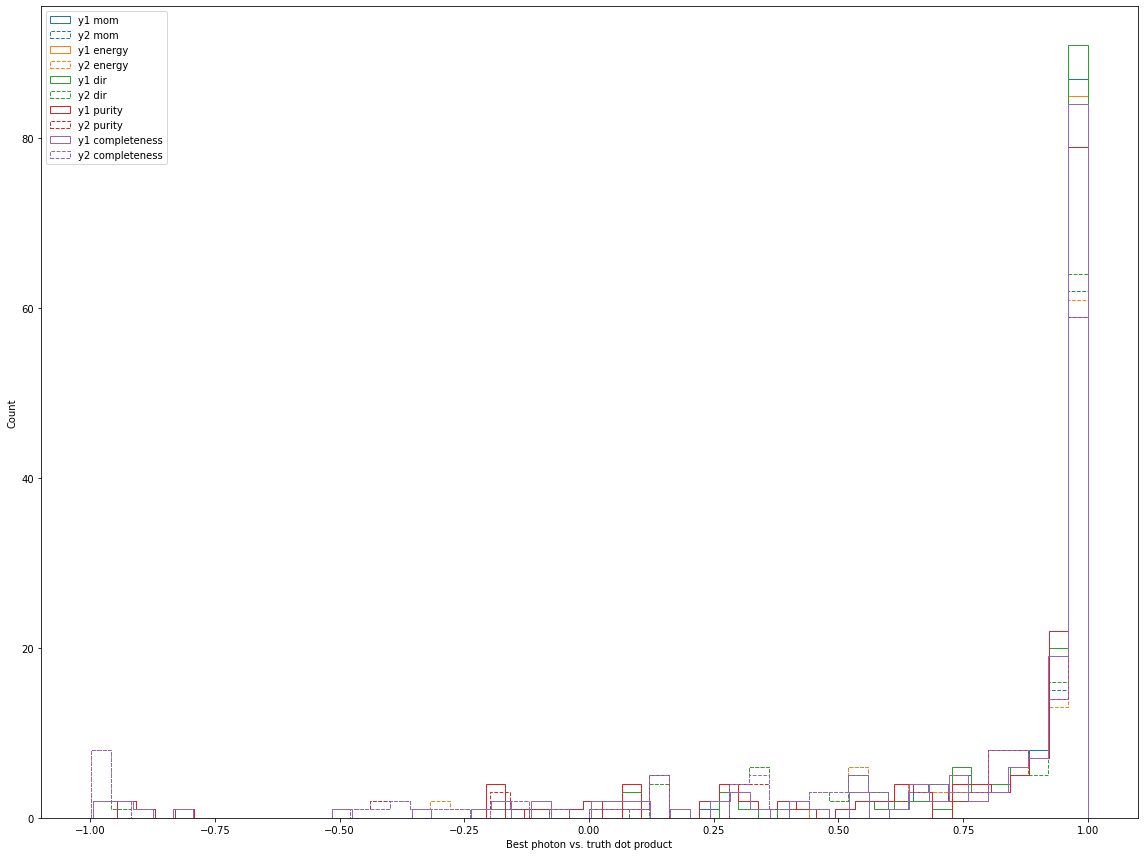

In [45]:
# cnn_cut = 0.36
# ts = time.time()
# evts.Filter([evts.recoParticles.cnnScore > cnn_cut], [])
# del_prop(evts.recoParticles, "cnnScore")
# print(f"CNNScore > 0.36 done in {time.time()  - ts}s")
# evt_remaining = ak.count(evts.eventNum)
# print([f"CNNScore > {cnn_cut}", ak.count(evts.trueParticlesBT.pdg), ak.count(evts.trueParticlesBT.pdg)/evt_remaining, evt_remaining])

# truth_indicies = truth_pfos_in_two_photon_decay(evts)

# pairs_dict, valid_evts = get_best_pairs(evts, truth_indicies, method="all", return_type="index")

# make_truth_comparison_plots(evts, pairs_dict, valid_evts, save_dir="/storage/wx21978/pi0/plots/truth_choice_methods_cnn_score0-36/")

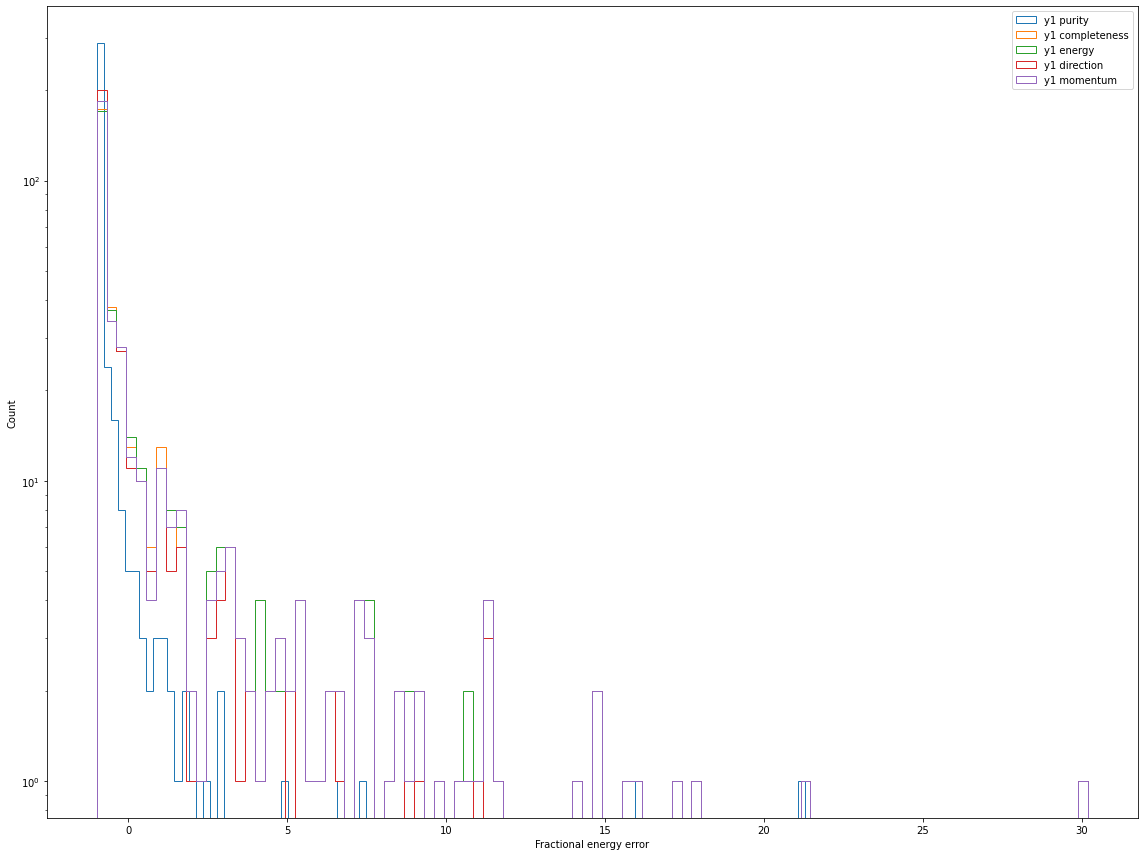

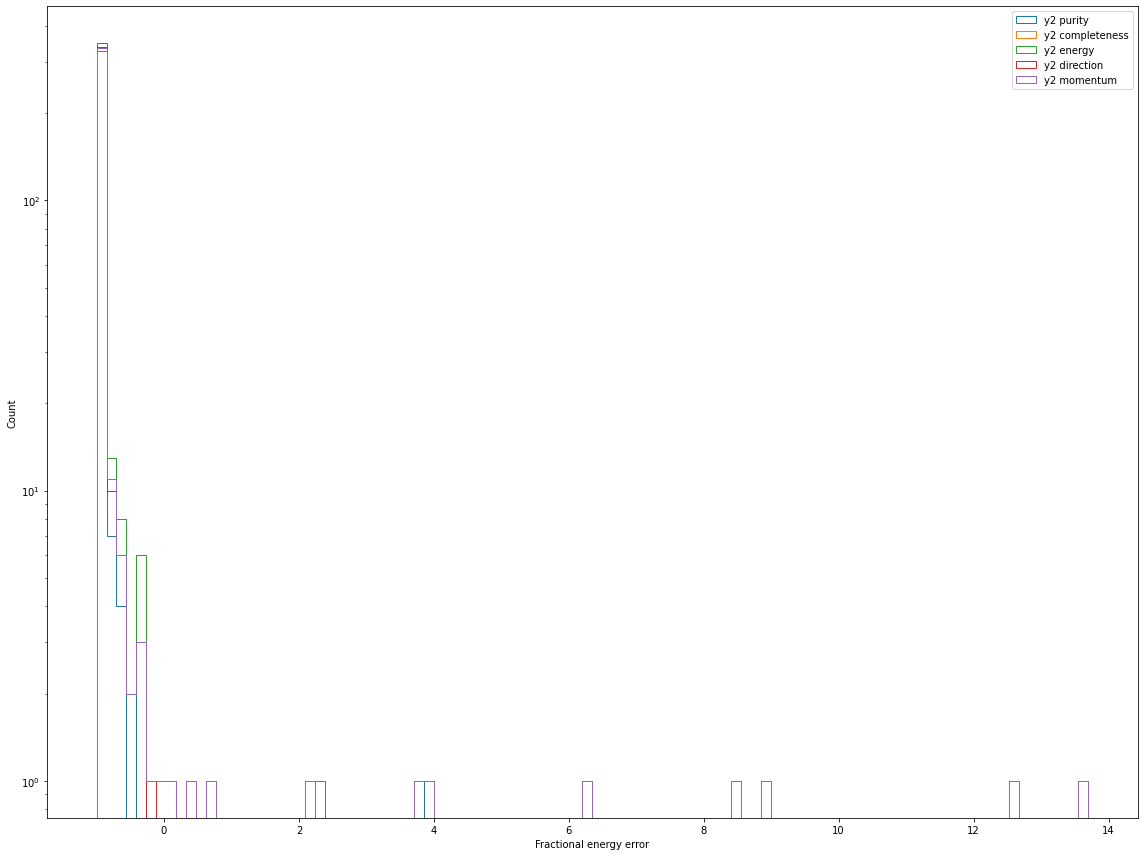

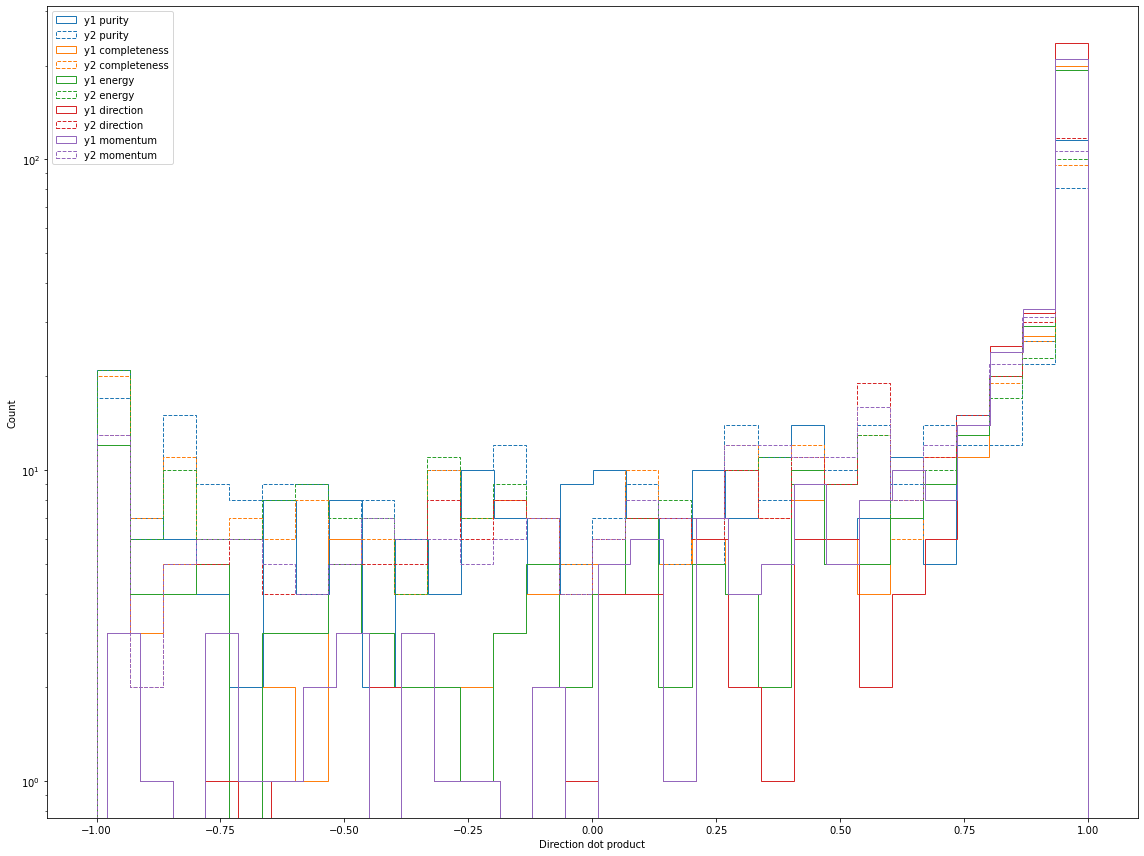

In [28]:
plt.figure(figsize=(16,12))
plt.hist(err_y1_e_purity[valid_event_mask], label="y1 purity", histtype="step", bins=100)
# plt.hist(err_y2_e_purity[valid_event_mask], label="y2 purity", histtype="step", bins=100)
plt.hist(err_y1_e_completeness[valid_event_mask], label="y1 completeness", histtype="step", bins=100)
# plt.hist(err_y2_e_completeness[valid_event_mask], label="y2 completeness", histtype="step", bins=100)
plt.hist(err_y1_e_energy[valid_event_mask], label="y1 energy", histtype="step", bins=100)
# plt.hist(err_y2_e_energy[valid_event_mask], label="y2 energy", histtype="step", bins=100)
plt.hist(err_y1_e_direction[valid_event_mask], label="y1 direction", histtype="step", bins=100)
# plt.hist(err_y2_e_direction[valid_event_mask], label="y2 direction", histtype="step", bins=100)
plt.hist(err_y1_e_momentum[valid_event_mask], label="y1 momentum", histtype="step", bins=100)
# plt.hist(err_y2_e_momentum[valid_event_mask], label="y2 momentum", histtype="step", bins=100)
plt.xlabel("Fractional energy error")
plt.ylabel("Count")
plt.yscale('log')
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
# plt.hist(err_y1_e_purity[valid_event_mask], label="y1 purity", histtype="step", bins=100)
plt.hist(err_y2_e_purity[valid_event_mask], label="y2 purity", histtype="step", bins=100)
# plt.hist(err_y1_e_completeness[valid_event_mask], label="y1 completeness", histtype="step", bins=100)
plt.hist(err_y2_e_completeness[valid_event_mask], label="y2 completeness", histtype="step", bins=100)
# plt.hist(err_y1_e_energy[valid_event_mask], label="y1 energy", histtype="step", bins=100)
plt.hist(err_y2_e_energy[valid_event_mask], label="y2 energy", histtype="step", bins=100)
# plt.hist(err_y1_e_direction[valid_event_mask], label="y1 direction", histtype="step", bins=100)
plt.hist(err_y2_e_direction[valid_event_mask], label="y2 direction", histtype="step", bins=100)
# plt.hist(err_y1_e_momentum[valid_event_mask], label="y1 momentum", histtype="step", bins=100)
plt.hist(err_y2_e_momentum[valid_event_mask], label="y2 momentum", histtype="step", bins=100)
plt.xlabel("Fractional energy error")
plt.ylabel("Count")
plt.yscale('log')
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
plt.hist(err_y1_d_purity[valid_event_mask], label="y1 purity", histtype="step", bins=30, color="C0")
plt.hist(err_y2_d_purity[valid_event_mask], label="y2 purity", histtype="step", bins=30, color="C0", ls="--")
plt.hist(err_y1_d_completeness[valid_event_mask], label="y1 completeness", histtype="step", bins=30, color="C1")
plt.hist(err_y2_d_completeness[valid_event_mask], label="y2 completeness", histtype="step", bins=30, color="C1", ls="--")
plt.hist(err_y1_d_energy[valid_event_mask], label="y1 energy", histtype="step", bins=30, color="C2")
plt.hist(err_y2_d_energy[valid_event_mask], label="y2 energy", histtype="step", bins=30, color="C2", ls="--")
plt.hist(err_y1_d_direction[valid_event_mask], label="y1 direction", histtype="step", bins=30, color="C3")
plt.hist(err_y2_d_direction[valid_event_mask], label="y2 direction", histtype="step", bins=30, color="C3", ls="--")
plt.hist(err_y1_d_momentum[valid_event_mask], label="y1 momentum", histtype="step", bins=30, color="C4")
plt.hist(err_y2_d_momentum[valid_event_mask], label="y2 momentum", histtype="step", bins=30, color="C4", ls="--")
plt.xlabel("Direction dot product")
plt.ylabel("Count")
plt.yscale('log')
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Cut PFOs based on slice and CNNScore

cnn_mask = ak.full_like(evts.recoParticles.cnnScore, True, dtype=bool)
slice_mask = ak.full_like(evts.recoParticles.slice_id, True, dtype=bool)
joint_mask = ak.full_like(evts.recoParticles.slice_id, True, dtype=bool)

cnn_cut = 0.36
pi0_mass = 139.6

zero_count = 0
one_count = 0

purity_cut = 0
completeness_cut = 0
energy_cut = 0
direction_cut = 0
momentum_cut = 0

verbose=False

for i in range(num_events):
    cnn_scores = evts.recoParticles.cnnScore[i]
    slices = evts.recoParticles.slice_id[i]
    beam_slice = slices[evts.recoParticles.number[i] == evts.recoParticles.beam_number[i]]

    event_inidicies = np.arange(len(slices))

    cnn_mask = cnn_scores >= cnn_cut
    slice_mask = slices == beam_slice

    bt_ids = evts.trueParticlesBT.number[i].to_numpy()
    reco_ids = evts.recoParticles.number[i].to_numpy()
    indicies = np.arange(len(reco_momenta))

    true_ids = evts.trueParticles.number[i].to_numpy()
    true_momenta = evts.trueParticles.momentum[i]

    bt_purity = evts.trueParticlesBT.matchedHits[i].to_numpy() / evts.trueParticlesBT.hitsInRecoCluster[i].to_numpy()
    bt_completeness = evts.trueParticlesBT.sharedHits[i].to_numpy() / evts.trueParticlesBT.mcParticleHits[i].to_numpy()

    photon_i, photon_ii = truth_ids_photon_beam[i]
    photon_i_exists = photon_i in bt_ids[good_data]
    photon_ii_exists = photon_ii in bt_ids[good_data]
    if (not photon_i_exists) or (not photon_ii_exists):
        if not (photon_i_exists or photon_ii_exists):
            zero_count += 1
        else:
            one_count += 1
        valid_event_mask[i] = False
        continue

    true_photon_i = true_ids == photon_i
    true_photon_ii = true_ids == photon_ii

    true_mom_i = true_momenta[true_photon_i]
    true_mom_ii = true_momenta[true_photon_ii]

    if verbose:
        print("True particles")
        print(true_mom_i)
        print(true_mom_ii)
        print(vector.magnitude(true_mom_i) * 1000)
        print(vector.magnitude(true_mom_ii) * 1000)

    true_dir_i = vector.normalize(true_mom_i)
    true_dir_ii = vector.normalize(true_mom_ii)

    true_mass[i] = (vector.dot(true_mom_i, true_mom_ii))[0]


    photon_i_mask = [ bt_ids[good_data] == photon_i ][0]   # Don't actually know why the [0] is needed...
    photon_ii_mask = [ bt_ids[good_data] == photon_ii ][0]


    # Set highest purity as truth
    photon_i_purities = np.argsort(bt_purity[good_data][photon_i_mask])
    photon_ii_purities = np.argsort(bt_purity[good_data][photon_ii_mask])
    purity_i_index = indicies[good_data][photon_i_mask][photon_i_purities[-1]]
    purity_ii_index = indicies[good_data][photon_ii_mask][photon_ii_purities[-1]]


    # Set highest completeness as truth
    photon_i_completeness = np.argsort(bt_completeness[good_data][photon_i_mask])
    photon_ii_completeness = np.argsort(bt_completeness[good_data][photon_ii_mask])
    completeness_i_index = indicies[good_data][photon_i_mask][photon_i_completeness[-1]]
    completeness_ii_index = indicies[good_data][photon_ii_mask][photon_ii_completeness[-1]]


    # set highest energy as truth
    photon_i_energies = np.argsort(reco_energies[good_data][photon_i_mask])
    photon_ii_energies = np.argsort(reco_energies[good_data][photon_ii_mask])

    energy_i_index = indicies[good_data][photon_i_mask][photon_i_energies[-1]]
    energy_ii_index = indicies[good_data][photon_ii_mask][photon_ii_energies[-1]]
    

    # Set closest in direction as truth
    photon_i_dirs = reco_dirs[indicies[good_data][photon_i_mask]]
    photon_ii_dirs = reco_dirs[indicies[good_data][photon_ii_mask]]

    dir_diff_i = np.argsort([ vector.dot(d, true_dir_i)[0] for d in photon_i_dirs ])
    dir_diff_ii = np.argsort([ vector.dot(d, true_dir_ii)[0] for d in photon_ii_dirs ])

    dir_i_index = indicies[good_data][photon_i_mask][dir_diff_i[-1]]
    dir_ii_index = indicies[good_data][photon_ii_mask][dir_diff_ii[-1]]


    # Set largest projetion of momentum along true momentum as truth
    mom_proj_i = np.argsort([ vector.dot(d, true_mom_i)[0] for d in reco_momenta[indicies[good_data][photon_i_mask]] ])
    mom_proj_ii = np.argsort([ vector.dot(d, true_mom_ii)[0] for d in reco_momenta[indicies[good_data][photon_ii_mask]] ])

    mom_i_index = indicies[good_data][photon_i_mask][mom_proj_i[-1]]
    mom_ii_index = indicies[good_data][photon_ii_mask][mom_proj_ii[-1]]

    if verbose:
        print("Reco stuff:")
        print("Purity")
        print(bt_purity[indicies[good_data][photon_i_mask]])
        print(bt_purity[indicies[good_data][photon_ii_mask]])
        print("Completeness")
        print(bt_completeness[indicies[good_data][photon_i_mask]])
        print(bt_completeness[indicies[good_data][photon_ii_mask]])
        print("Energies")
        print(reco_energies[indicies[good_data][photon_i_mask]])
        print(reco_energies[indicies[good_data][photon_ii_mask]])
        print("Directions")
        print(*reco_dirs[indicies[good_data][photon_i_mask]])
        print(*reco_dirs[indicies[good_data][photon_ii_mask]])
        print("Directions dot product")
        print([ vector.dot(d, true_dir_i)[0] for d in photon_i_dirs ])
        print([ vector.dot(d, true_dir_ii)[0] for d in photon_ii_dirs ])
    # if np.max([ vector.dot(d, true_dir_i)[0] for d in photon_i_dirs ]) < -0.9:
    #     print(f"Strange directions in index {i} for photon 1:")
    #     print([ vector.dot(d, true_dir_i)[0] for d in photon_i_dirs ])
    # if np.max([ vector.dot(d, true_dir_ii)[0] for d in photon_ii_dirs ]) < 0 and len(photon_ii_dirs) > 1:
    #     print(f"Strange directions in index {i} for photon 2:")
    #     print([ vector.dot(d, true_dir_ii)[0] for d in photon_ii_dirs ])


    # if dir_i_index != energy_i_index:
    #     print(f"Direction and energies {dir_i_index}, {energy_i_index} for photon 1 do not match at index {i}")
    # if dir_ii_index != energy_ii_index:
    #     print(f"Direction and energies {dir_ii_index}, {energy_ii_index} for photon 2 do not match at index {i}")

    # print(reco_energies[photon_i_mask])
    # print(reco_energies[energy_i_index])
    # print(reco_dirs[energy_i_index])
    # print(vector.prod(reco_energies[energy_i_index], reco_dirs[energy_i_index]))
    # print(vector.dot(vector.prod(reco_energies[energy_i_index], reco_dirs[energy_i_index]), vector.prod(reco_energies[energy_ii_index], reco_dirs[energy_ii_index])))
    # print(vector.dot(reco_dirs[energy_i_index], reco_dirs[energy_ii_index]) * reco_energies[energy_i_index] * reco_energies[energy_ii_index])
    # print(vector.dot(vector.prod(reco_energies[dir_i_index], reco_dirs[dir_i_index]), vector.prod(reco_energies[dir_ii_index], reco_dirs[dir_ii_index])))
    # print(vector.dot(reco_dirs[dir_i_index], reco_dirs[dir_ii_index]) * reco_energies[dir_i_index] * reco_energies[dir_ii_index])

    reco_energy_mass[i] = vector.dot(reco_momenta[energy_i_index], reco_momenta[energy_ii_index])

    reco_dir_mass[i] = vector.dot(reco_momenta[dir_i_index], reco_momenta[dir_ii_index])
    
    err_y1_e_purity[i] = (reco_energies[purity_i_index] / 1000*vector.magnitude(true_mom_i)[0]) -1
    err_y2_e_purity[i] = (reco_energies[purity_ii_index] / 1000*vector.magnitude(true_mom_ii)[0]) -1
    err_y1_e_completeness[i] = (reco_energies[completeness_i_index] / 1000*vector.magnitude(true_mom_i)[0]) -1
    err_y2_e_completeness[i] = (reco_energies[completeness_ii_index] / 1000*vector.magnitude(true_mom_ii)[0]) -1
    err_y1_e_energy[i] = (reco_energies[energy_i_index] / 1000*vector.magnitude(true_mom_i)[0]) -1
    err_y2_e_energy[i] = (reco_energies[energy_ii_index] / 1000*vector.magnitude(true_mom_ii)[0]) -1
    err_y1_e_direction[i] = (reco_energies[dir_i_index] / 1000*vector.magnitude(true_mom_i)[0]) -1
    err_y2_e_direction[i] = (reco_energies[dir_ii_index] / 1000*vector.magnitude(true_mom_ii)[0]) -1
    err_y1_e_momentum[i] = (reco_energies[mom_i_index] / 1000*vector.magnitude(true_mom_i)[0]) -1
    err_y2_e_momentum[i] = (reco_energies[mom_ii_index] / 1000*vector.magnitude(true_mom_ii)[0]) -1

    err_y1_d_purity[i] = vector.dot(reco_dirs[purity_i_index], true_dir_i[0])
    err_y2_d_purity[i] = vector.dot(reco_dirs[purity_ii_index], true_dir_ii[0])
    err_y1_d_completeness[i] = vector.dot(reco_dirs[completeness_i_index], true_dir_i[0])
    err_y2_d_completeness[i] = vector.dot(reco_dirs[completeness_ii_index], true_dir_ii[0])
    err_y1_d_energy[i] = vector.dot(reco_dirs[energy_i_index], true_dir_i[0])
    err_y2_d_energy[i] = vector.dot(reco_dirs[energy_ii_index], true_dir_ii[0])
    err_y1_d_direction[i] = vector.dot(reco_dirs[dir_i_index], true_dir_i[0])
    err_y2_d_direction[i] = vector.dot(reco_dirs[dir_ii_index], true_dir_ii[0])
    err_y1_d_momentum[i] = vector.dot(reco_dirs[mom_i_index], true_dir_i[0])
    err_y2_d_momentum[i] = vector.dot(reco_dirs[mom_ii_index], true_dir_ii[0])

    if verbose:
        print("Reco data:")
        print(*reco_momenta[good_data])
        print(*reco_energies[good_data])
        print("Purity data:")
        print(reco_momenta[purity_i_index])
        print(reco_momenta[purity_ii_index])
        print("Completeness data:")
        print(reco_momenta[completeness_i_index])
        print(reco_momenta[completeness_ii_index])
        print("Energy data:")
        print(reco_momenta[energy_i_index])
        print(reco_momenta[energy_ii_index])
        print("Direction data:")
        print(reco_momenta[dir_i_index])
        print(reco_momenta[dir_ii_index])
        print("Masses:")
        print(reco_energy_mass[i])
        print(reco_dir_mass[i])
        print()

print(f"0 count: {zero_count}")
print(f"1 count: {one_count}")

plt.figure(figsize=(16,12))
plt.hist(true_mass[valid_event_mask]*1e3, label="Truth", histtype="step", bins=100)
plt.hist(reco_energy_mass[valid_event_mask], label="BT energy", histtype="step", bins=100)
plt.hist(reco_dir_mass[valid_event_mask], label="BT energy", histtype="step", bins=100)
plt.xlabel("Mass/MeV")
plt.ylabel("Count")
plt.tight_layout()
plt.legend()
plt.show()


In [18]:
# simple_sig_bkg_hist(
#     "n_hits", "Count", evts.recoParticles.n_hits, np.logical_and(evts.trueParticlesBT.pdg == 22, mother_pdgs == 111),
#     range=[None, 100], bins = [200, 100], histtype='step', density=True
# )
# del_prop(evts.recoParticles, "n_hits")

NameError: name 'mother_pdgs' is not defined

In [17]:
sig_count = pair_sig_counts(truth_pair_indicies[valid_events], pair_coords[valid_events])
del truth_pair_indicies

evts.Filter([valid_events], [valid_events])
pair_coords = pair_coords[valid_events]
del valid_events

/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to _TrueParticleData__pi0_MC.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")


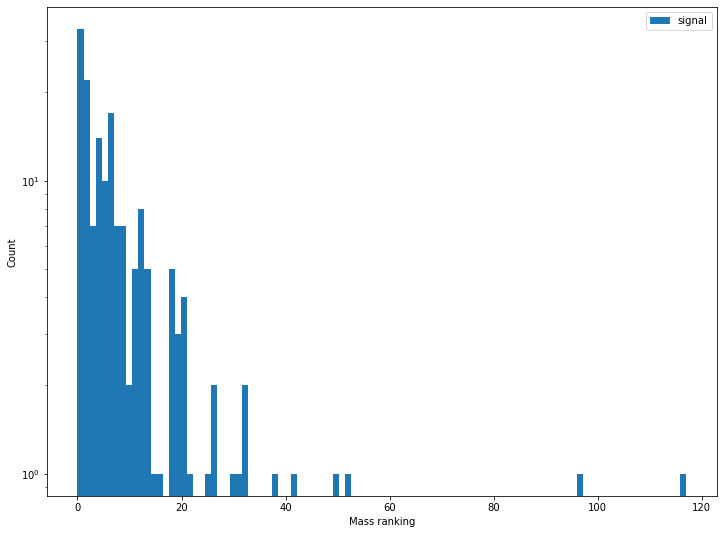

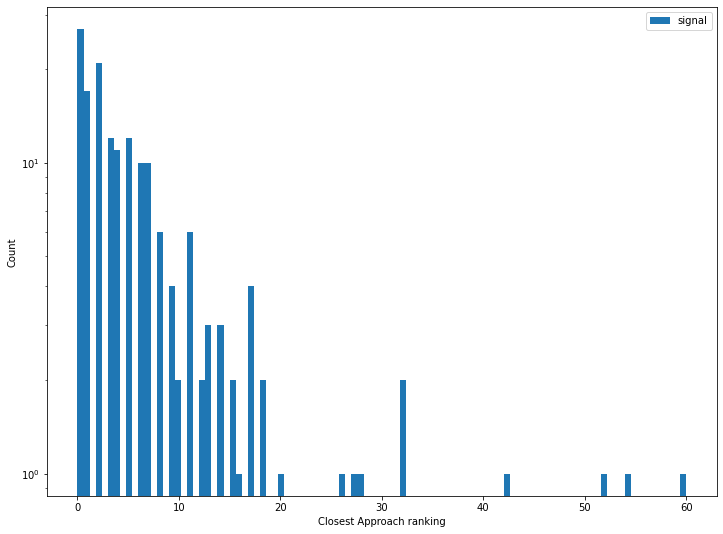

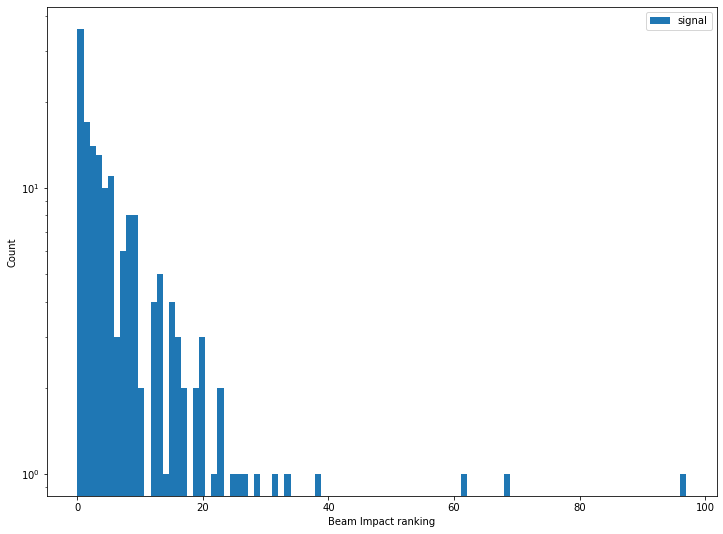

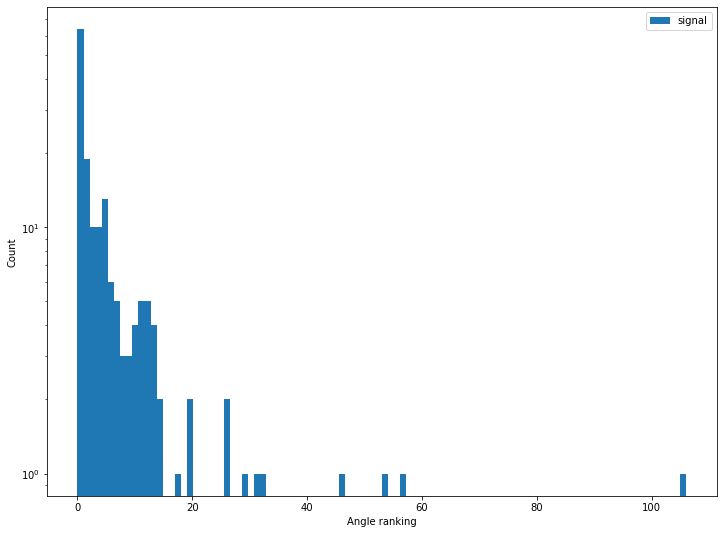

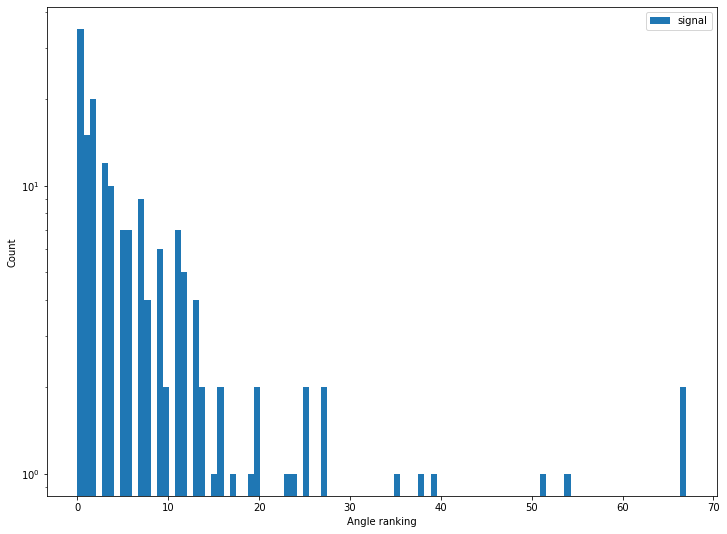

In [46]:
# This cell looks at ordering of PFOs in an event.
# We get the position of the "Truth" PFO in the event
truth_mask = sig_count == 2

mass_pos = ak.argsort(paired_mass(evts, pair_coords), ascending=True)[truth_mask]
closest_approach_pos = ak.argsort(paired_closest_approach(evts, pair_coords), ascending=True)[truth_mask]
beam_impact_pos = ak.argsort(paired_beam_impact(evts, pair_coords), ascending=True)[truth_mask]
angle_pos = ak.argsort(paired_opening_angle(evts, pair_coords), ascending=True)[truth_mask]
separation_pos = ak.argsort(paired_separation(evts, pair_coords), ascending=True)[truth_mask]

plot_rank_hist("Mass", mass_pos, bins=100)
plot_rank_hist("Closest approach", closest_approach_pos, bins=100)
plot_rank_hist("Beam impact", beam_impact_pos, bins=100)
plot_rank_hist("Angle", angle_pos, bins=100)
plot_rank_hist("Separation", separation_pos, bins=100)


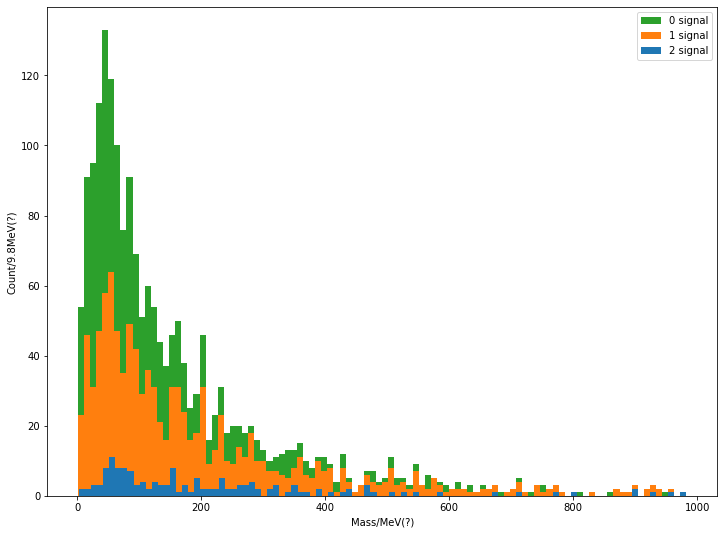

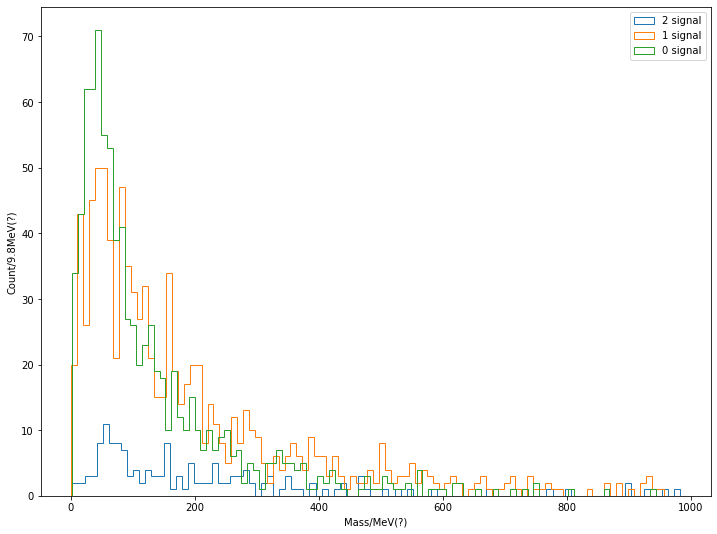

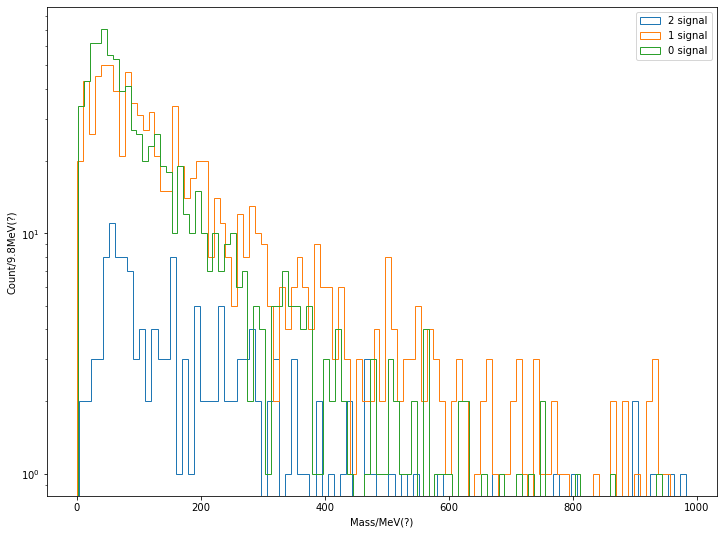

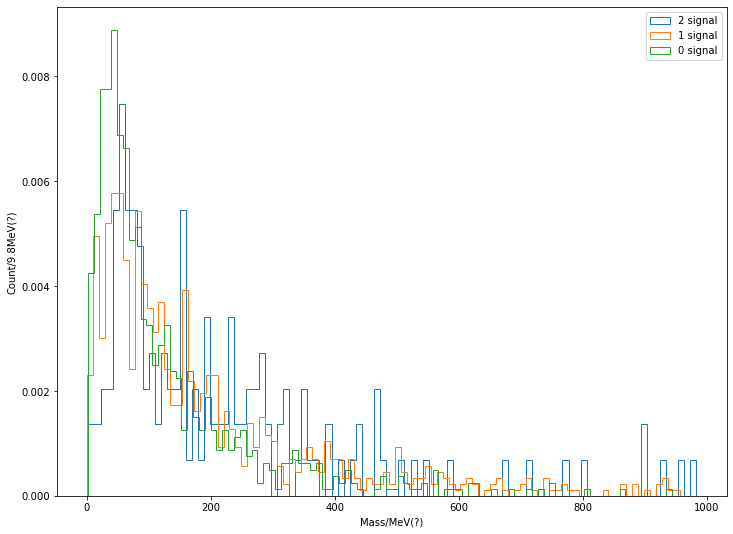

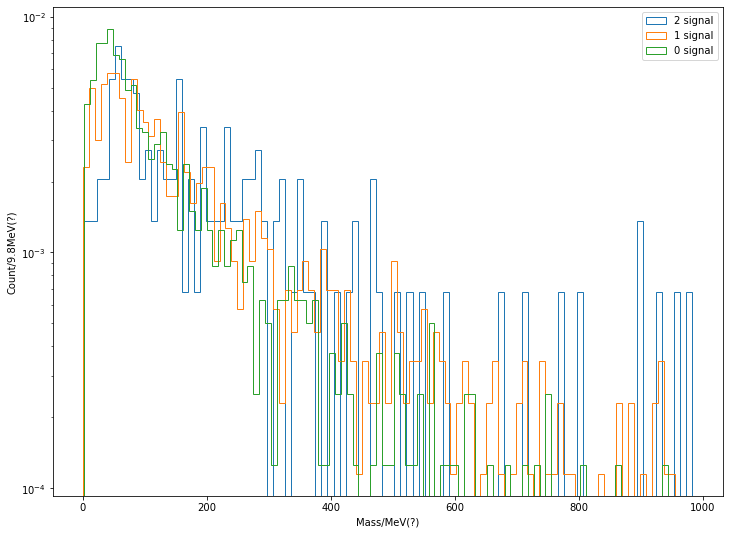

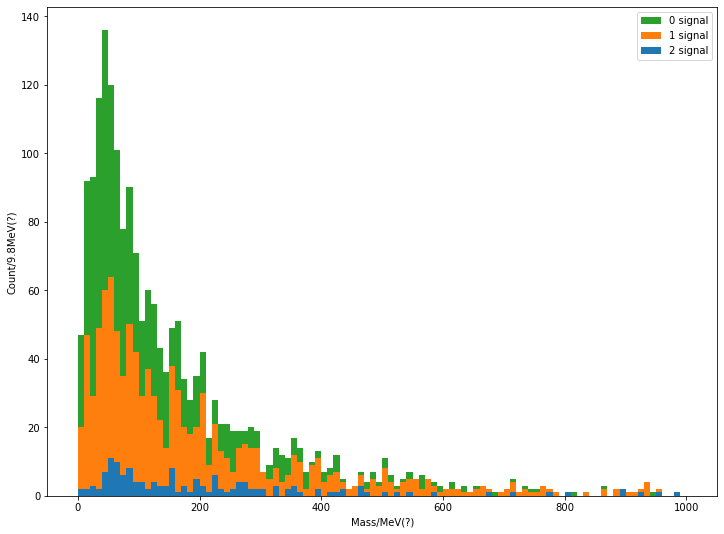

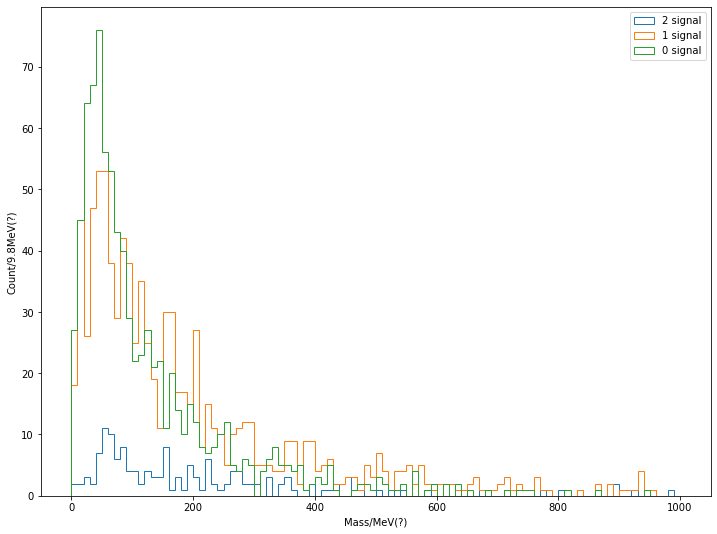

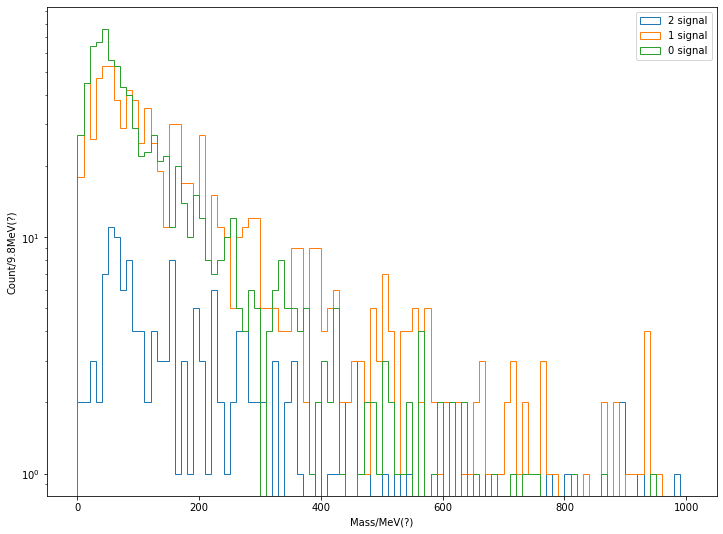

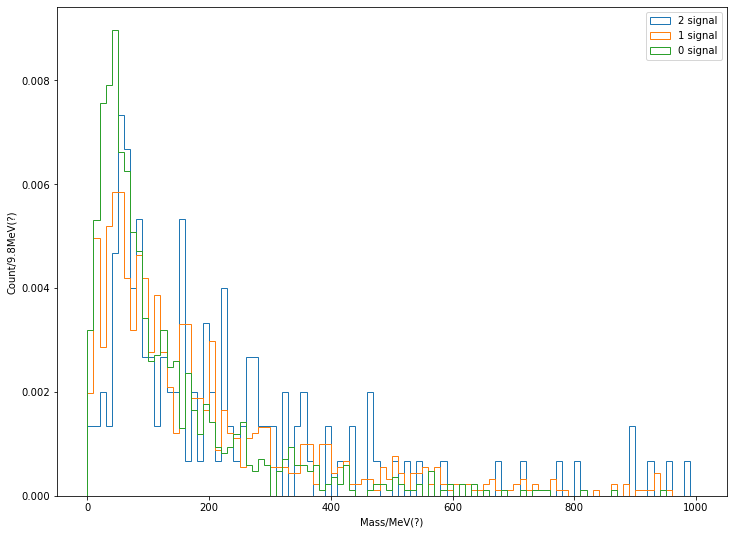

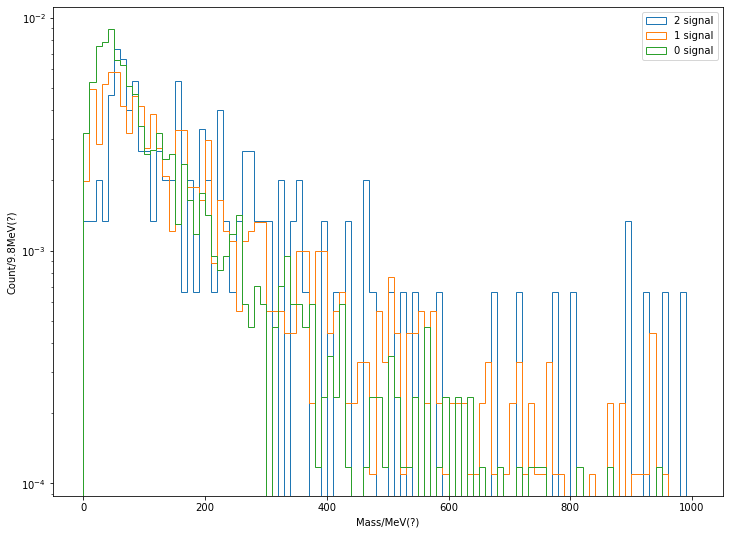

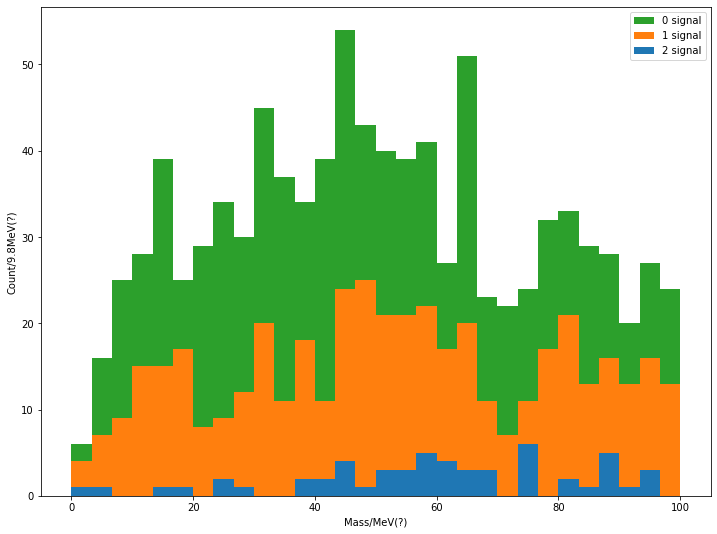

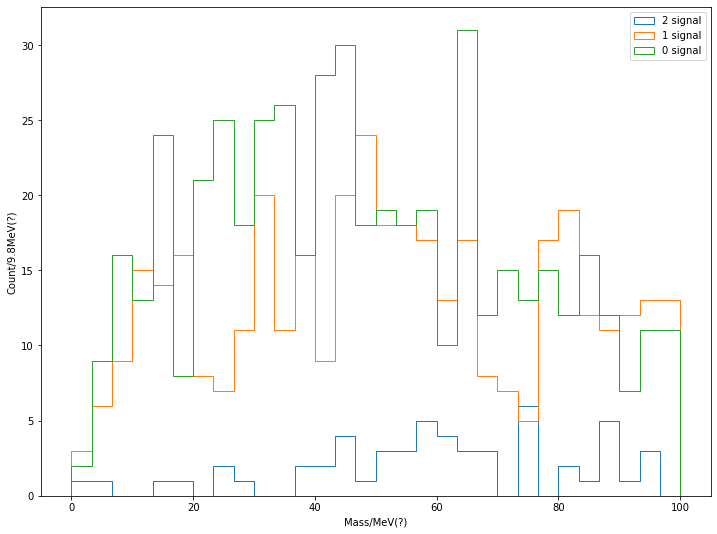

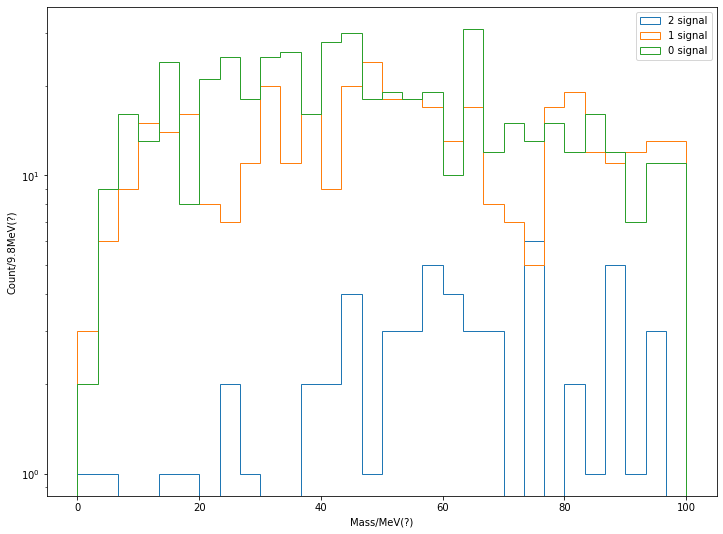

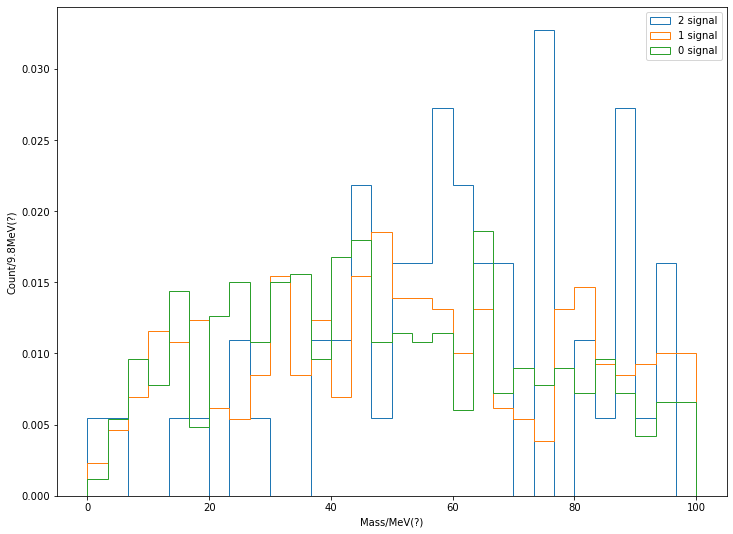

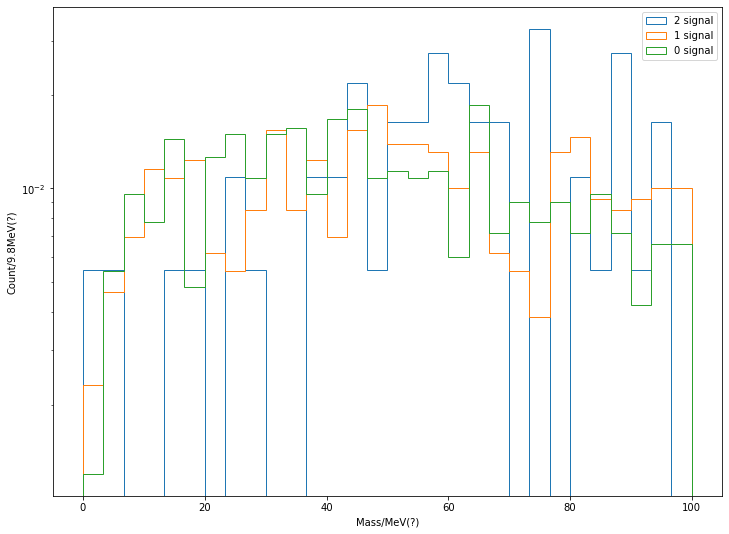

In [76]:
# masses = paired_mass(evts, pair_coords)
plot_pair_hists("mass", "MeV(?)", paired_mass(evts, pair_coords), sig_count, range=[None, 1000, 100], bins=[100, 100, 30])

In [18]:
# plt.hist(ak.ravel(paired_mass_old(ak.combinations(evts.recoParticles.momentum, 2))), bins=1000)
# plt.xlim(0,1000)
# plt.show()

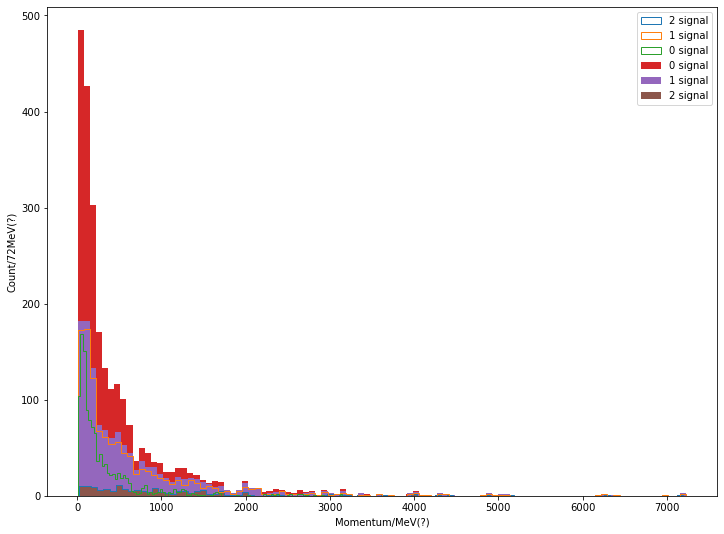

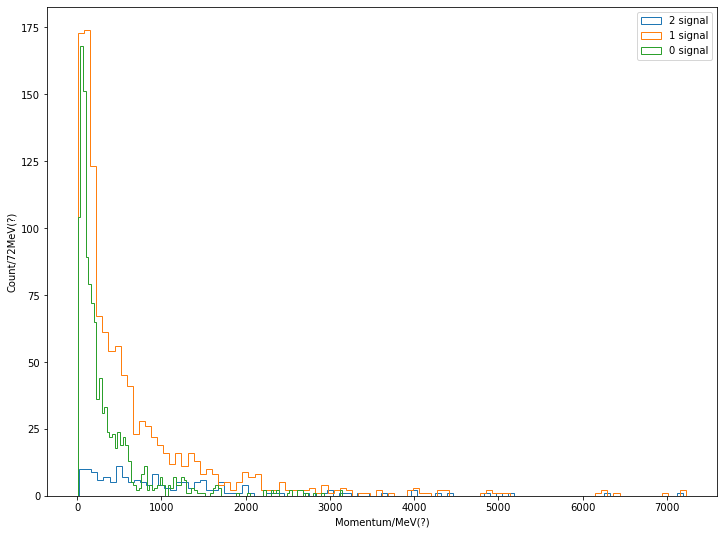

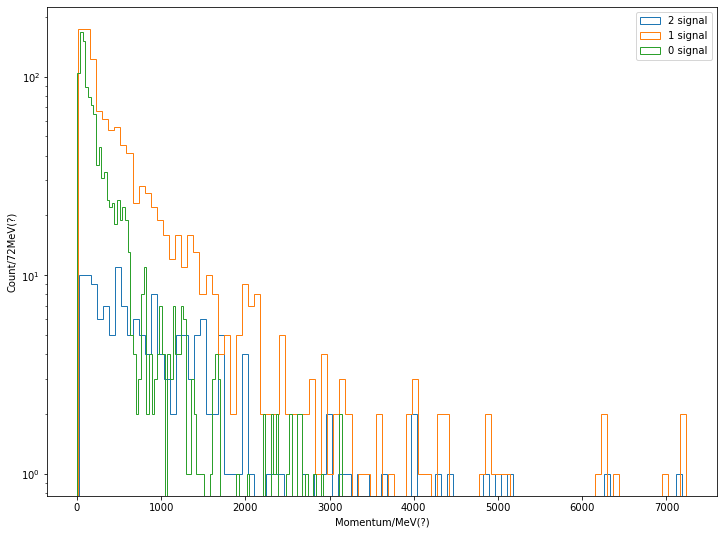

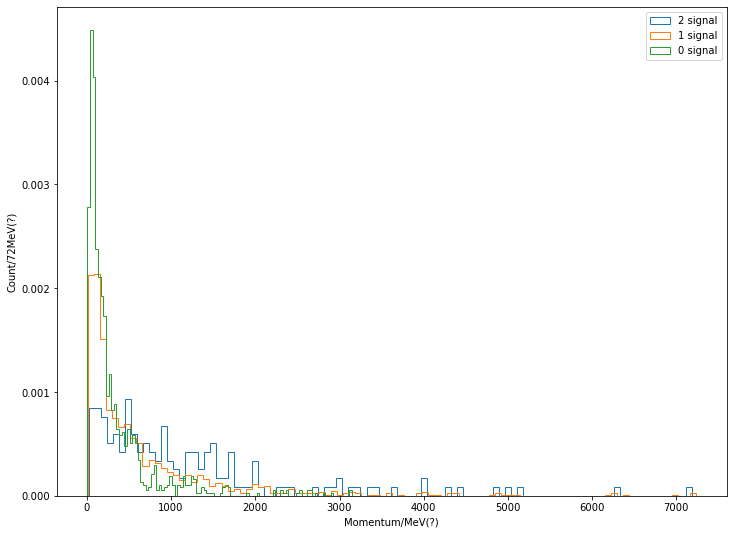

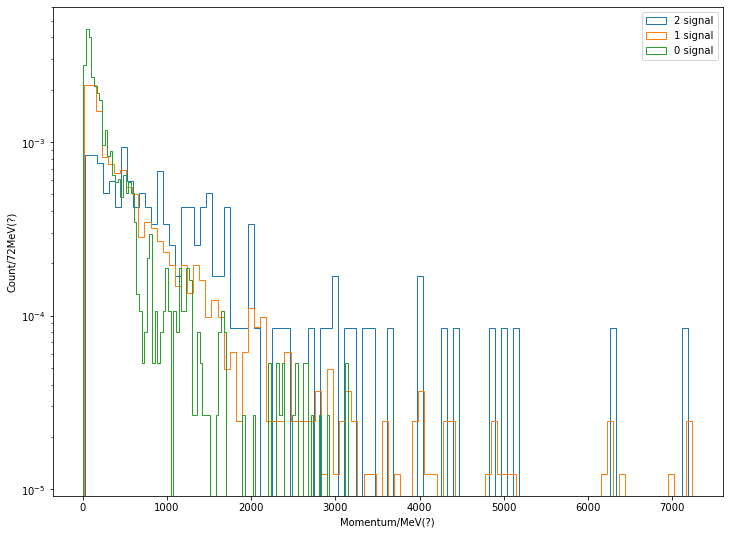

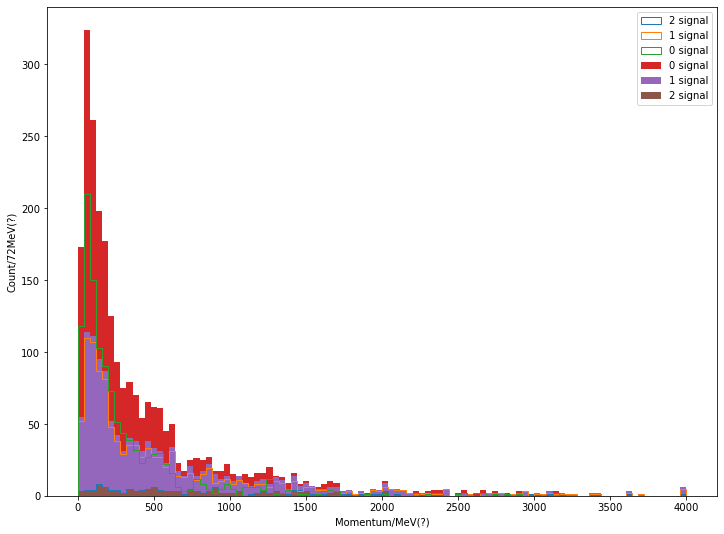

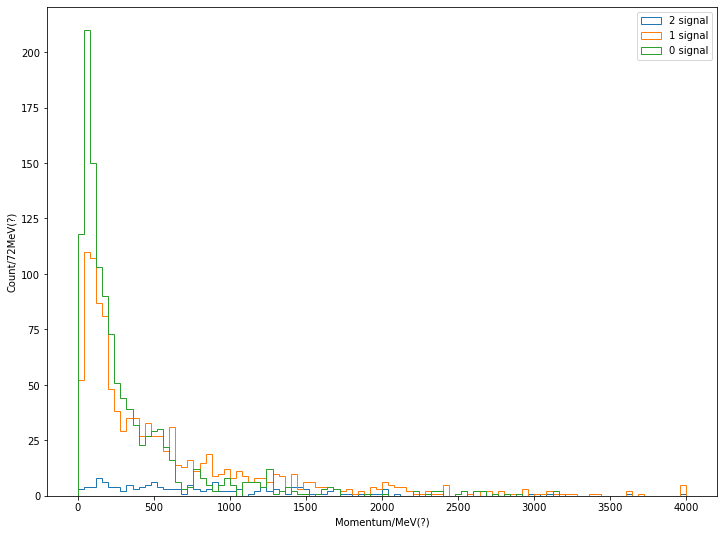

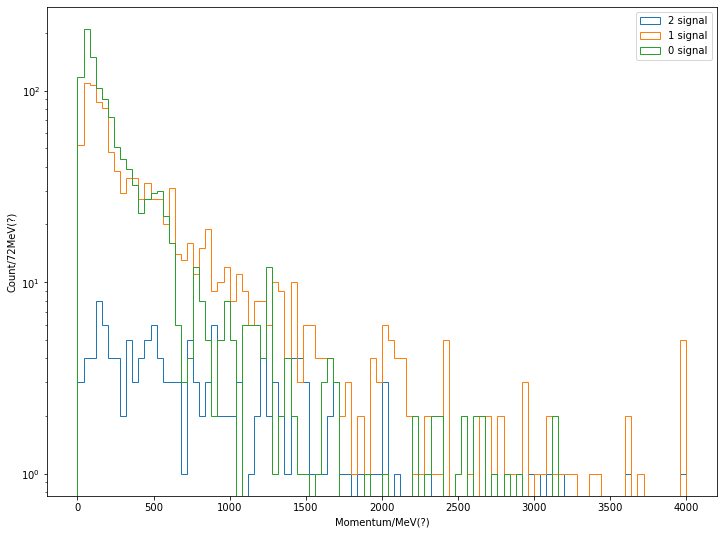

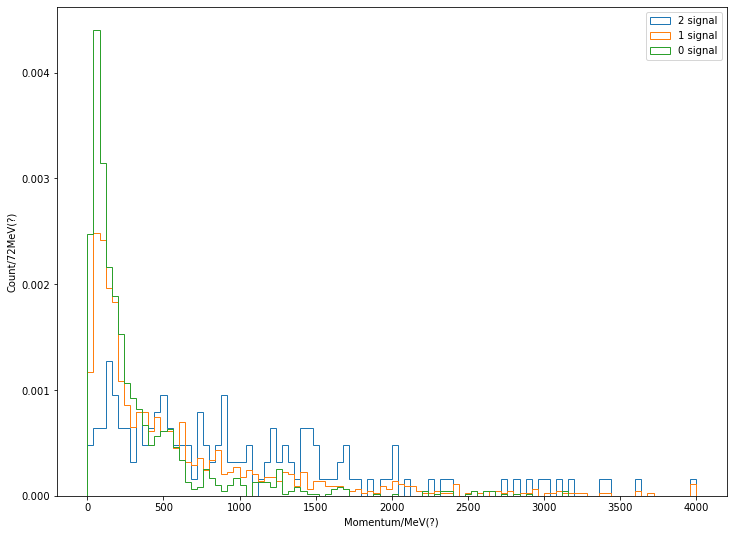

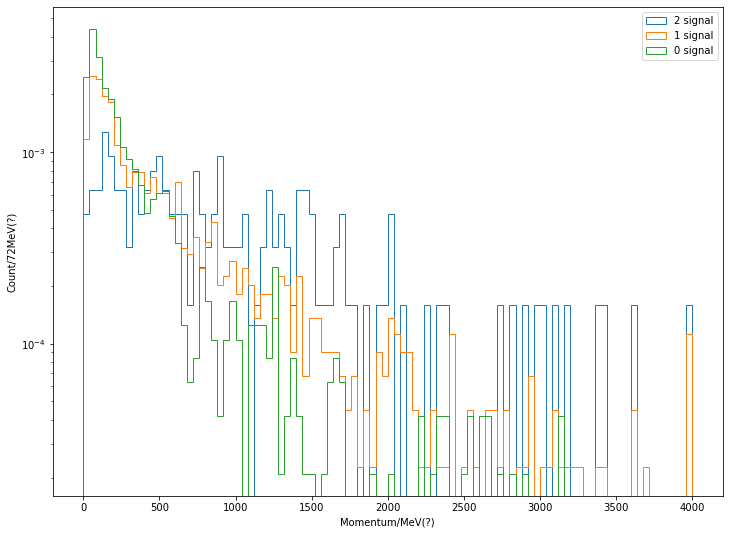

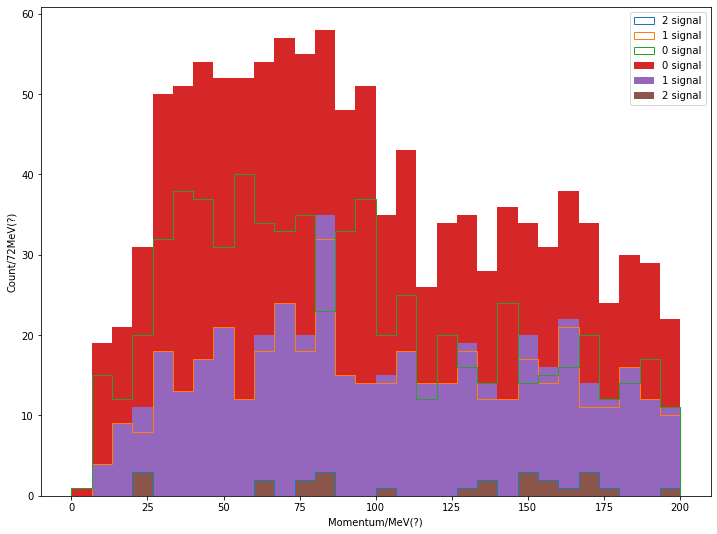

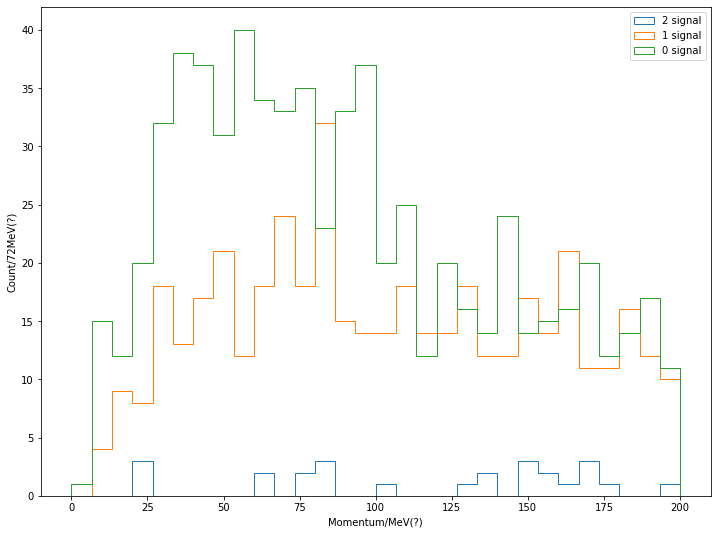

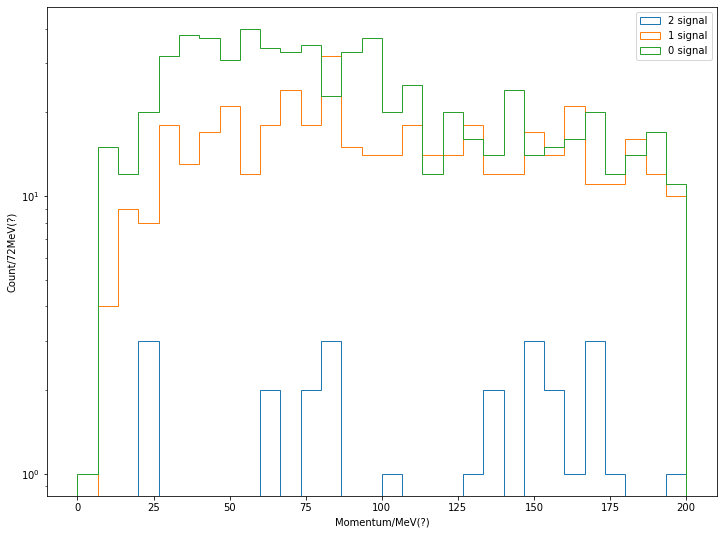

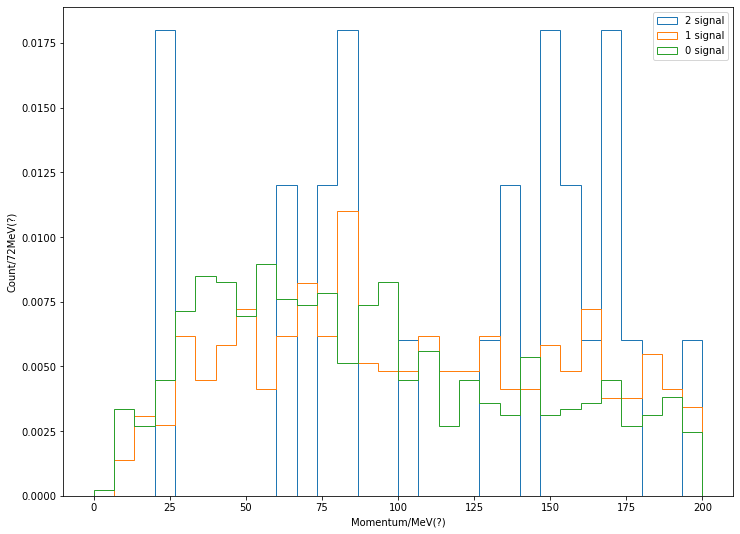

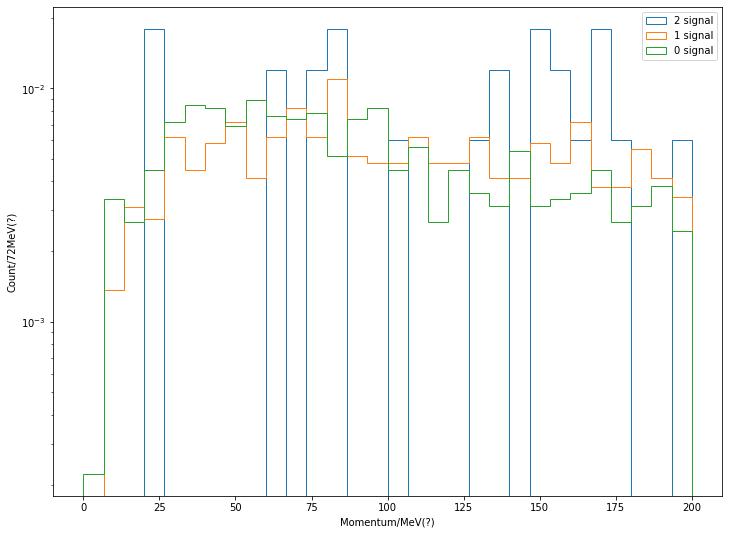

In [40]:
# momentum = paired_momentum(evts, pair_coords)
# mom_mag = vector.magnitude(momentum)
plot_pair_hists("momentum", "MeV(?)", vector.magnitude(paired_momentum(evts, pair_coords)), sig_count, range=[None, 4000, 200], bins=[100,100,30])

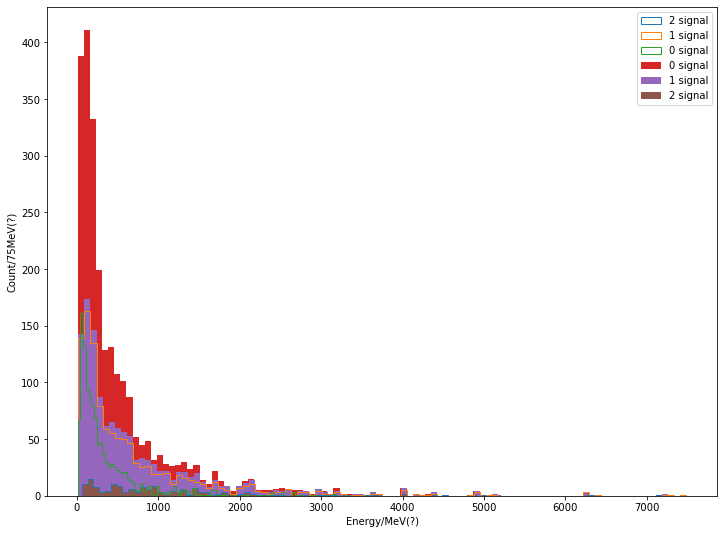

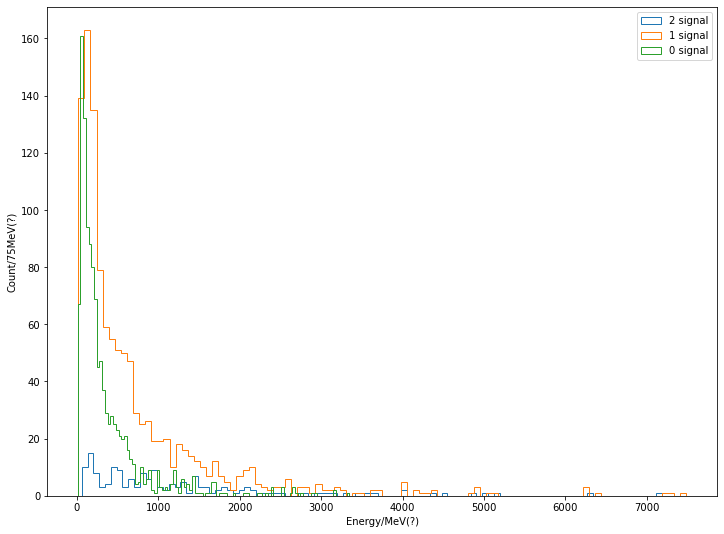

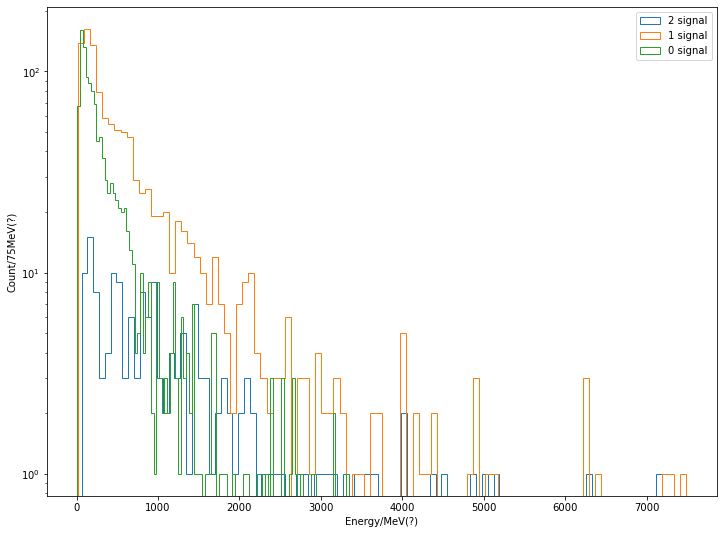

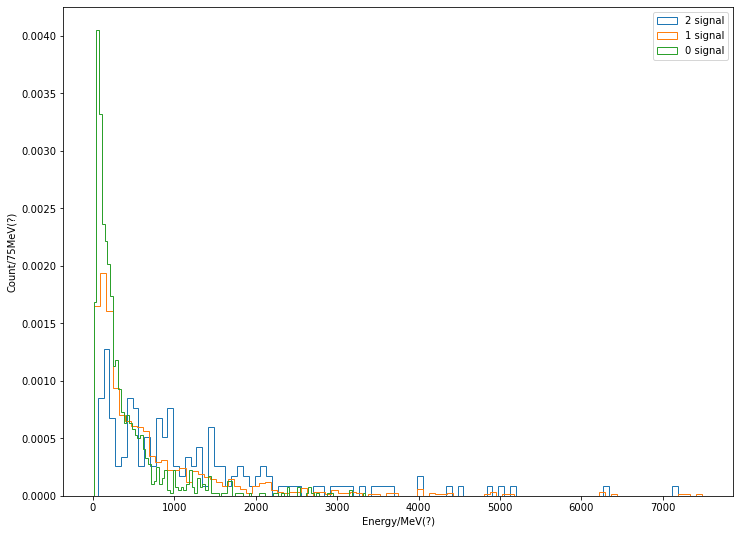

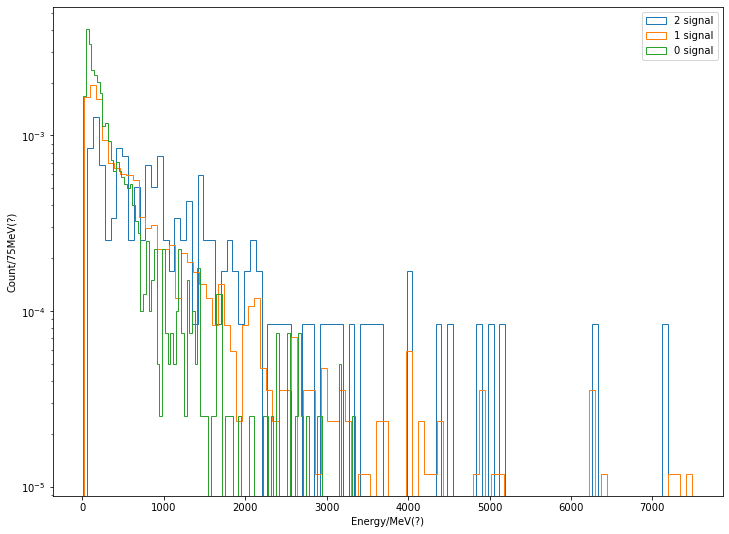

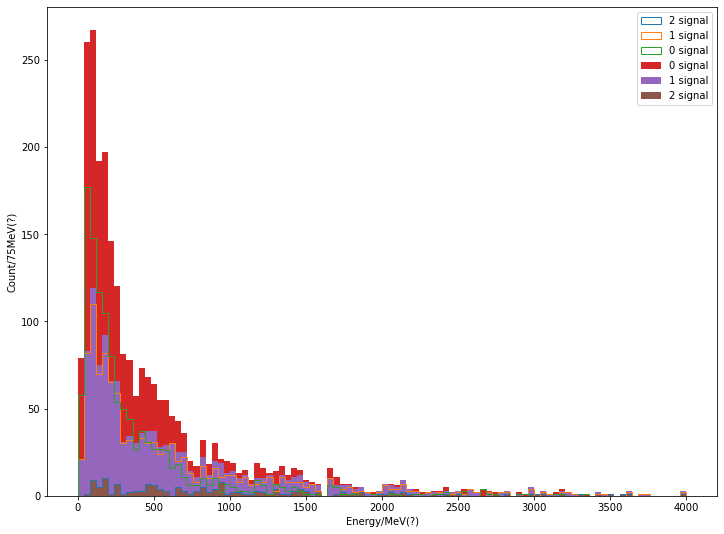

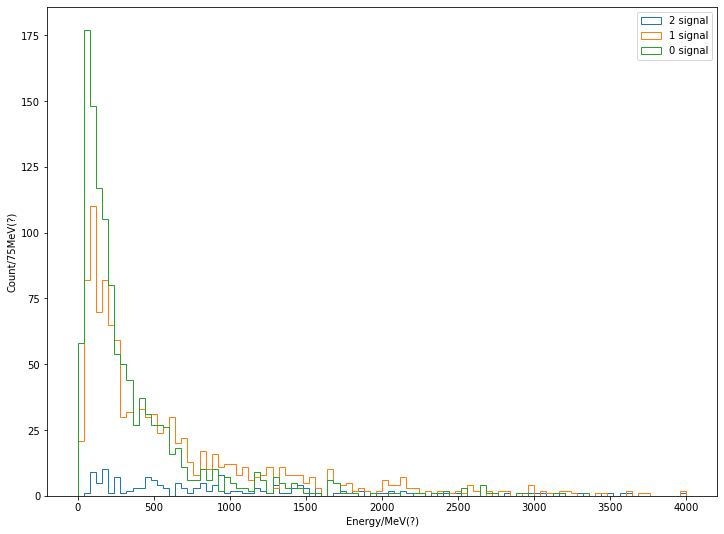

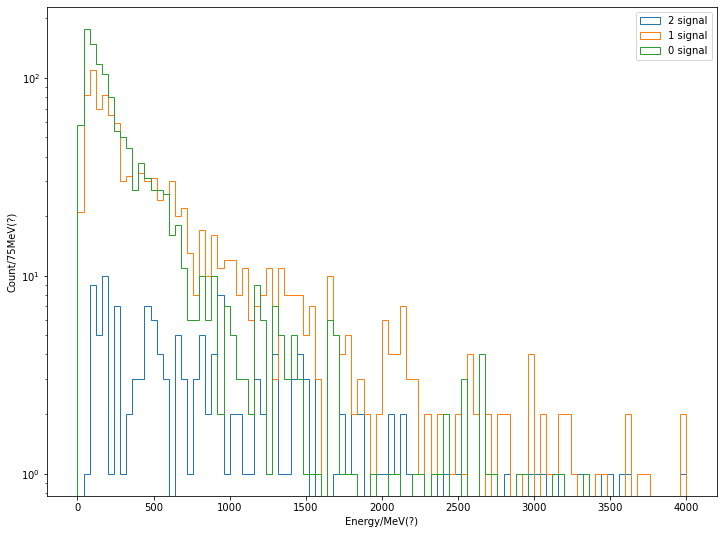

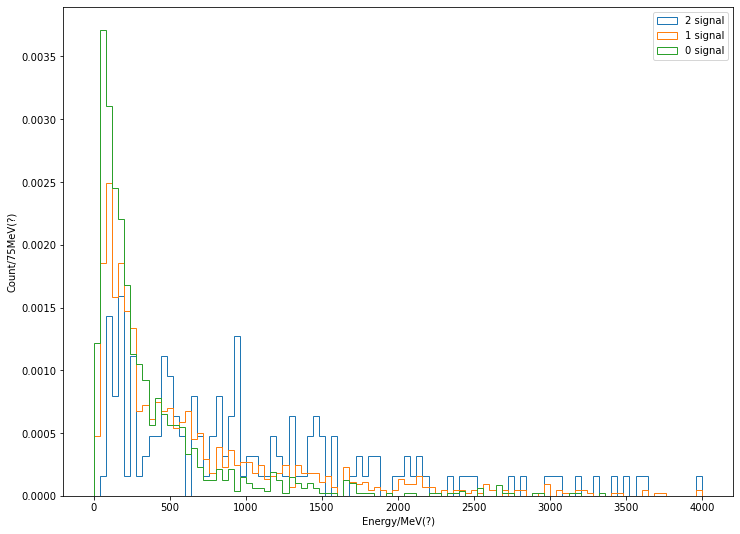

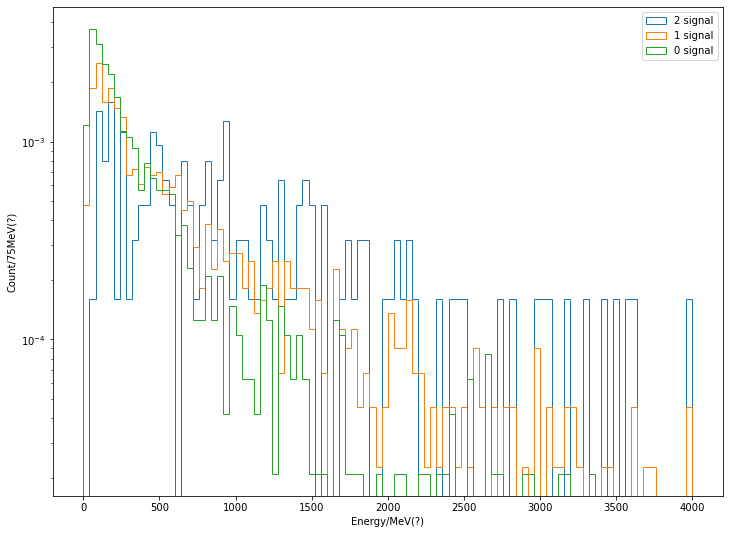

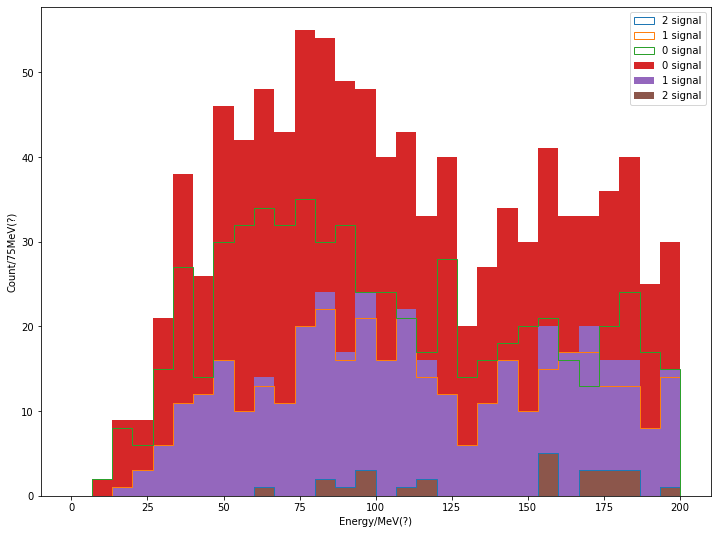

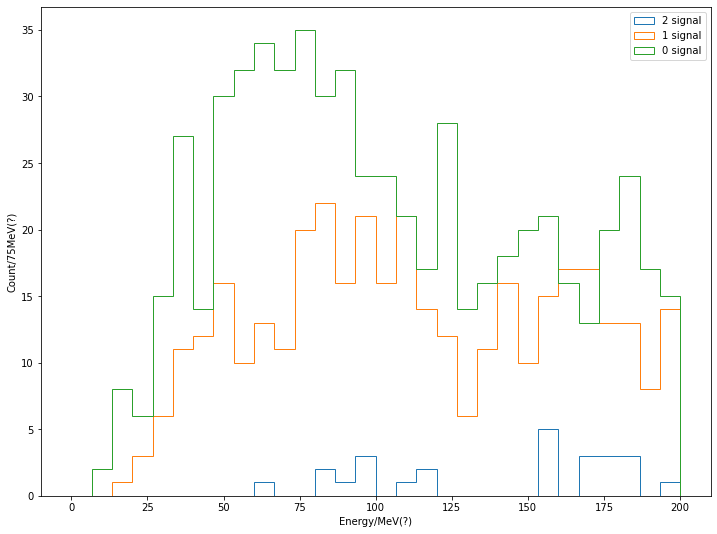

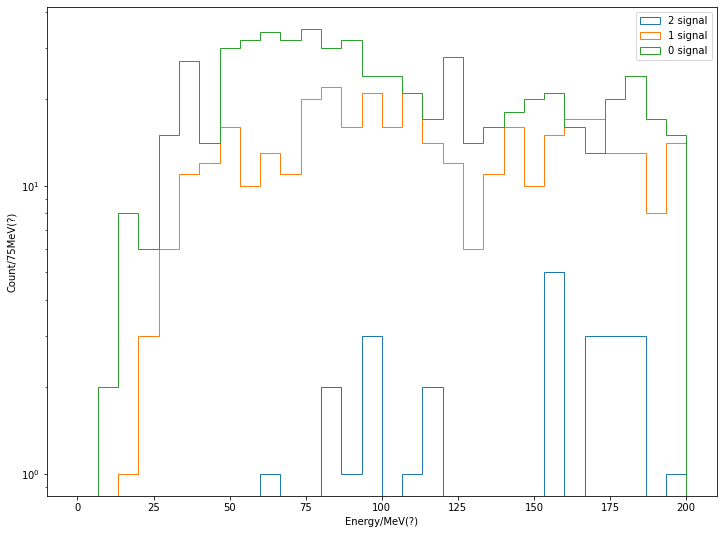

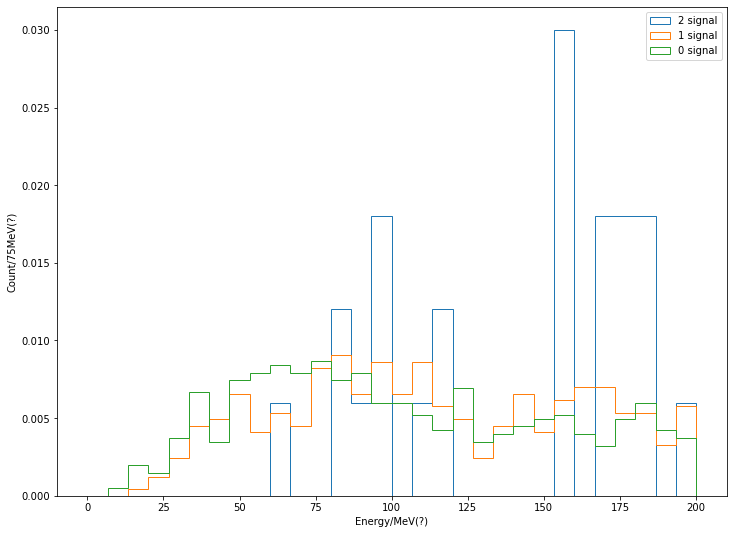

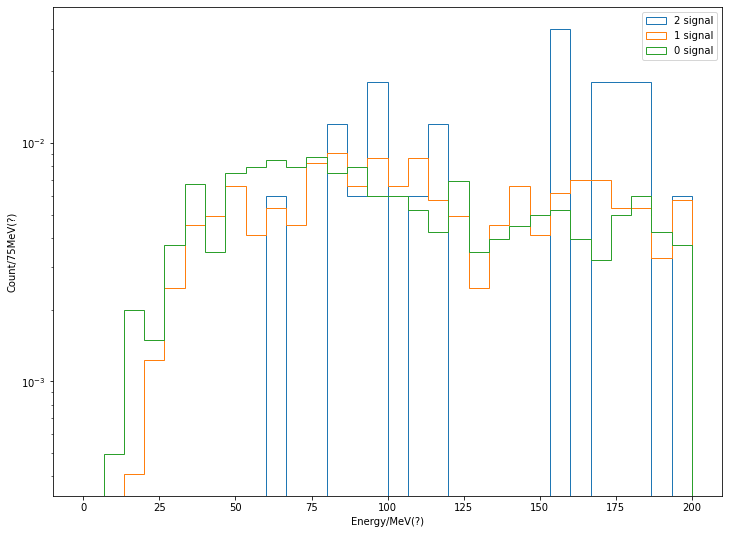

In [42]:
# energies = paired_energy(evts, pair_coords)
plot_pair_hists("energy", "MeV(?)", paired_energy(evts, pair_coords), sig_count, range=[None, 4000, 200], bins=[100,100,30])

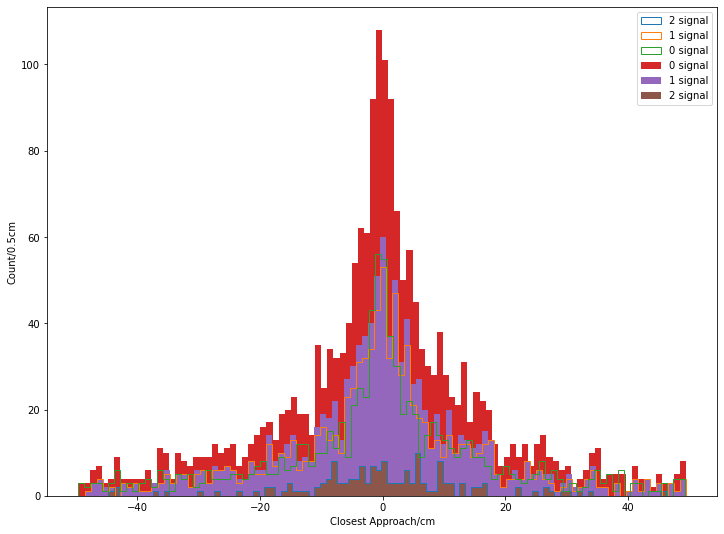

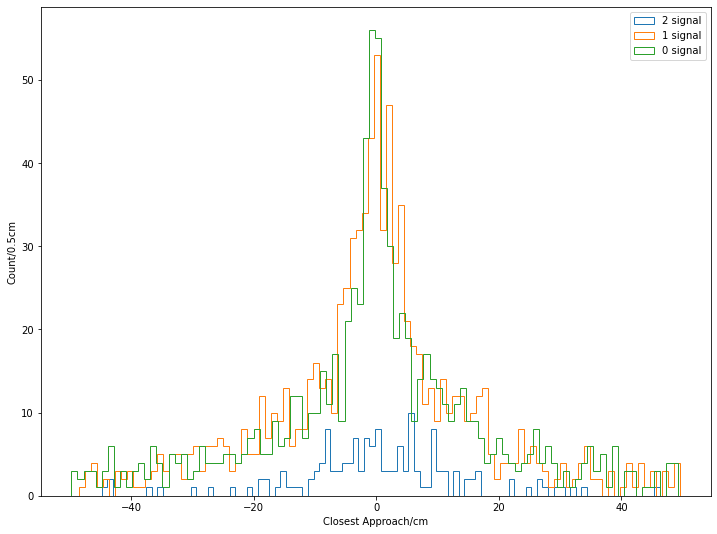

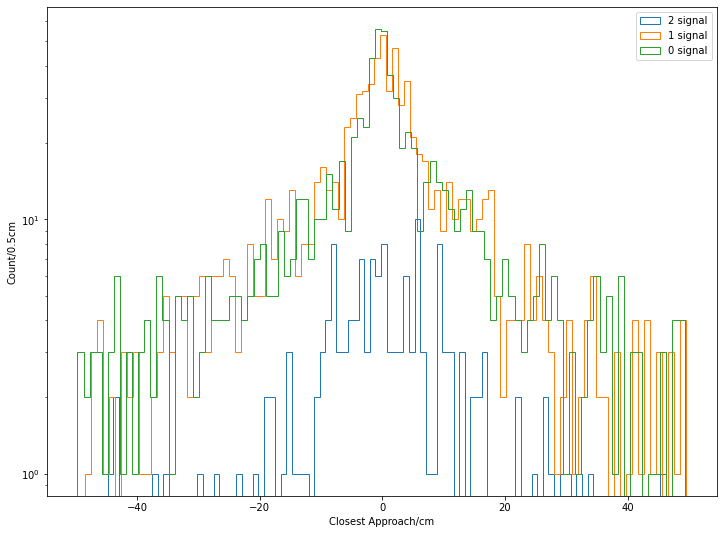

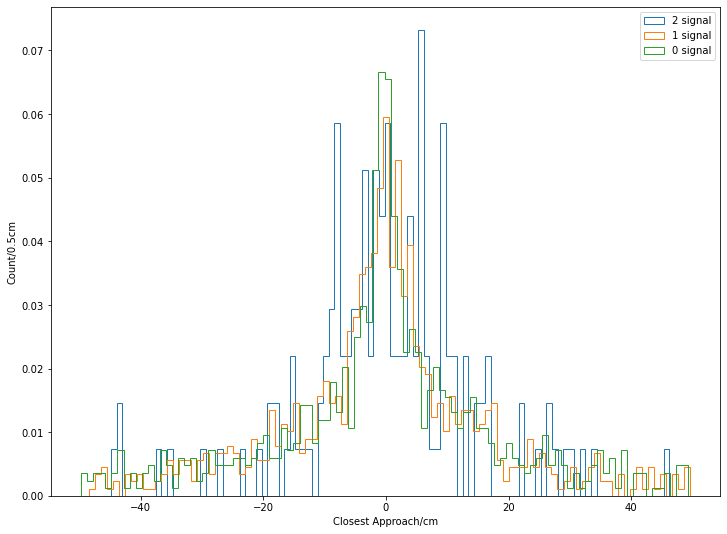

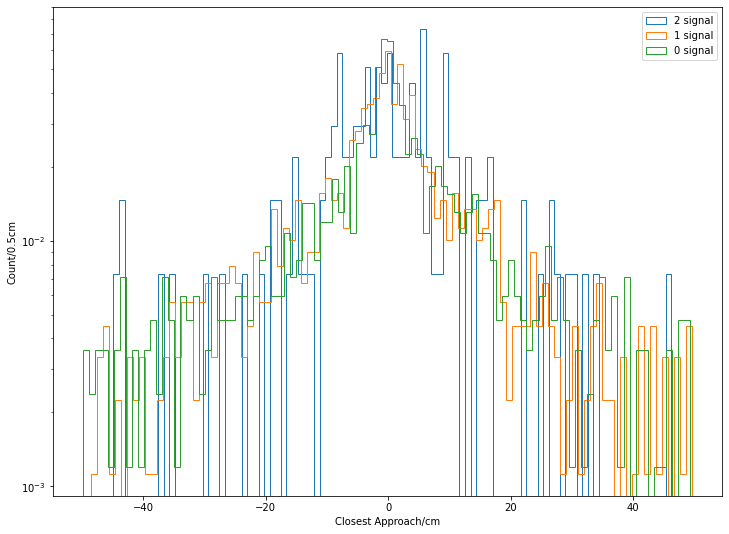

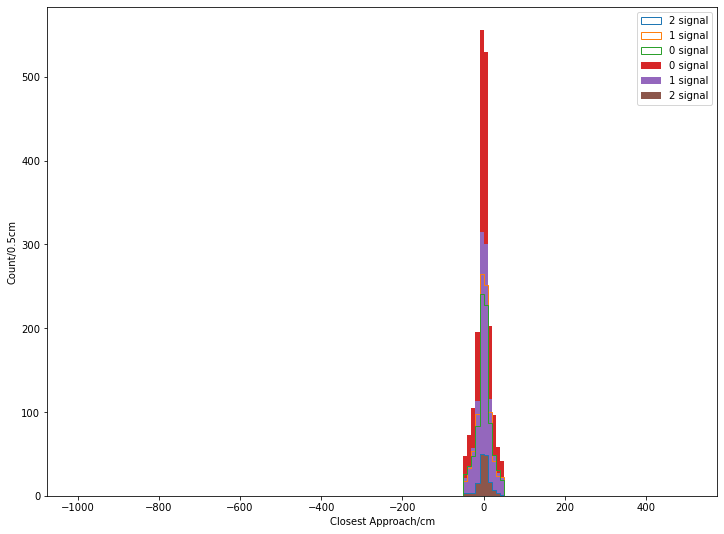

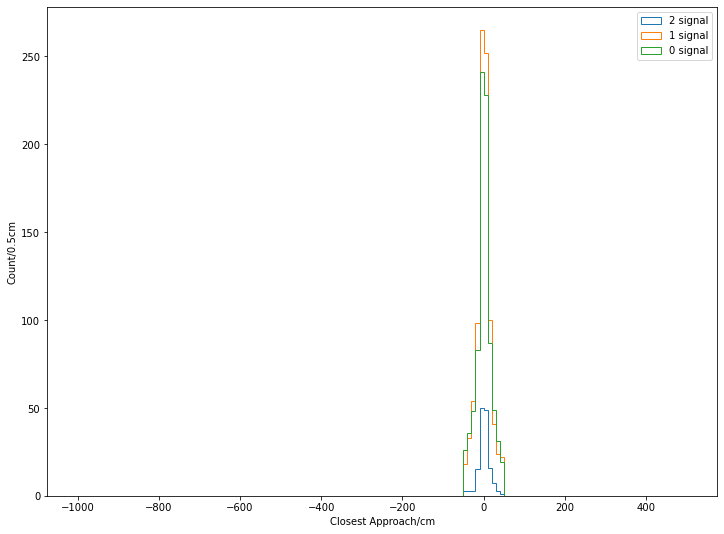

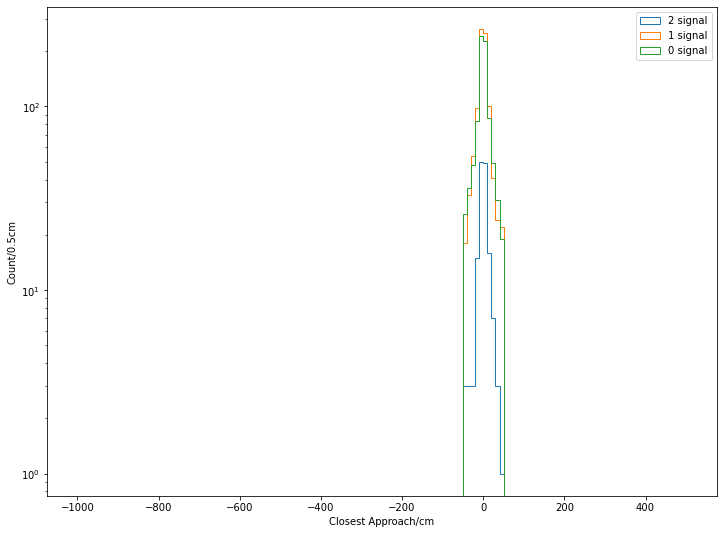

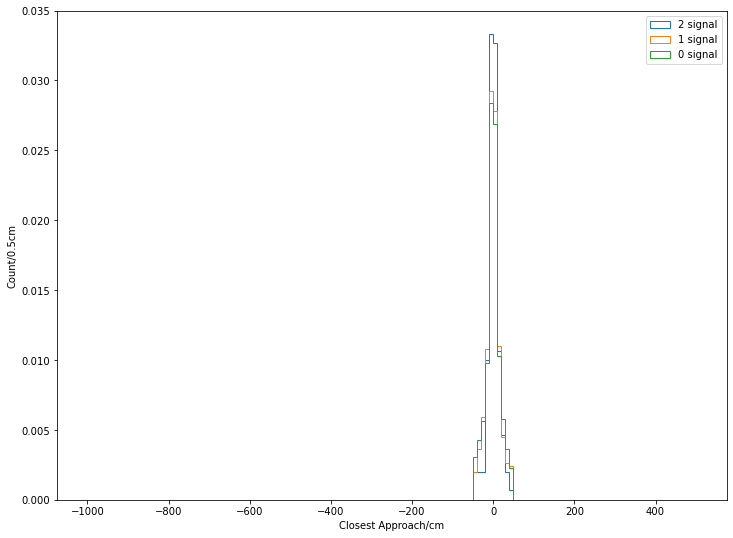

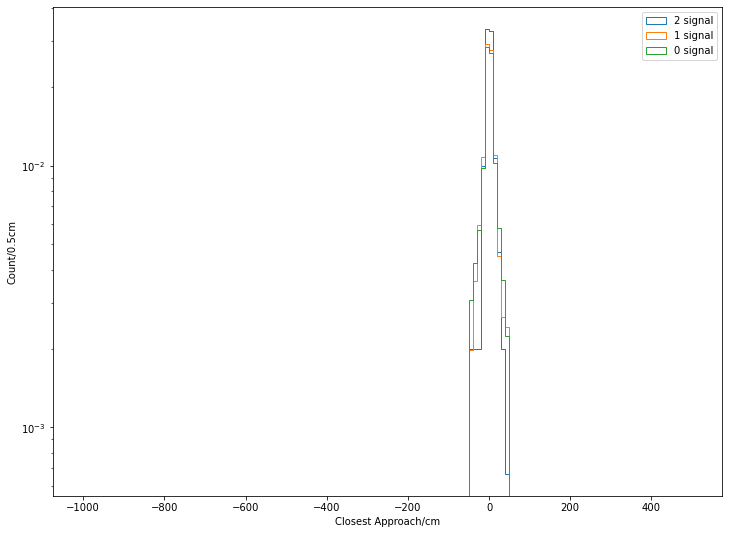

In [62]:
# approaches = paired_closest_approach(evts, pair_coords)
plot_pair_hists("closest approach", "cm", paired_closest_approach(evts, pair_coords), sig_count, range=[None, (-1000, 500)], bins=[100,150])

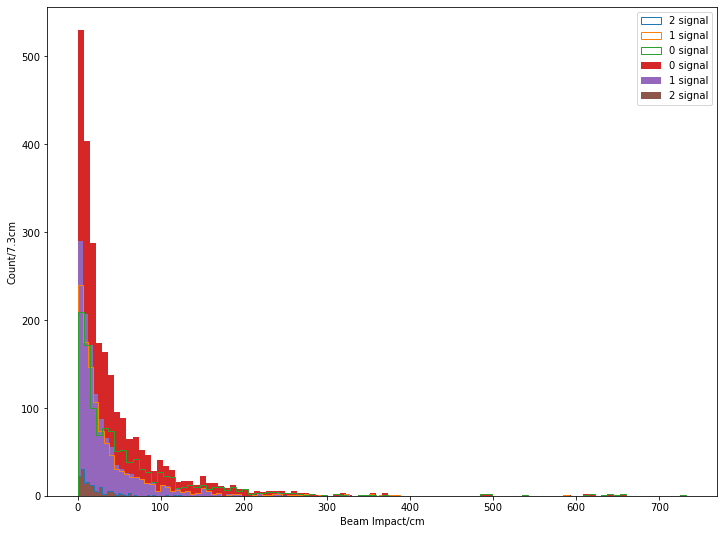

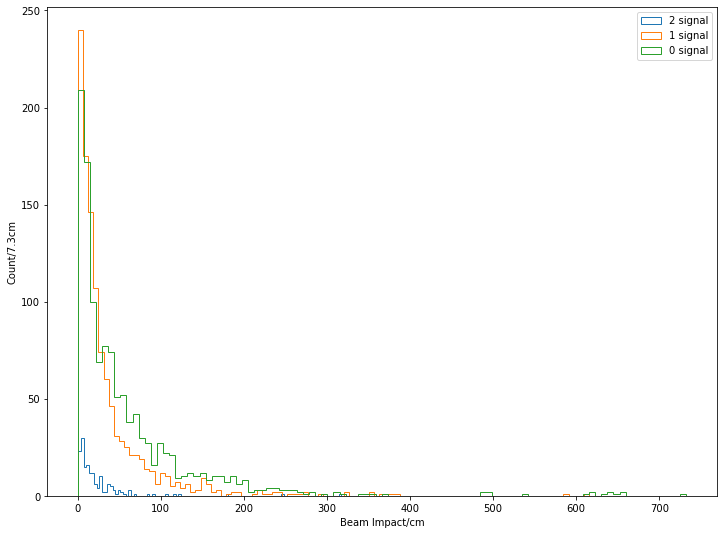

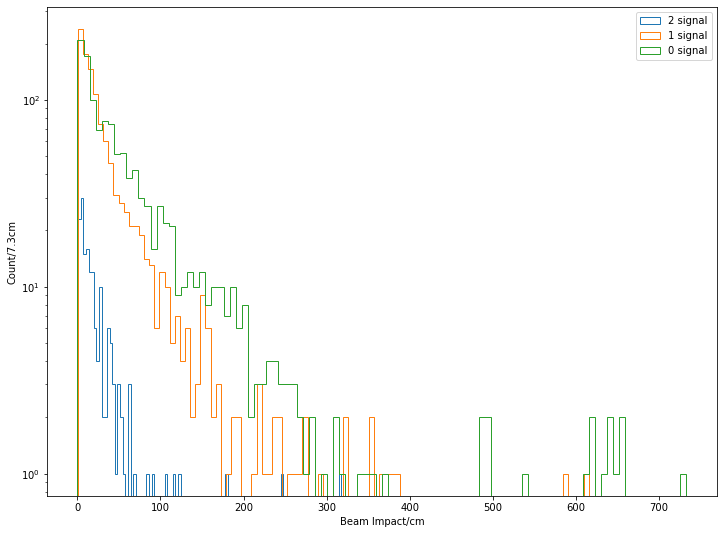

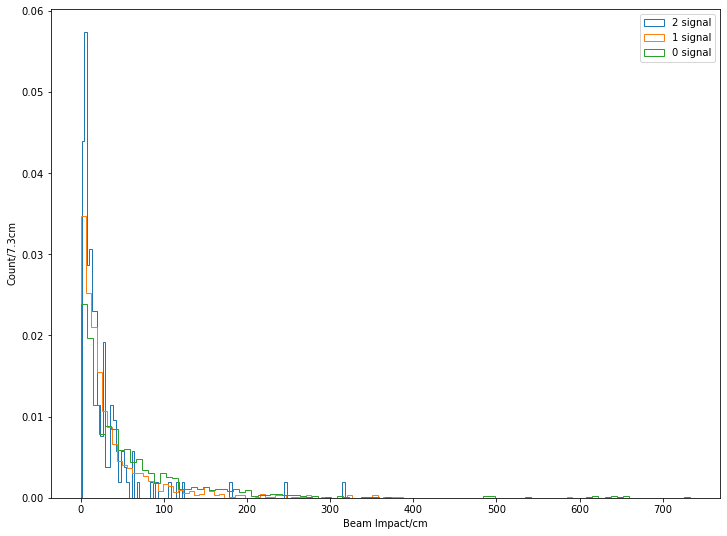

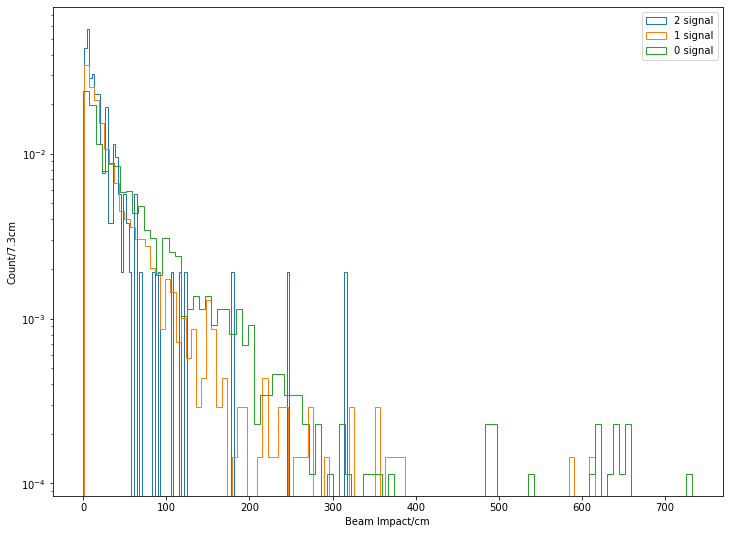

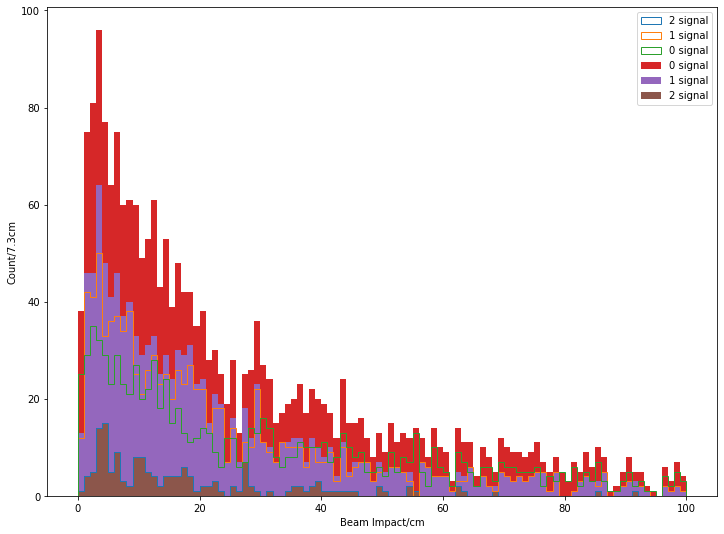

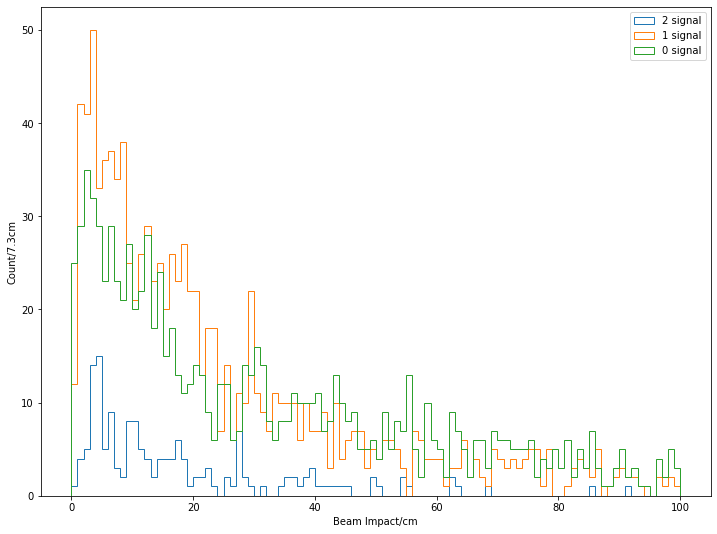

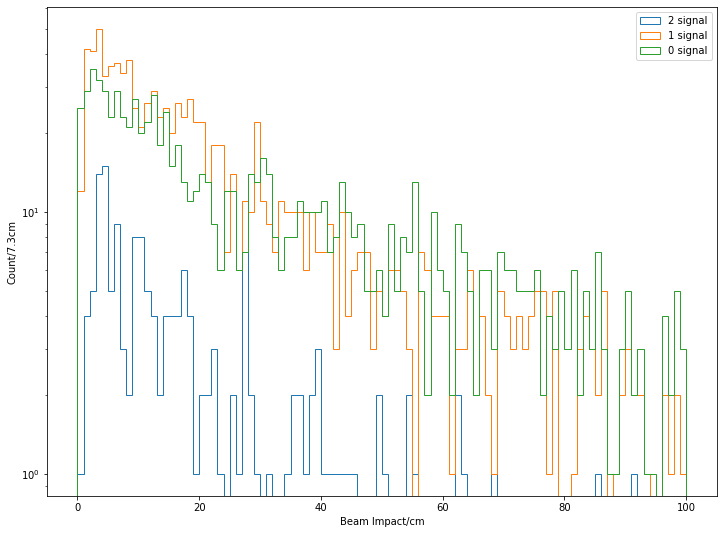

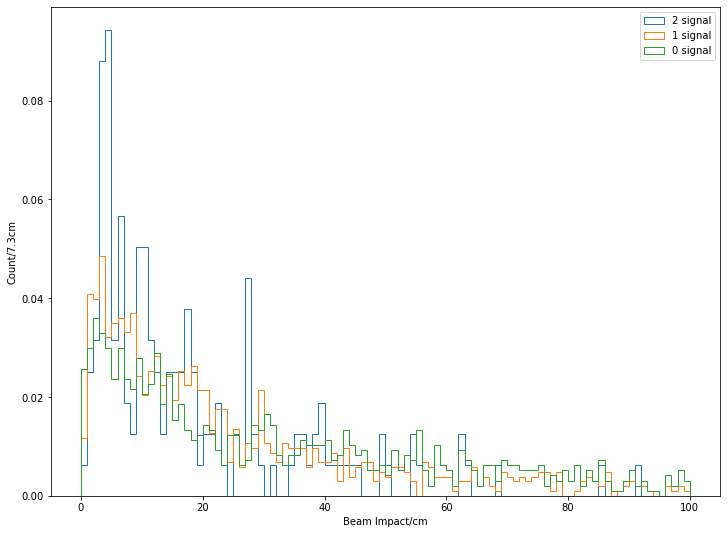

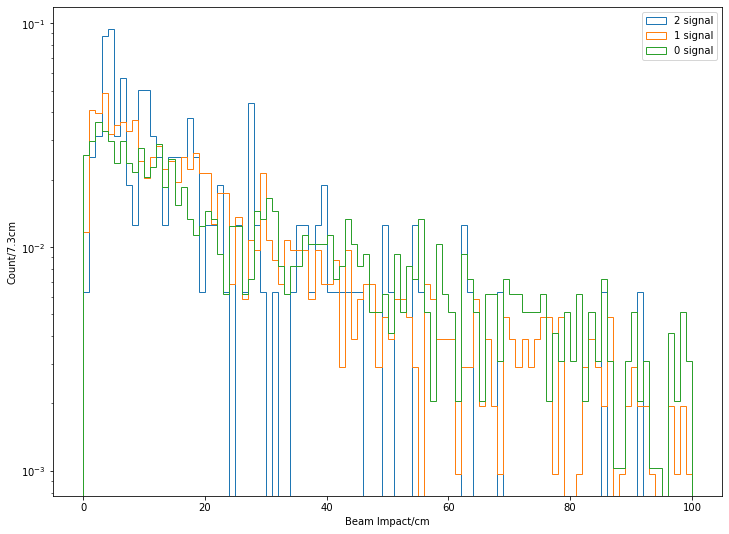

In [45]:
plot_pair_hists("beam impact", "cm", paired_beam_impact(evts, pair_coords), sig_count, range=[None, 100], bins=100)

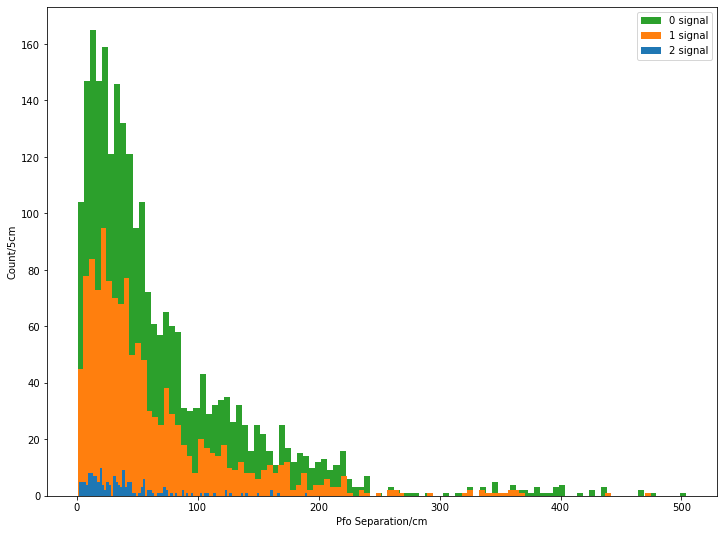

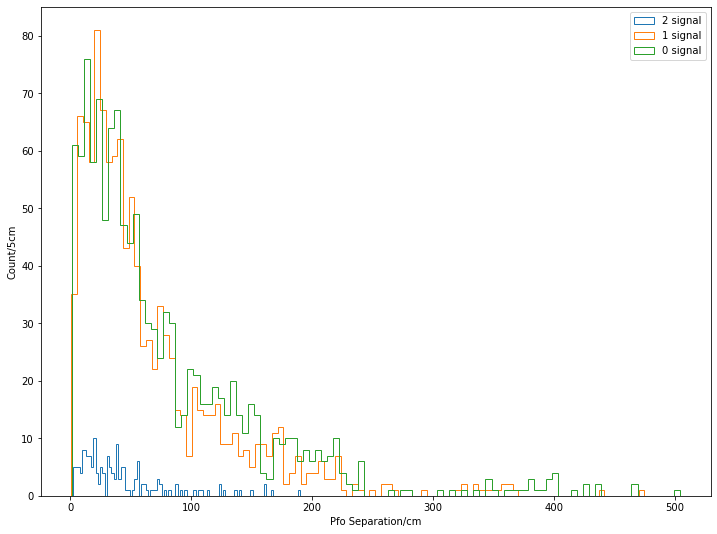

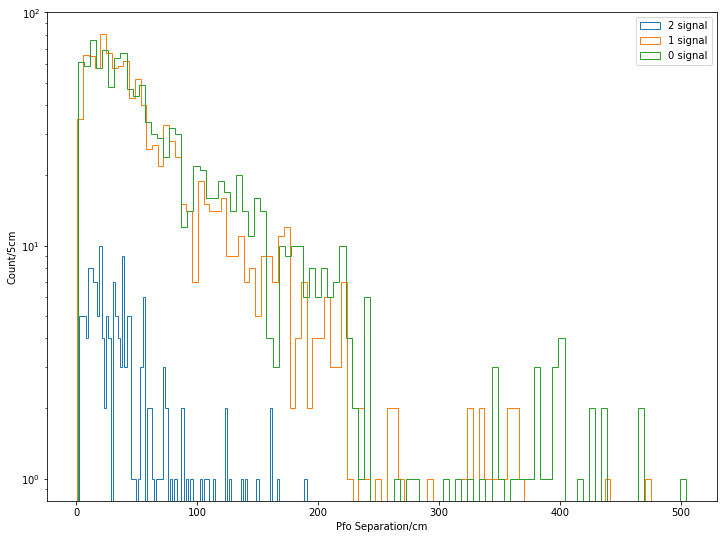

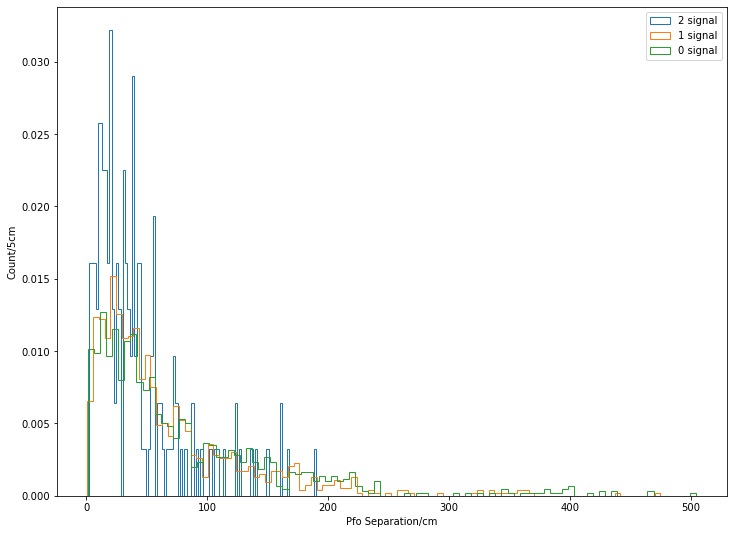

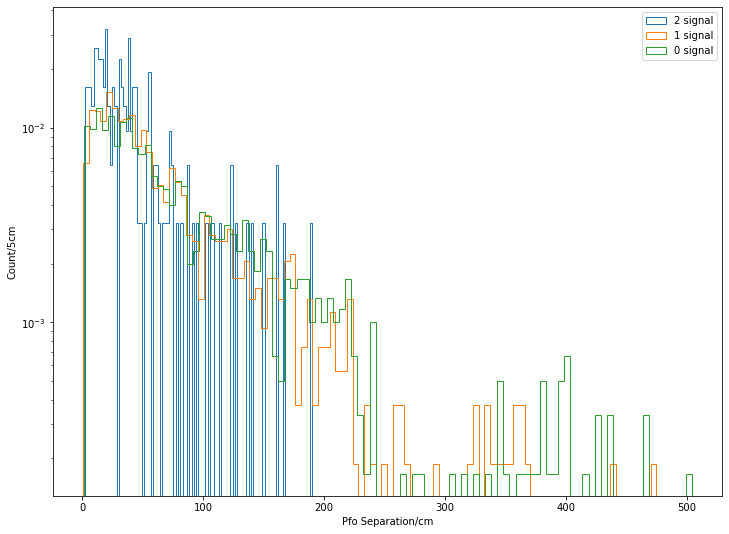

In [22]:
plot_pair_hists("pfo separation", "cm", paired_separation(evts, pair_coords), sig_count, bins=100)

In [2]:
angles = paired_opening_angle(evts, pair_coords)
plot_pair_hists("angle", "rad", angles, sig_count, range=None, bins=100, bin_size="(pi/50)rad")

# Weight the bin widths to keep then with equal area on a sphere
# Area cover over angle dTheta is r sin(Theta) dTheta (with r=1)
# So we need constant sin(Theta) dTheta
# In the range Theta = [0, pi), we have
# \int^\pi_0 sin(\theta) d\theta = 2
# So for 100 bins, we need: sin(Theta) dTheta = 2/100 = 0.02
# \int^{\theta_new}_{\theta_old} sin(\theta) d\theta = 2/100
# So 0.2 = cons(theta_old) - cos(theta_new)
n_bins = 100
bins = np.zeros(n_bins+1)
for i in range(n_bins):
    bins[i+1] = np.arccos(np.max([np.cos(bins[i]) - 2/n_bins, -1]))


# TODO Need to fix the normailisation, currently it's not working!
plot_pair_hists("angle", "rad", angles, sig_count, range=None, bins=bins, bin_size="(pi/25)arcrad", unique_save_id = "_sphere", inc_norm=False)
plot_pair_hists("angle", "rad", angles, sig_count, range=None, bins=bins, bin_size="(pi/25)arcrad", unique_save_id = "_sphere_norm", inc_norm=False, weights=ak.full_like(angles, 1/(0.04*np.pi)))

del angles

NameError: name 'paired_opening_angle' is not defined

In [48]:
# new_pair_mask = np.logical_and(np.abs(paired_closest_approach(evts, pair_coords)) < 80, np.abs(paired_mass(evts, pair_coords)) < 1000)
new_pair_mask = np.logical_and(
    np.logical_and(paired_beam_impact(evts, pair_coords) <= 100,
        np.logical_and(np.abs(paired_closest_approach(evts, pair_coords)) < 50, paired_separation(evts, pair_coords) < 200)),
    np.logical_and(paired_mass(evts, pair_coords) < 1000,
        np.logical_and(paired_energy(evts, pair_coords) > 5, paired_energy(evts, pair_coords) < 5000)) #Remove And operator!
)

pair_coords = pair_coords[new_pair_mask]
sig_count = sig_count[new_pair_mask]

# Probably also need to apply the filter to evts, but this will come after a final cut is selected.

del new_pair_mask


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0]


ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

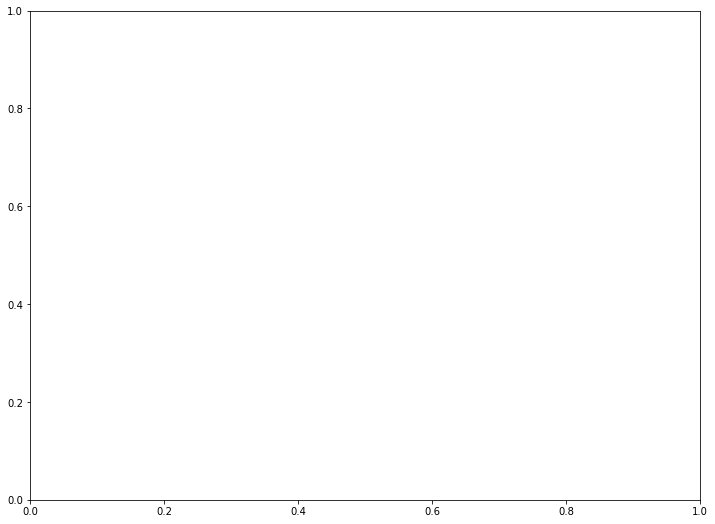

In [60]:
# This cell looks at ordering of PFOs in an event.
# We get the position of the "Truth" PFO in the event
truth_mask = sig_count == 2

mass_pos = ak.argsort(paired_mass(evts, pair_coords), ascending=True)[truth_mask]
closest_approach_pos = ak.argsort(paired_closest_approach(evts, pair_coords), ascending=True)[truth_mask]
beam_impact_pos = ak.argsort(paired_beam_impact(evts, pair_coords), ascending=True)[truth_mask]
angle_pos = ak.argsort(paired_opening_angle(evts, pair_coords), ascending=True)[truth_mask]
separation_pos = ak.argsort(paired_separation(evts, pair_coords), ascending=True)[truth_mask]

plot_rank_hist("Mass", mass_pos, bins=100)
plot_rank_hist("Closest approach", closest_approach_pos, bins=100)
plot_rank_hist("Beam impact", beam_impact_pos, bins=100)
plot_rank_hist("Angle", angle_pos, bins=100)
plot_rank_hist("Separation", separation_pos, bins=100)

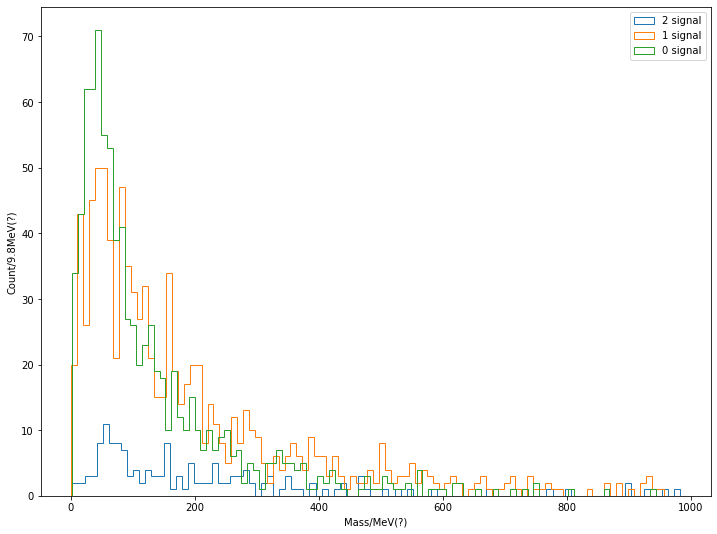

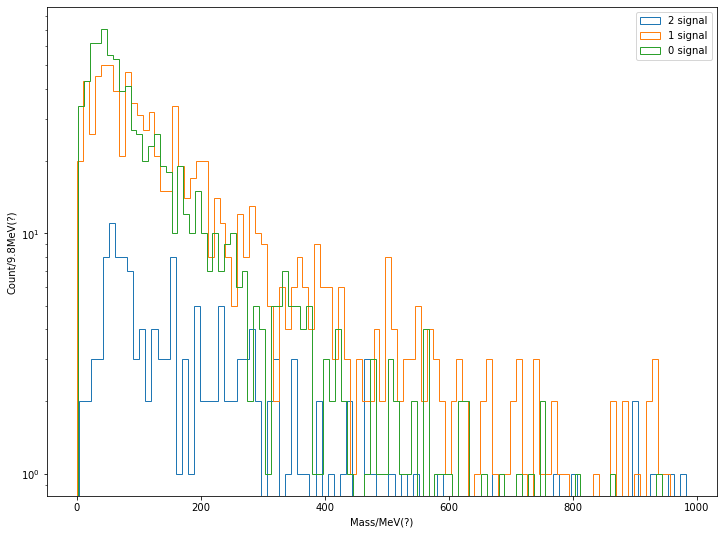

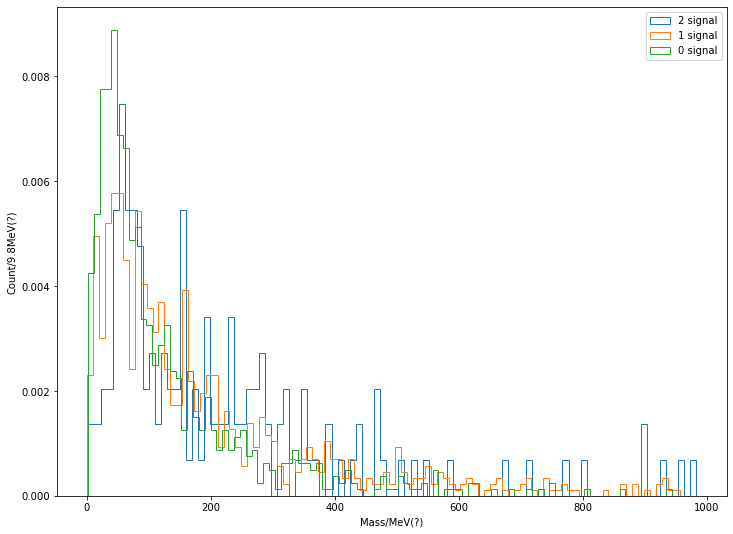

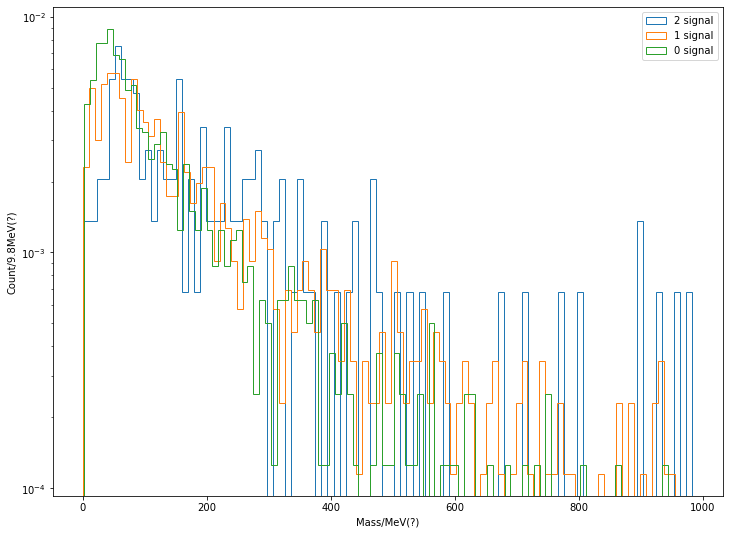

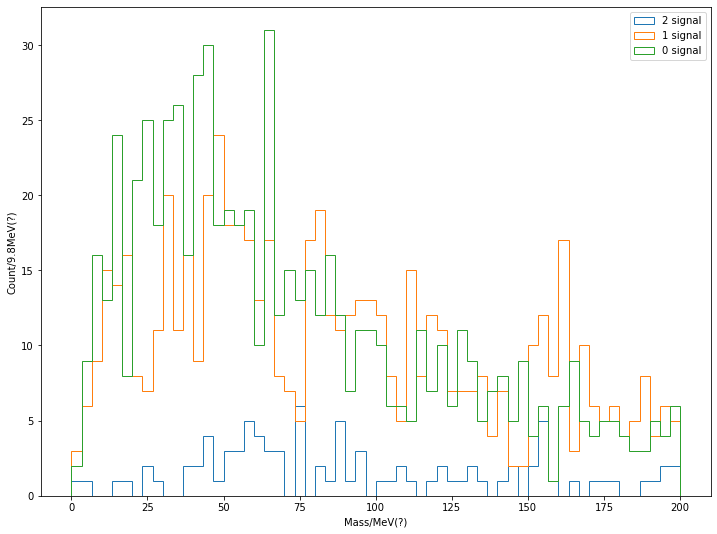

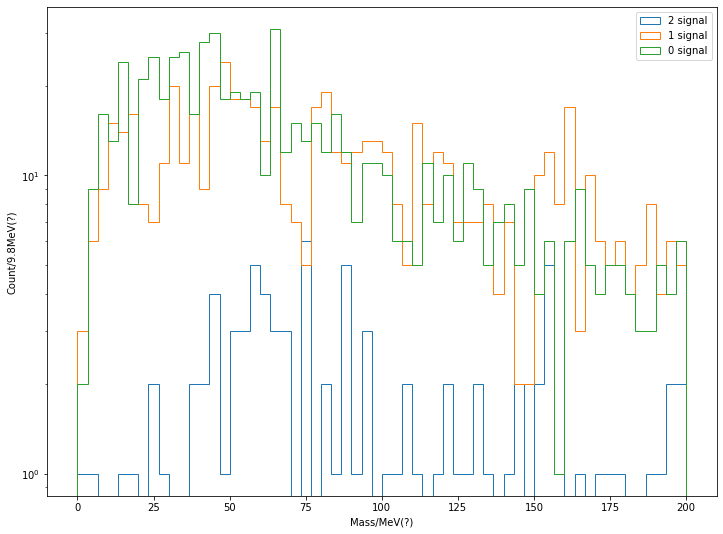

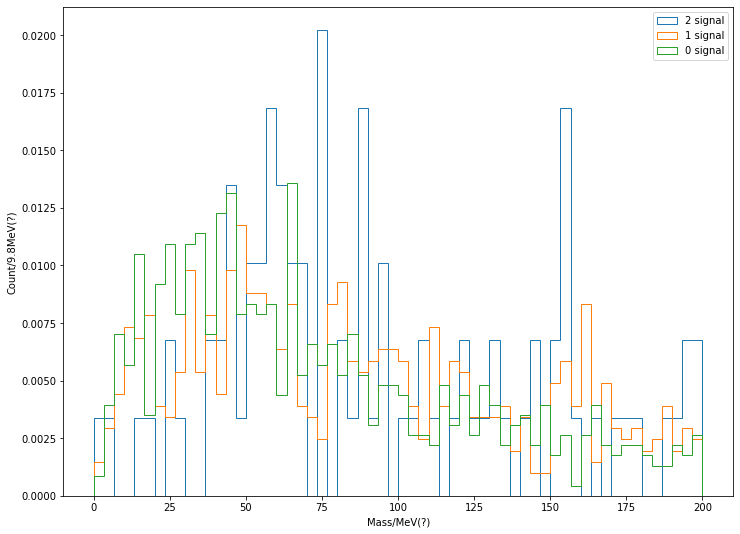

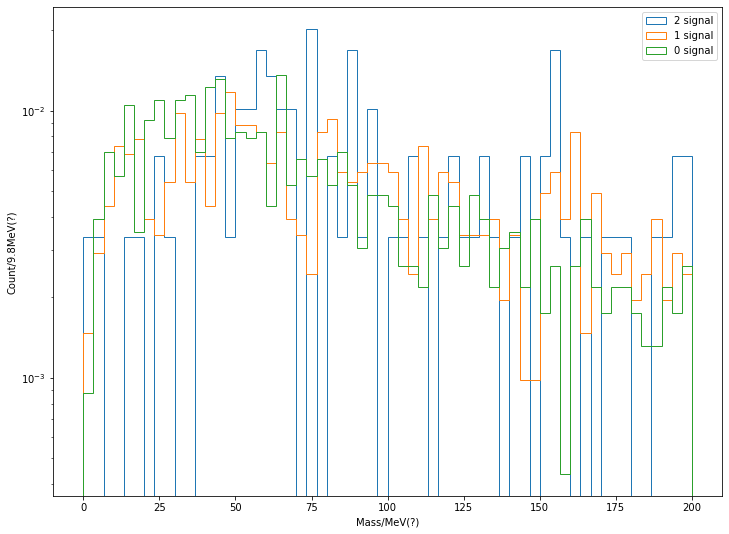

In [52]:
plot_pair_hists("mass", "MeV(?)", paired_mass(evts, pair_coords), sig_count, range=[None, 200], bins=[100, 60], inc_stacked=False)

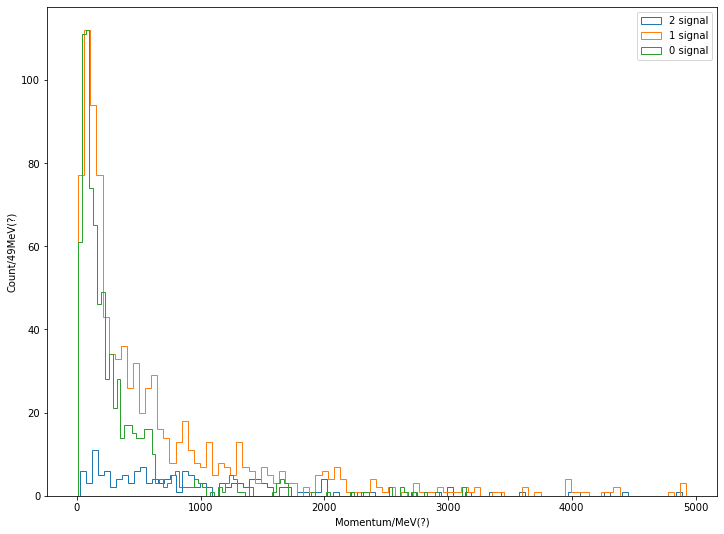

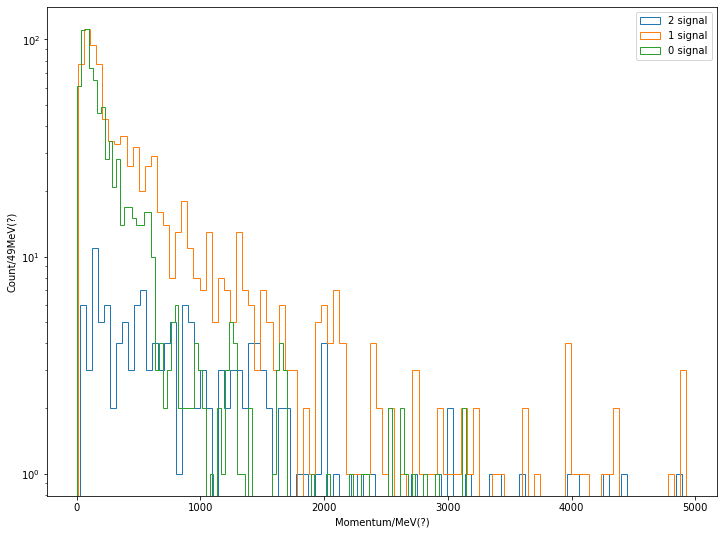

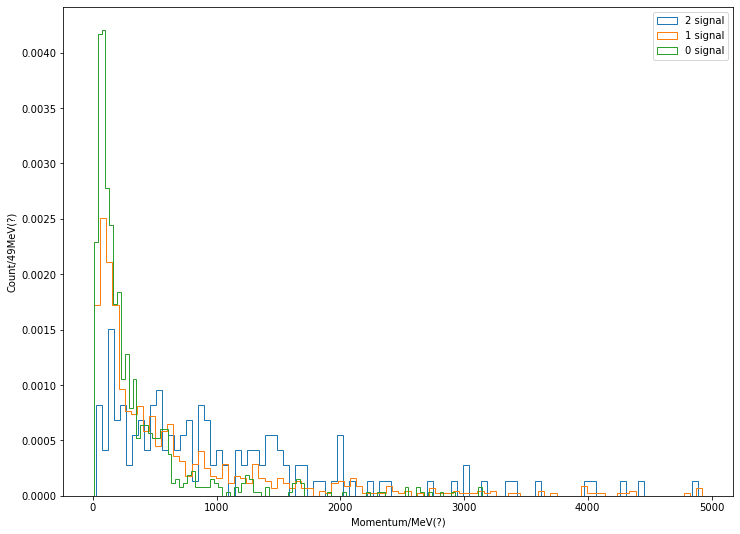

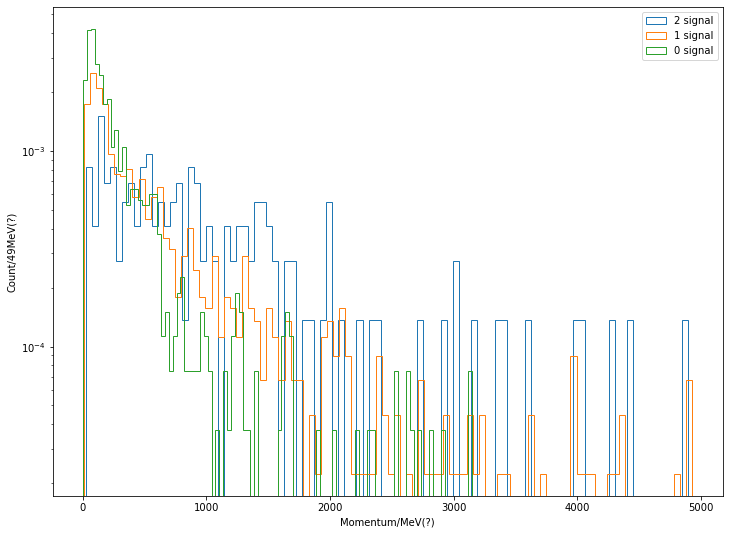

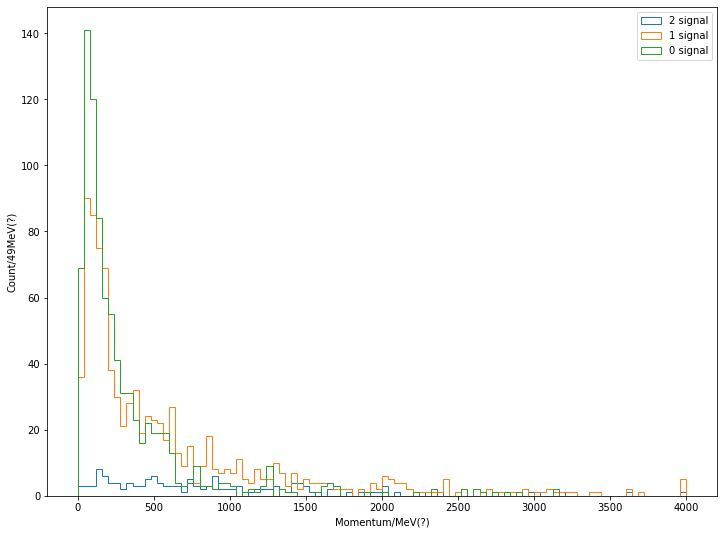

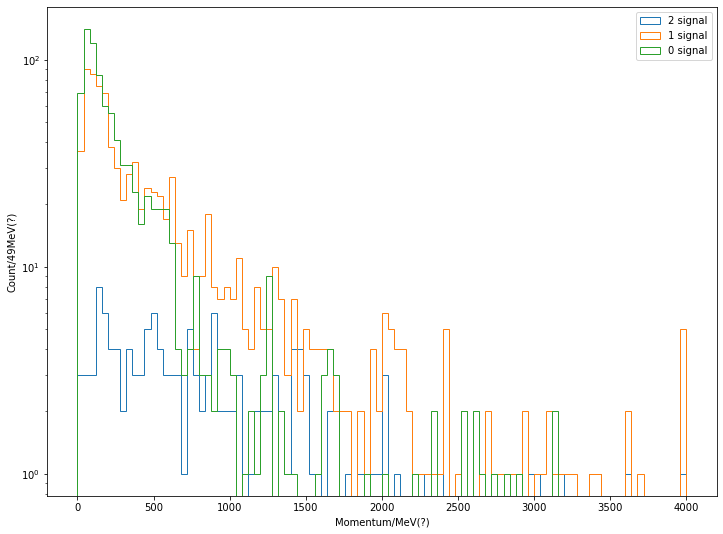

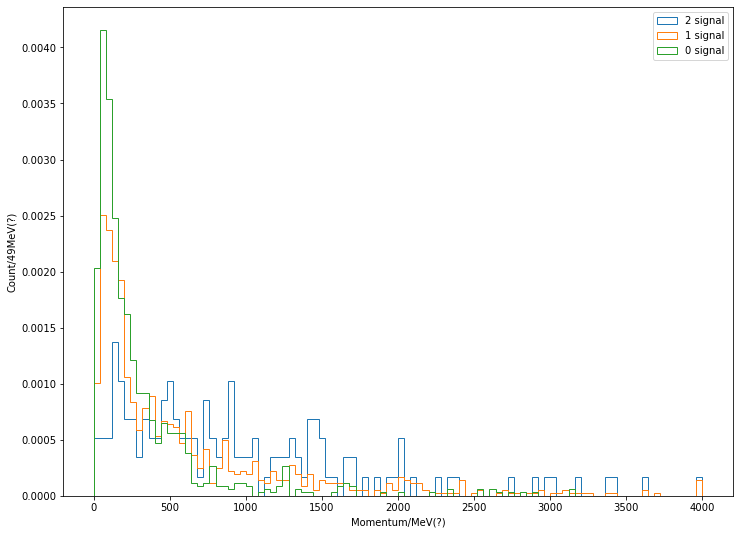

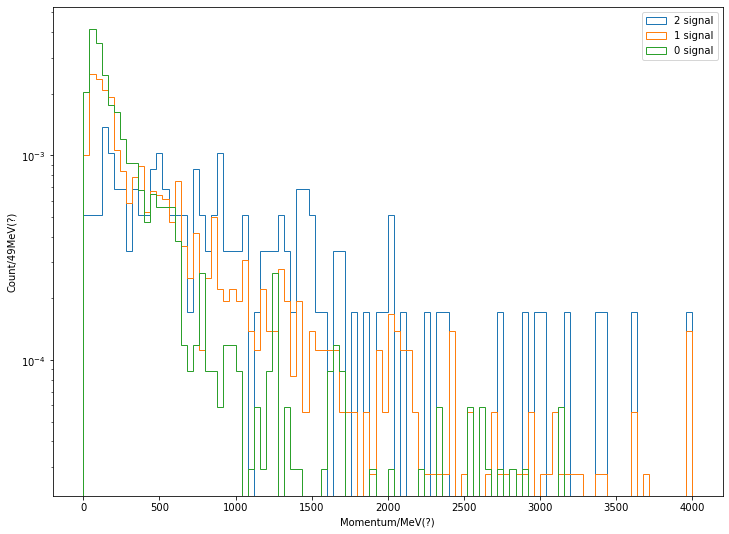

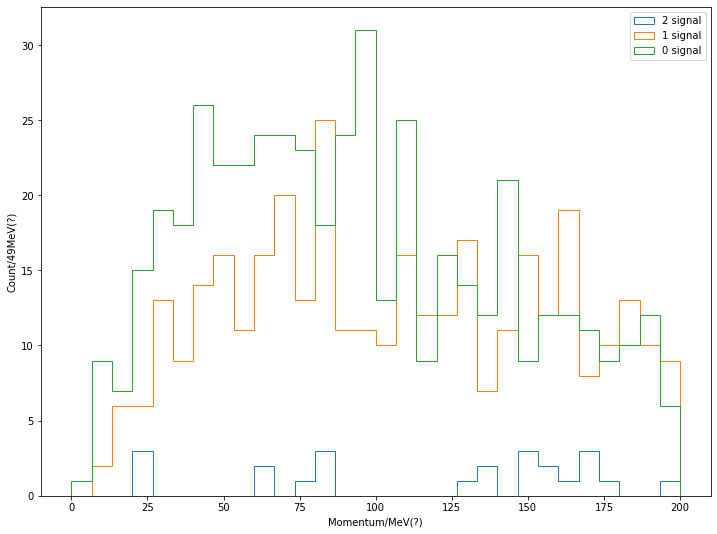

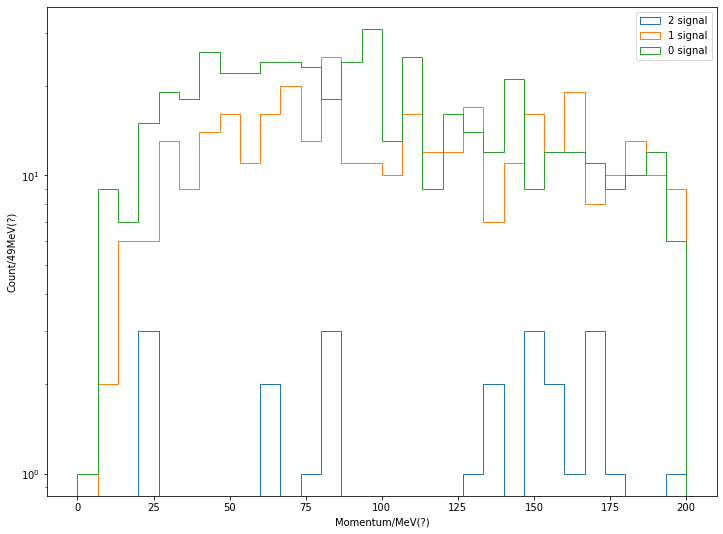

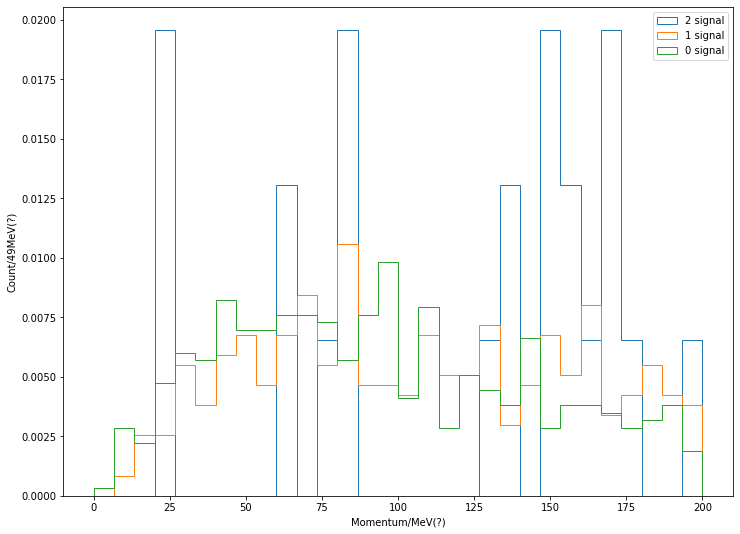

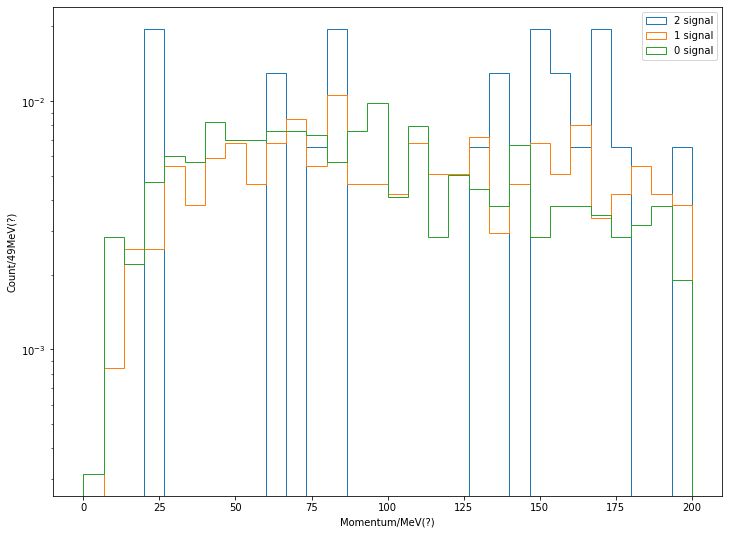

In [53]:
plot_pair_hists("momentum", "MeV(?)", vector.magnitude(paired_momentum(evts, pair_coords)), sig_count, range=[None, 4000, 200], bins=[100,100,30], inc_stacked=False)

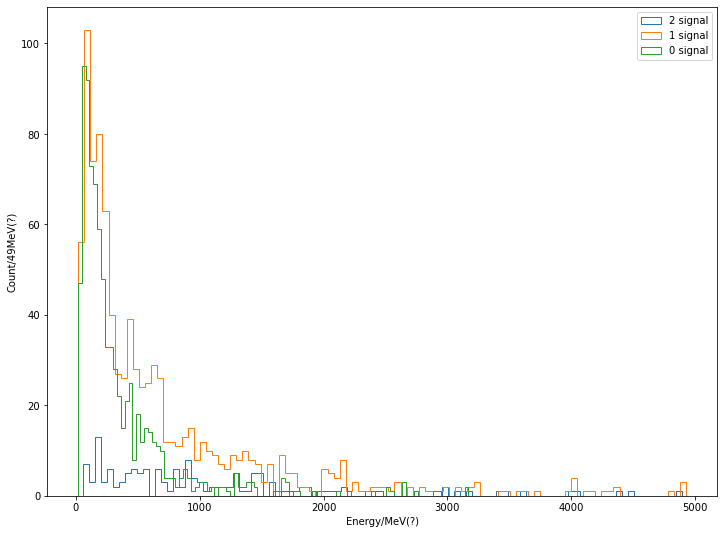

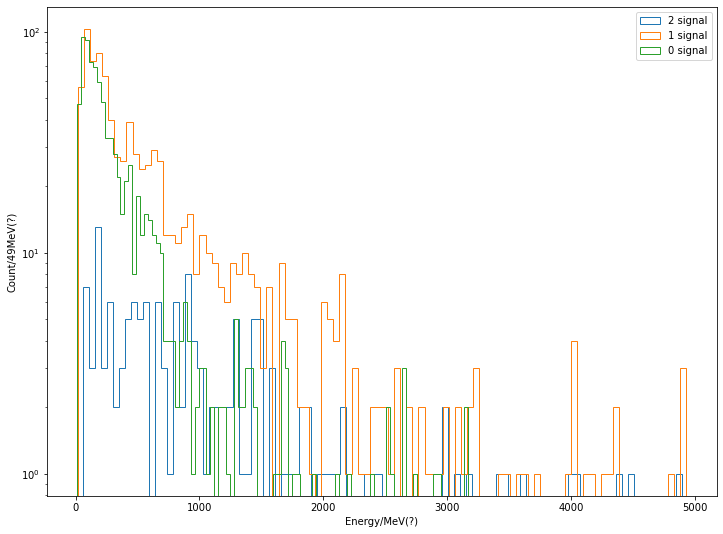

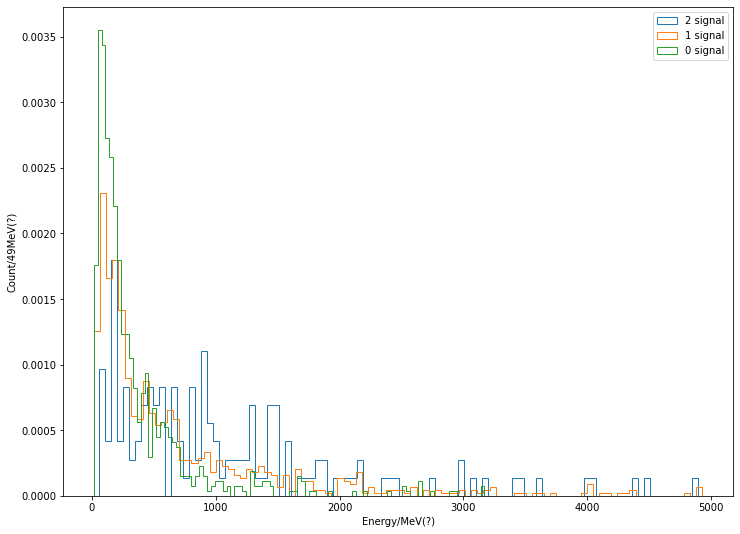

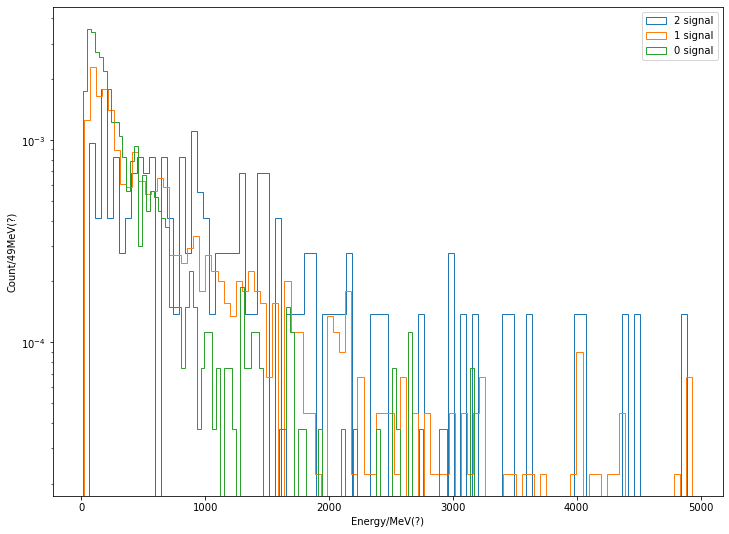

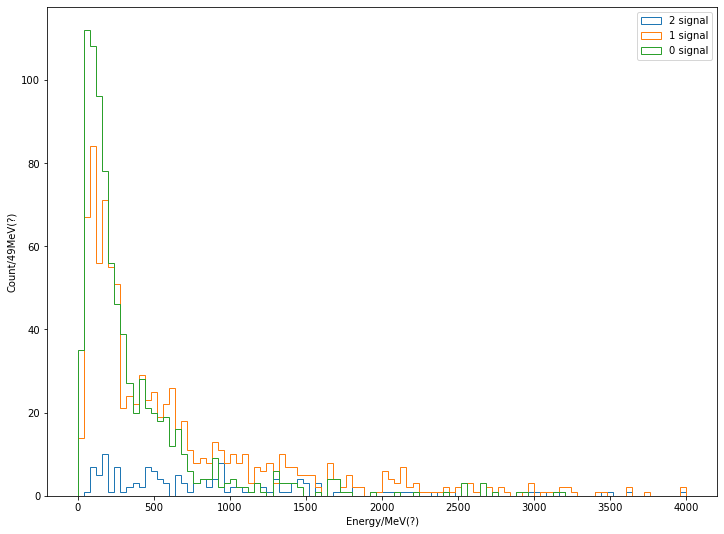

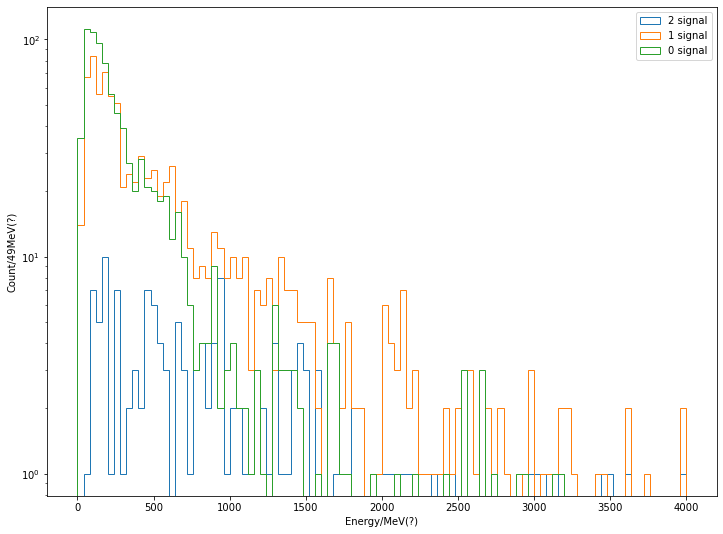

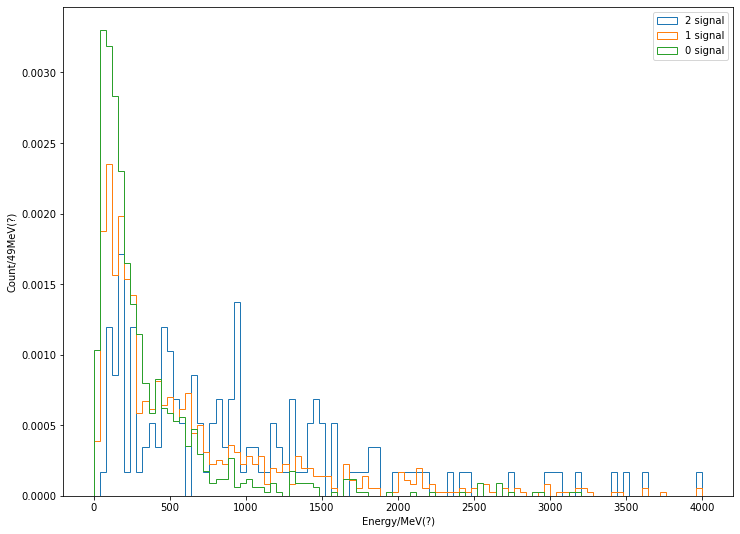

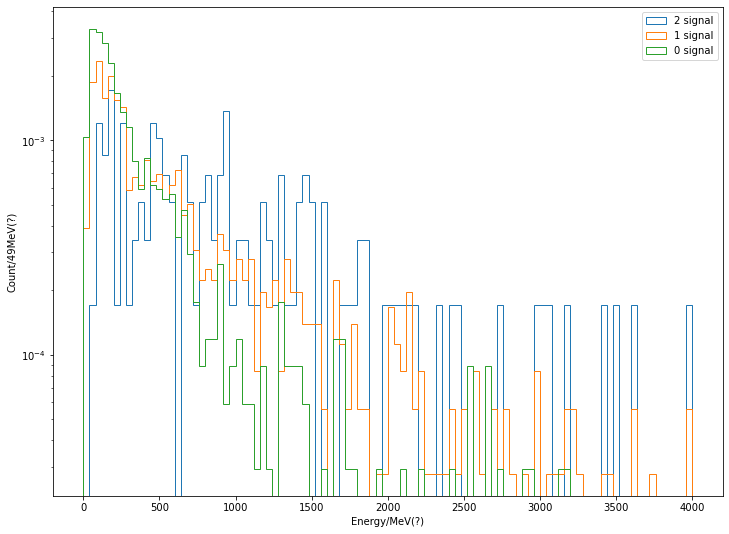

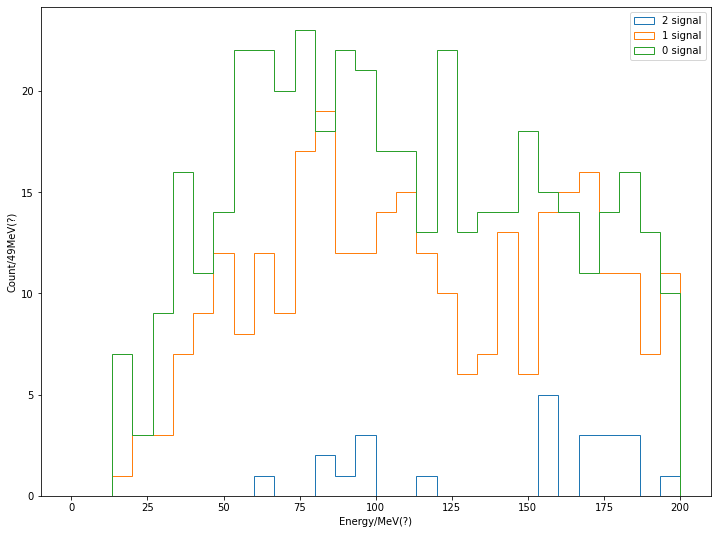

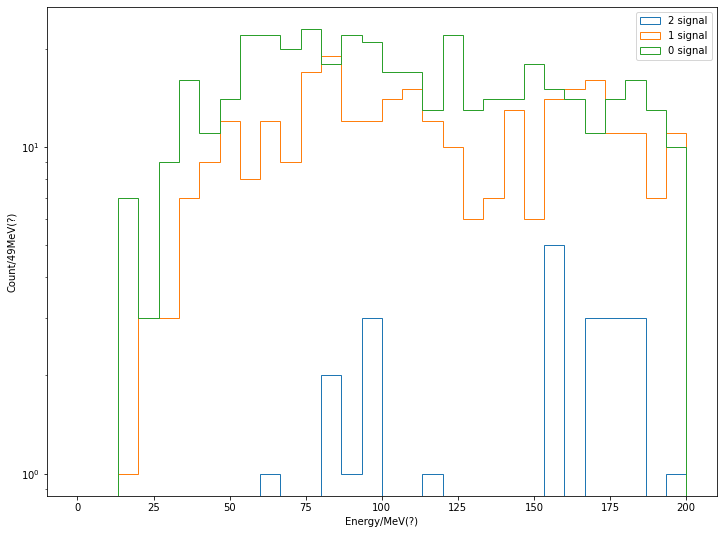

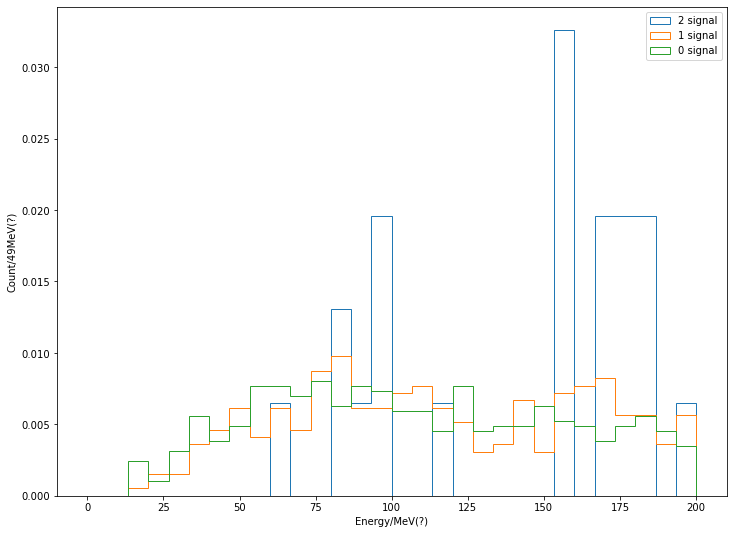

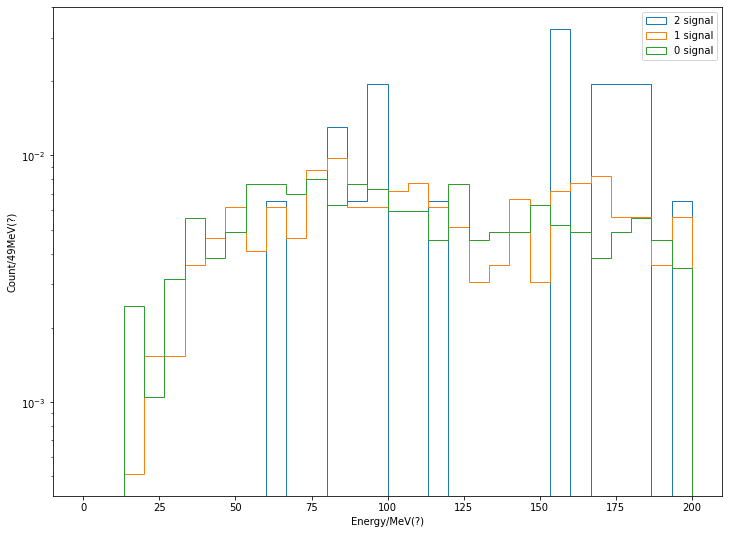

In [54]:
plot_pair_hists("energy", "MeV(?)", paired_energy(evts, pair_coords), sig_count, range=[None, 4000, 200], bins=[100,100,30], inc_stacked=False)

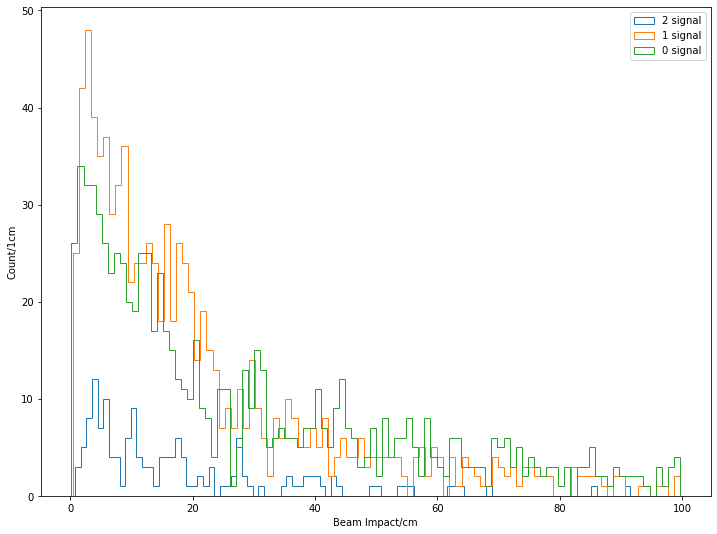

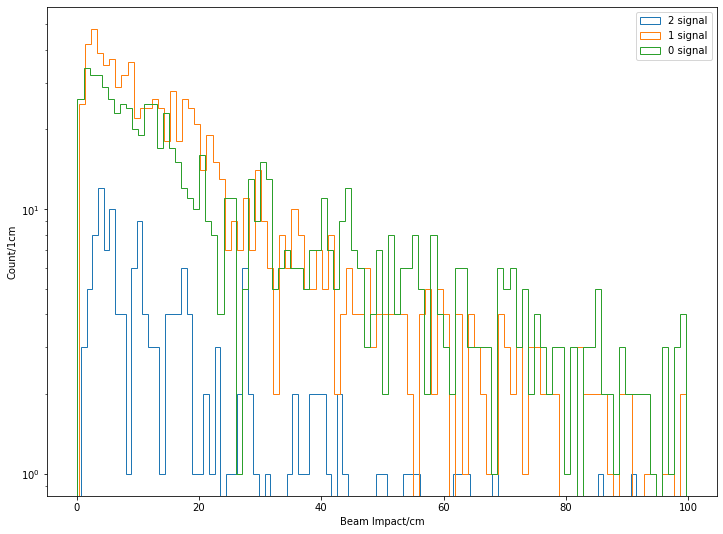

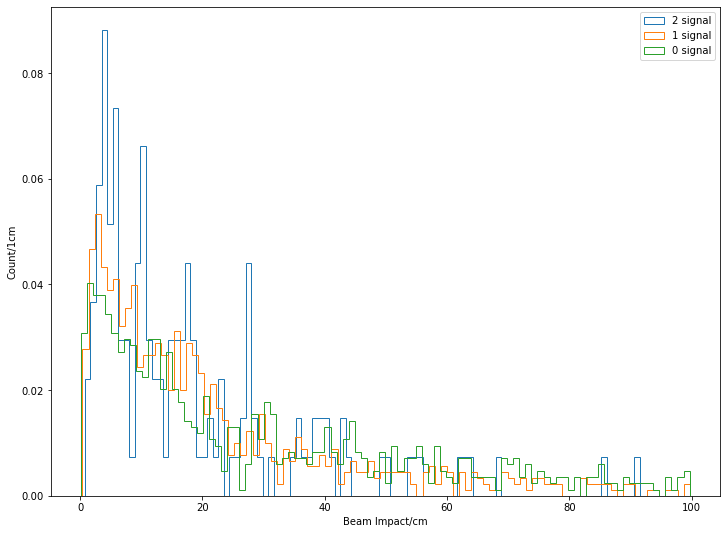

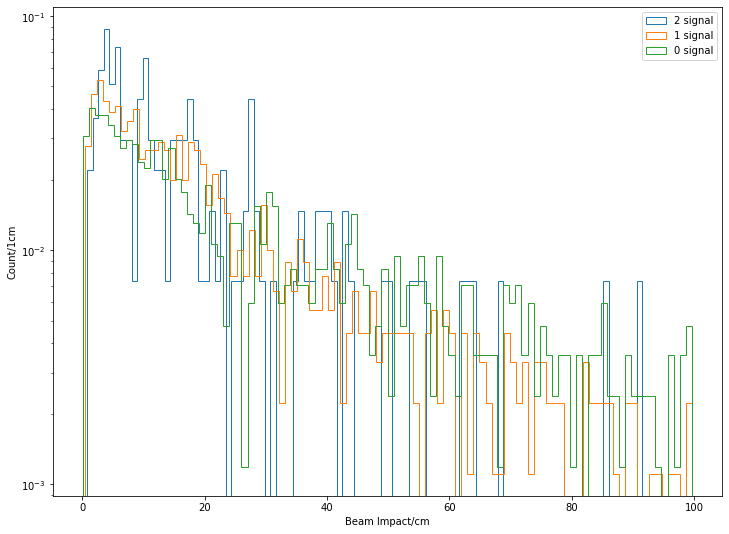

In [55]:
plot_pair_hists("beam impact", "cm", paired_beam_impact(evts, pair_coords), sig_count, bins=100, inc_stacked=False)

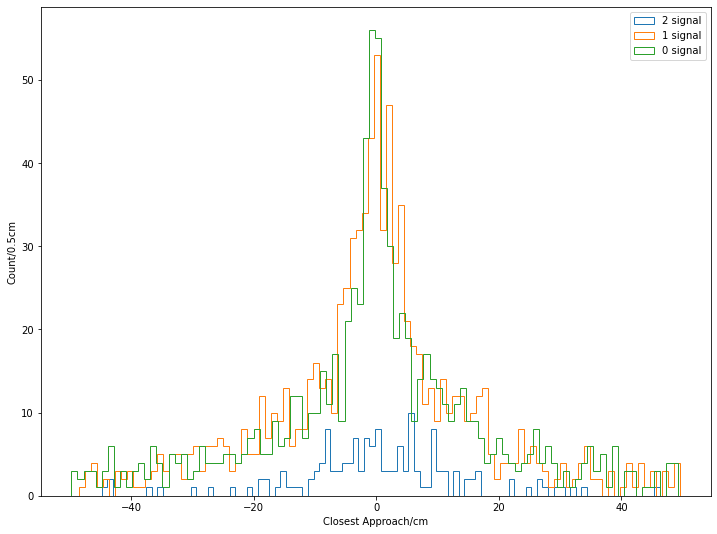

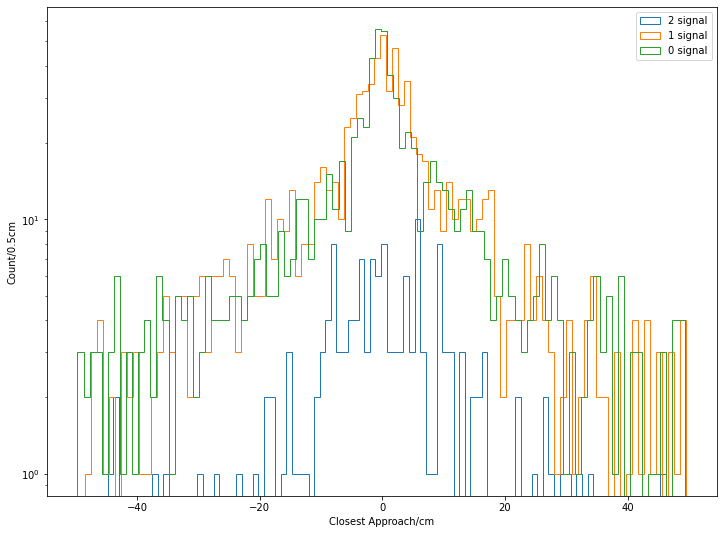

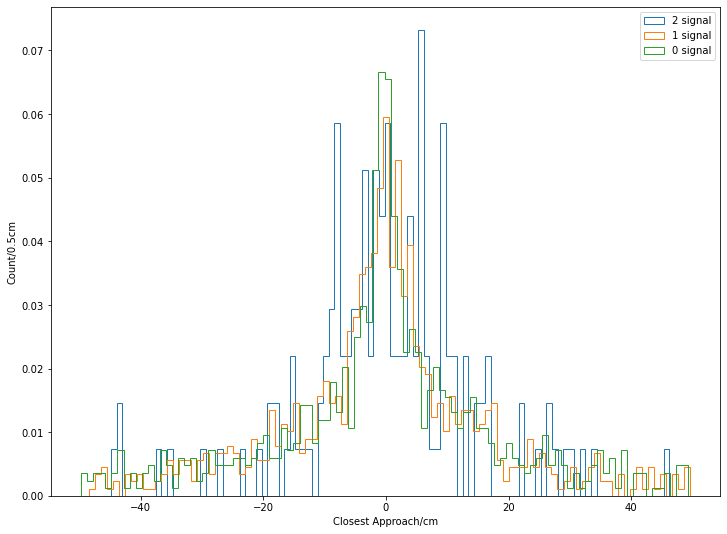

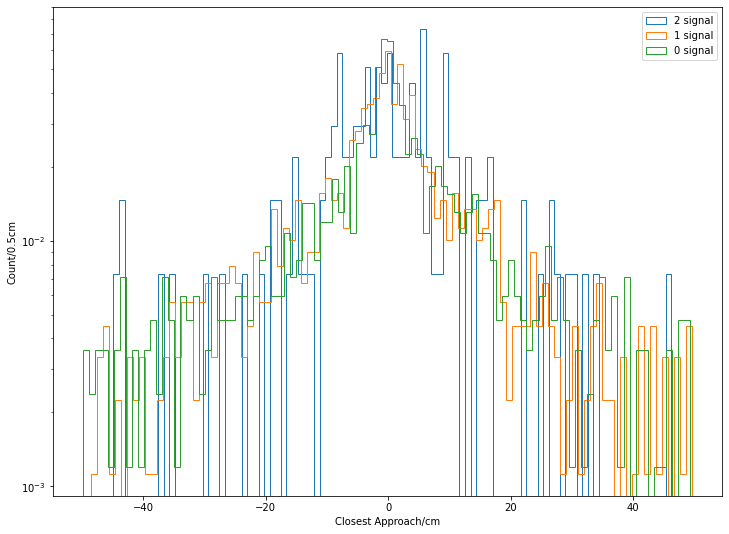

In [56]:
plot_pair_hists("closest approach", "cm", paired_closest_approach(evts, pair_coords), sig_count, bins=100, inc_stacked=False)

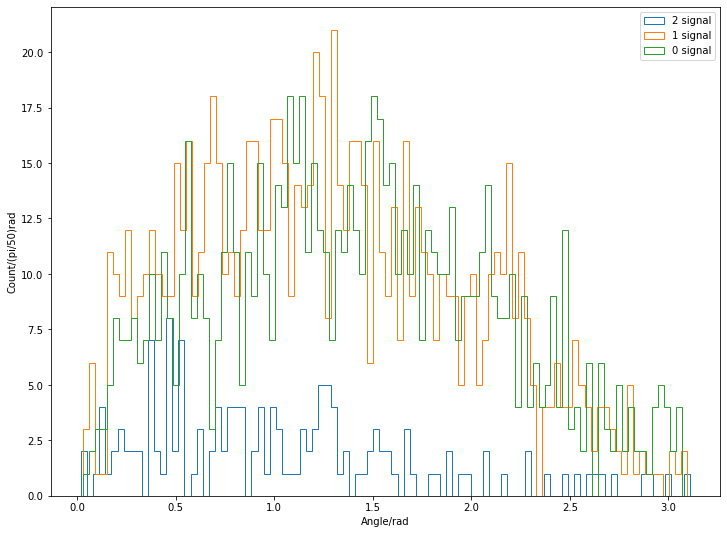

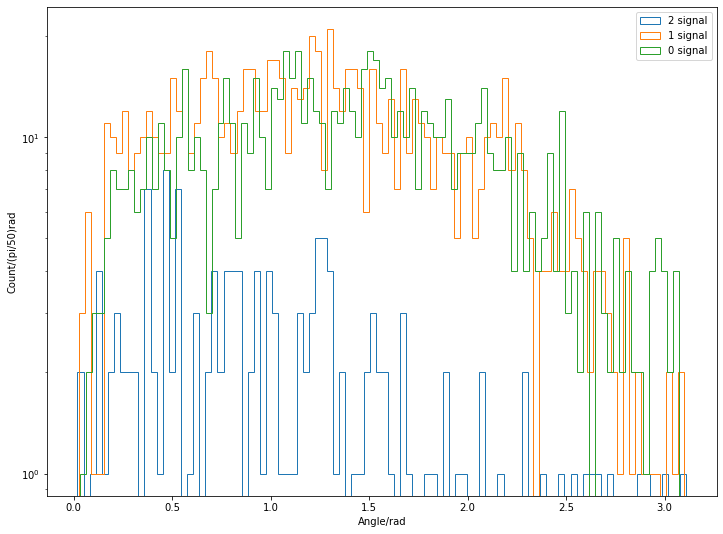

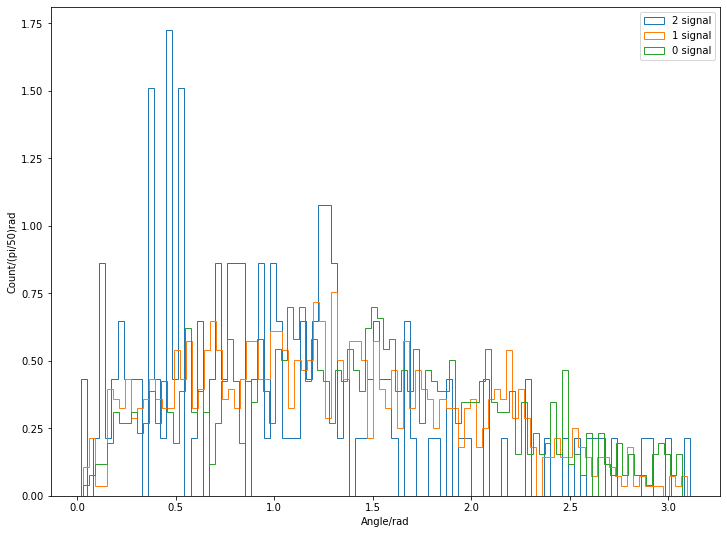

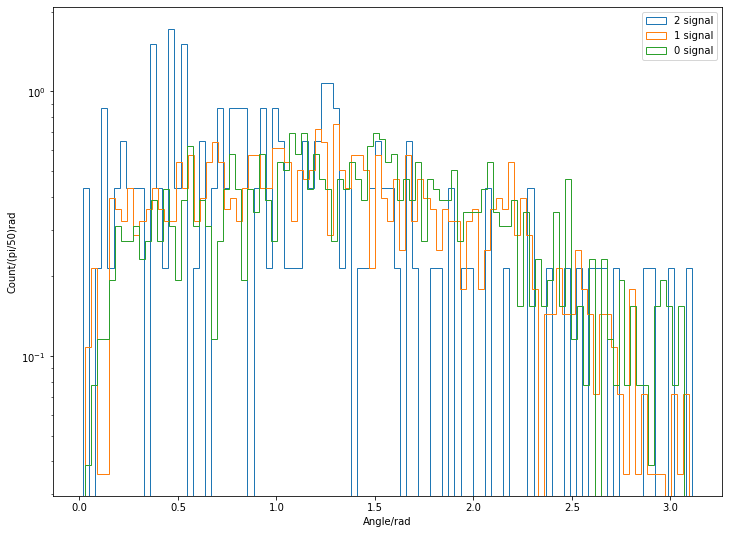

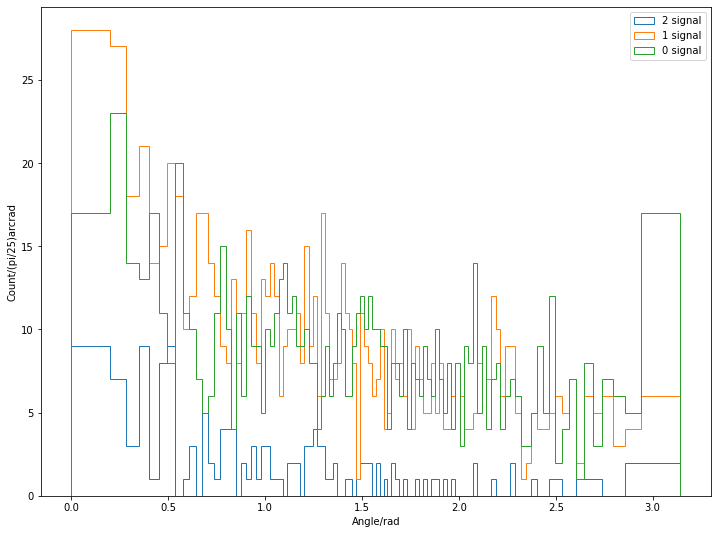

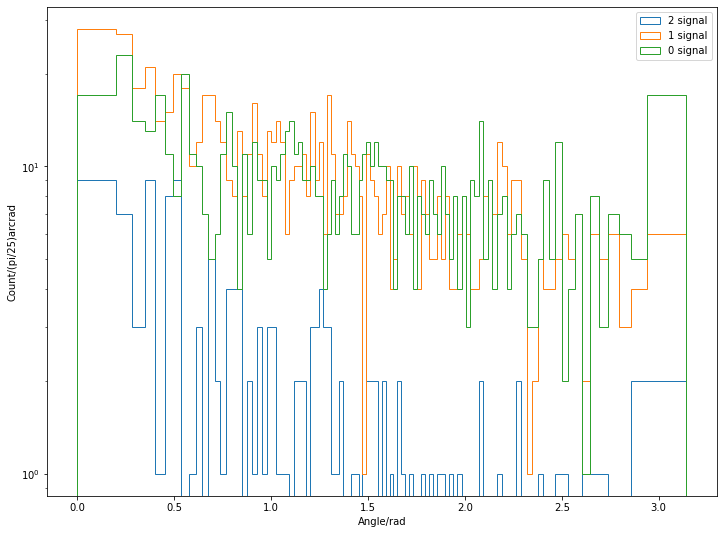

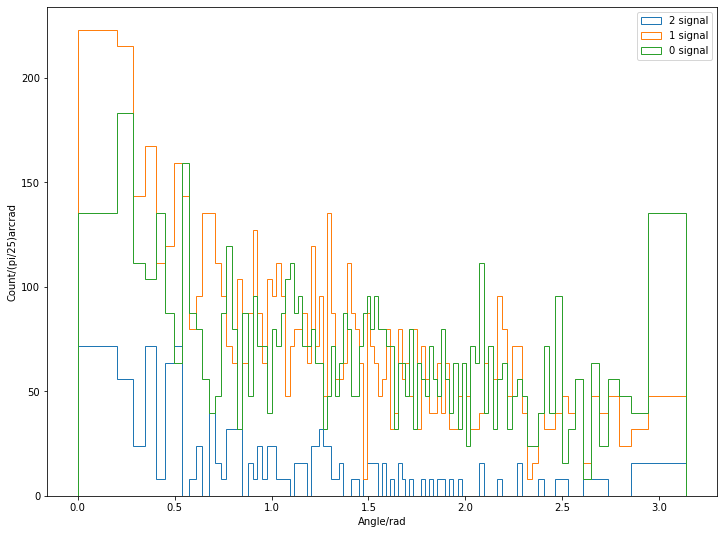

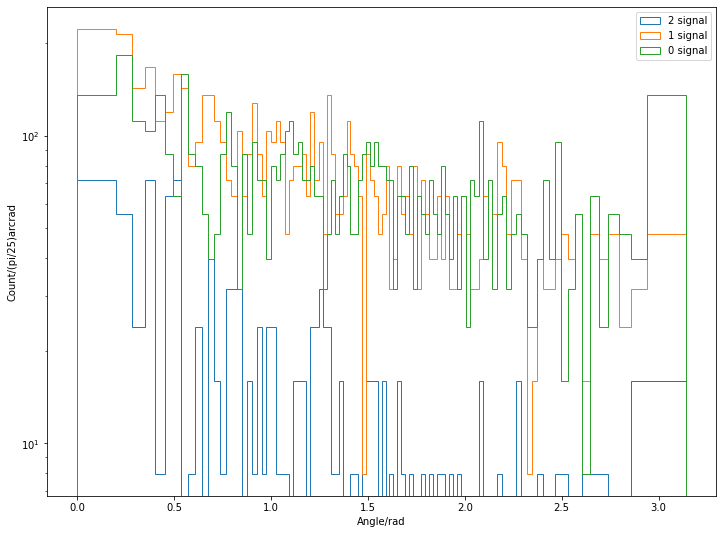

In [57]:
angles = paired_opening_angle(evts, pair_coords)
plot_pair_hists("angle", "rad", angles, sig_count, range=None, bins=100, bin_size="(pi/50)rad", inc_stacked=False)

# Weight the bin widths to keep then with equal area on a sphere
# Area cover over angle dTheta is r sin(Theta) dTheta (with r=1)
# So we need constant sin(Theta) dTheta
# In the range Theta = [0, pi), we have
# \int^\pi_0 sin(\theta) d\theta = 2
# So for 100 bins, we need: sin(Theta) dTheta = 2/100 = 0.02
# \int^{\theta_new}_{\theta_old} sin(\theta) d\theta = 2/100
# So 0.2 = cons(theta_old) - cos(theta_new)
n_bins = 100
bins = np.zeros(n_bins+1)
for i in range(n_bins):
    bins[i+1] = np.arccos(np.max([np.cos(bins[i]) - 2/n_bins, -1]))


# TODO Need to fix the normailisation, currently it's not working!
plot_pair_hists("angle", "rad", angles, sig_count, range=None, bins=bins, bin_size="(pi/25)arcrad", unique_save_id = "_sphere", inc_norm=False, inc_stacked=False)
plot_pair_hists("angle", "rad", angles, sig_count, range=None, bins=bins, bin_size="(pi/25)arcrad", unique_save_id = "_sphere_norm", inc_norm=False, inc_stacked=False, weights=ak.full_like(angles, 1/(0.04*np.pi)))

del angles

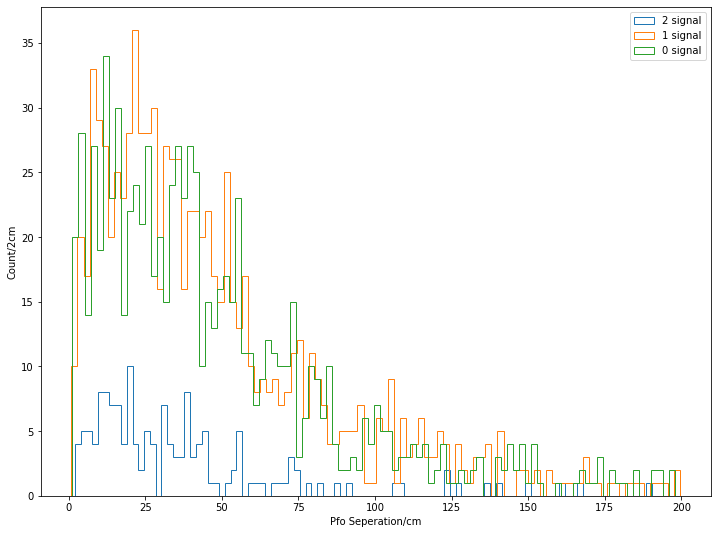

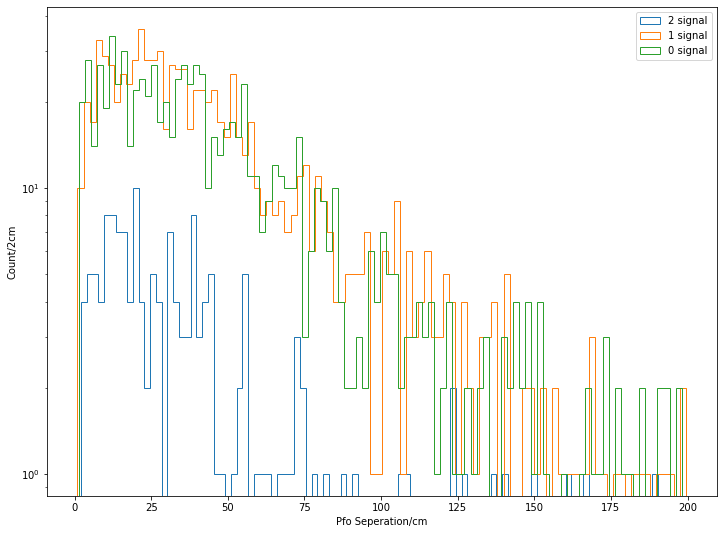

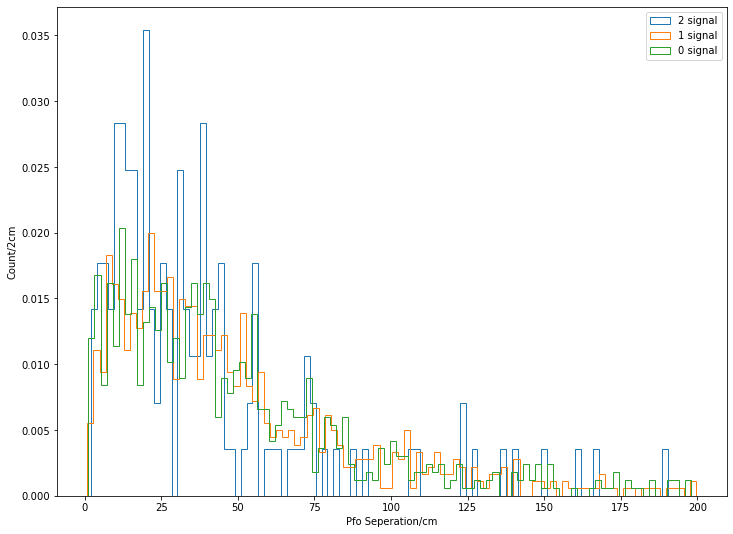

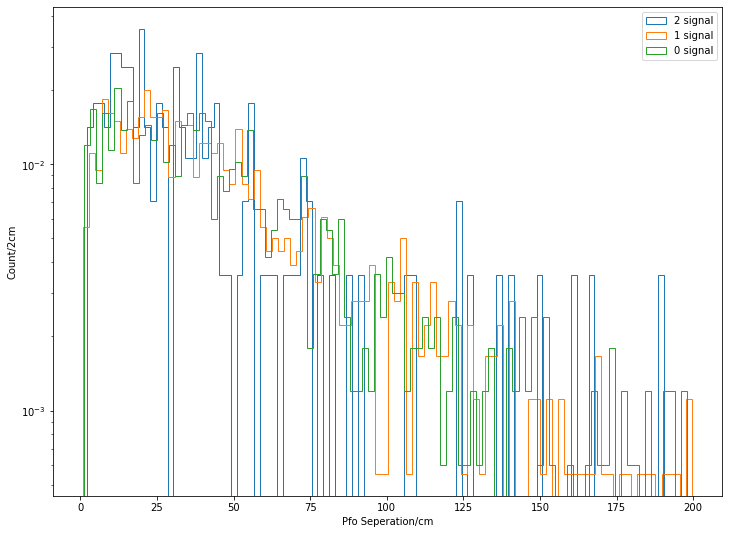

In [58]:
plot_pair_hists("PFO seperation", "cm", paired_separation(evts, pair_coords), sig_count, bins=100, inc_stacked=False)

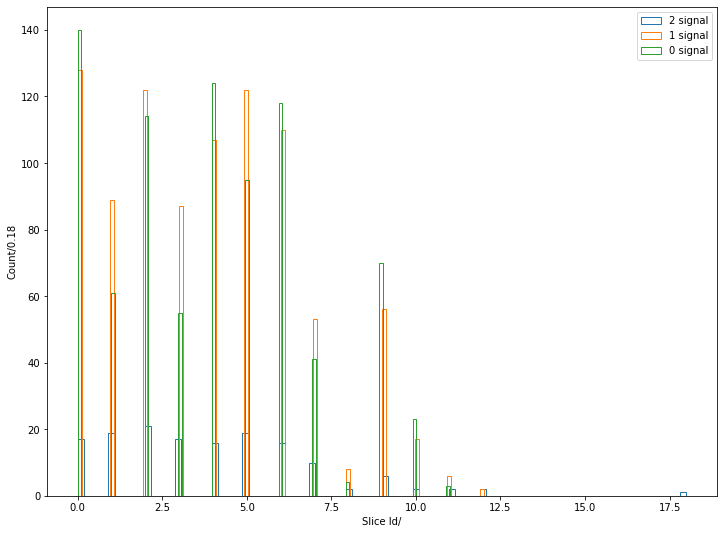

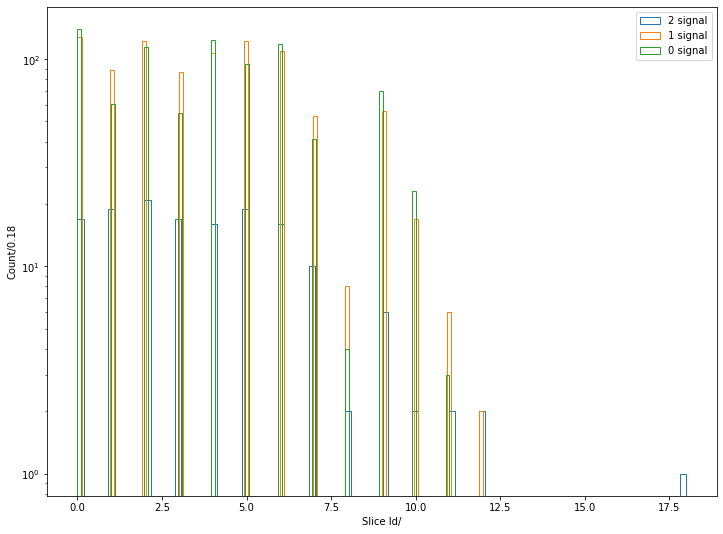

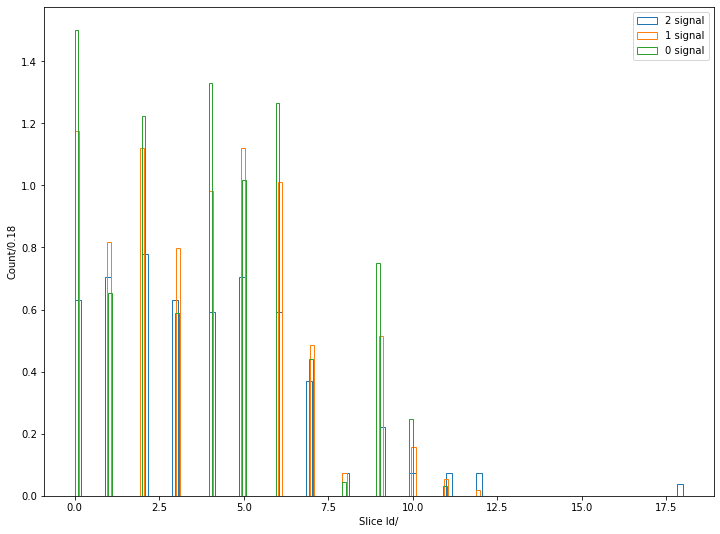

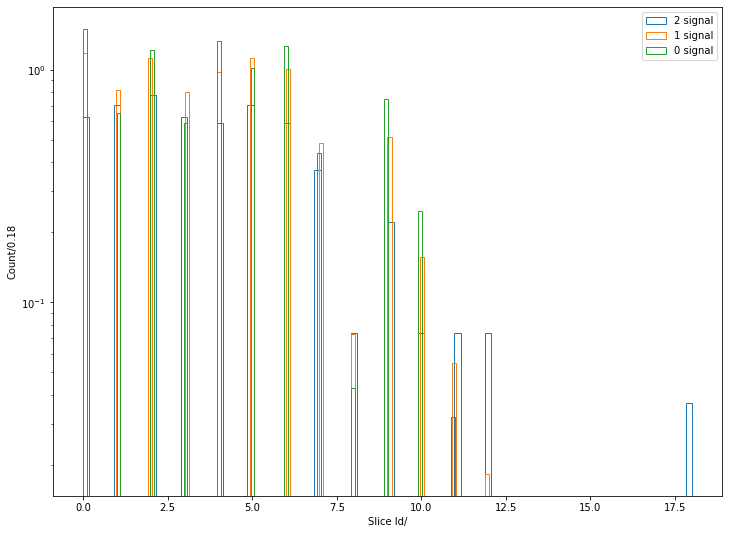

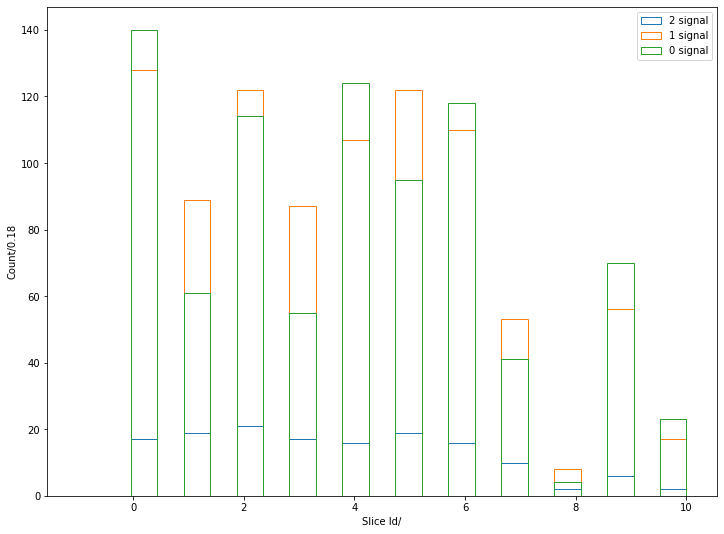

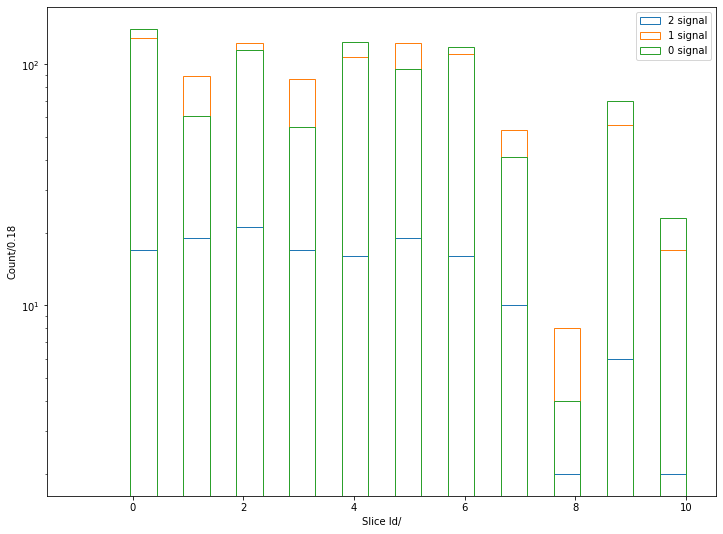

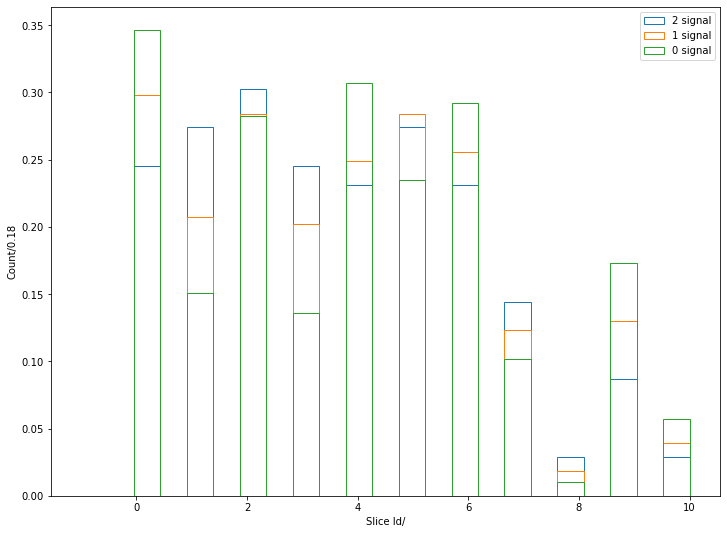

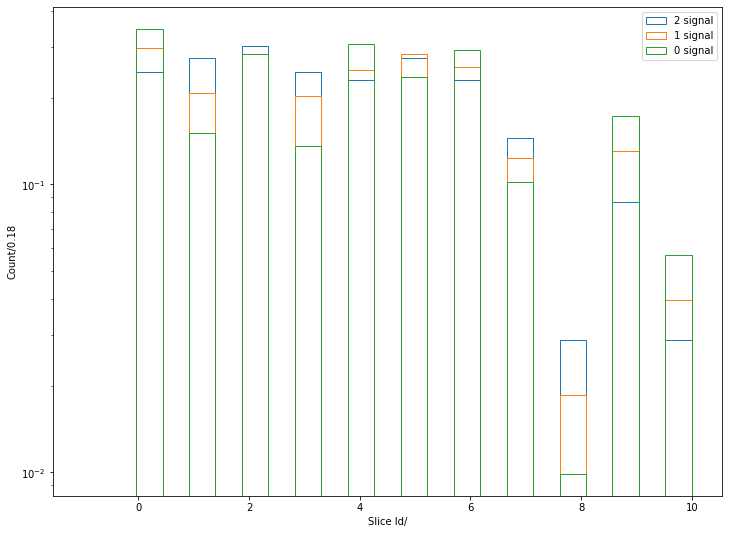

In [59]:
# plot_pair_hists("slice id", "", paired_beam_slice(evts, pair_coords), sig_count, range=[None, (-1,10)], bins=[100, 23], inc_stacked=False)